In [ ]:
### Sección 1 — Setup y verificación del entorno

In [ ]:
!pip install --upgrade pip

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\wilsfrji\AppData\Local\anaconda3\envs\YOLO_Pose_detection\python.exe -m pip install --upgrade pip


In [30]:
# Instala PyTorch + TorchVision para CPU
!pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cpu



Looking in indexes: https://download.pytorch.org/whl/cpu


In [1]:
# Instala las demás librerías necesarias del proyecto
!pip install ultralytics opencv-python==4.8.1.78 numpy==1.24.4 pandas==2.0.3 matplotlib==3.7.5 seaborn==0.12.2 openpyxl==3.1.2 psutil==5.9.8

"""
 BLOQUE 1: IMPORTACIONES Y CONFIGURACIÓN DEL ENTORNO
================================================================
Configuración inicial del entorno YOLO v11 para detección de posturas.
Incluye verificación de compatibilidad y preparación para análisis escalable.
"""

In [1]:

# ═══════════════════════════════════════════════════════════════
# 📦 IMPORTACIONES DEL SISTEMA Y UTILIDADES BÁSICAS
# ═══════════════════════════════════════════════════════════════
import sys, platform, os, json, time, logging
import warnings
from datetime import datetime
from pathlib import Path
from math import degrees, acos, sqrt

# 🔇 Suprimir warnings para ejecución limpia
warnings.filterwarnings("ignore")
# ✅ MEJORA: Agregar supresión específica para PyTorch en CPU
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

# ═══════════════════════════════════════════════════════════════
# 🧠 LIBRERÍAS DE MACHINE LEARNING Y VISIÓN COMPUTACIONAL  
# ═══════════════════════════════════════════════════════════════
import torch, torchvision
import cv2
import numpy as np
from ultralytics import YOLO

# ✅ MEJORA: Verificar versión mínima requerida de ultralytics
try:
    from ultralytics import __version__ as ultralytics_version
    print(f"Ultralytics: {ultralytics_version}")
except ImportError:
    print("Ultralytics: Versión no disponible")

# ═══════════════════════════════════════════════════════════════
# 📊 LIBRERÍAS DE ANÁLISIS DE DATOS Y VISUALIZACIÓN
# ═══════════════════════════════════════════════════════════════
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ MEJORA: Configurar matplotlib para mejor compatibilidad
plt.rcParams['figure.figsize'] = (10, 6)  # Tamaño por defecto
plt.rcParams['font.size'] = 10             # Tamaño de fuente legible

# ═══════════════════════════════════════════════════════════════
# 🔍 VERIFICACIÓN DE COMPATIBILIDAD DEL ENTORNO
# ═══════════════════════════════════════════════════════════════
def verificar_entorno():
    """
    Verifica la compatibilidad del entorno y muestra información del sistema.
    Prepara el entorno para análisis escalable (futuro: umbral relativizado).
    
    Returns:
        dict: Información del sistema para logging/debugging
    """
    info_sistema = {
        'python_version': sys.version.split()[0],
        'platform': platform.platform(),
        'cuda_available': torch.cuda.is_available(),
        'torch_version': torch.__version__,
        'torchvision_version': torchvision.__version__,
        'opencv_version': cv2.__version__
    }
    
    print("=" * 60)
    print("🎯 VERIFICACIÓN DEL ENTORNO - YOLO v11 POSE DETECTION")
    print("=" * 60)
    print(f"Python        : {info_sistema['python_version']}")
    print(f"SO            : {info_sistema['platform']}")
    print(f"CUDA disponible: {info_sistema['cuda_available']}")
    print(f"PyTorch       : {info_sistema['torch_version']}")
    print(f"TorchVision   : {info_sistema['torchvision_version']}")
    print(f"OpenCV        : {info_sistema['opencv_version']}")
    
    # ⚠️ VALIDACIONES CRÍTICAS
    validaciones = []
    
    # Verificar versión de Python
    if sys.version_info < (3, 7):
        validaciones.append("❌ Python 3.7+ requerido")
    else:
        validaciones.append("✅ Versión de Python compatible")
    
    # Verificar OpenCV
    cv_version = tuple(map(int, cv2.__version__.split('.')))
    if cv_version < (4, 5):
        validaciones.append("⚠️ OpenCV 4.5+ recomendado")
    else:
        validaciones.append("✅ OpenCV compatible")
    
    # Verificar PyTorch
    torch_version = tuple(map(int, torch.__version__.split('+')[0].split('.')))
    if torch_version < (2, 0):
        validaciones.append("⚠️ PyTorch 2.0+ recomendado")
    else:
        validaciones.append("✅ PyTorch compatible")
    
    print("\n🔍 VALIDACIONES:")
    for validacion in validaciones:
        print(f"  {validacion}")
    
    print("=" * 60)
    
    return info_sistema

# Ejecutar verificación
info_entorno = verificar_entorno()

# ═══════════════════════════════════════════════════════════════
# 📝 CONFIGURACIÓN DE LOGGING AVANZADA
# ═══════════════════════════════════════════════════════════════
def configurar_logging(nivel=logging.INFO, archivo_log=None):
    """
    Configura logging para el proyecto con formato mejorado.
    
    Args:
        nivel: Nivel de logging (INFO, DEBUG, WARNING, ERROR)
        archivo_log: Ruta opcional para guardar logs en archivo
    """
    # Formato mejorado con colores en consola
    formato_consola = "%(asctime)s | %(levelname)-8s | %(message)s"
    formato_fecha = "%Y-%m-%d %H:%M:%S"
    
    # Configurar handlers
    handlers = [logging.StreamHandler()]
    
    # ✅ MEJORA: Opción de guardar logs en archivo
    if archivo_log:
        log_path = Path(archivo_log)
        log_path.parent.mkdir(exist_ok=True)
        handlers.append(logging.FileHandler(log_path))
    
    logging.basicConfig(
        level=nivel,
        format=formato_consola,
        datefmt=formato_fecha,
        handlers=handlers,
        force=True  # ✅ Fuerza reconfiguración si ya existe
    )
    
    return logging.getLogger(__name__)

# Configurar logger del proyecto
logger = configurar_logging(
    nivel=logging.INFO,
    archivo_log=f"logs/yolo_pose_detection_{datetime.now().strftime('%Y%m%d')}.log"
)

# ═══════════════════════════════════════════════════════════════
# 🎯 CONSTANTES GLOBALES PARA ANÁLISIS ESCALABLE
# ═══════════════════════════════════════════════════════════════
# ✅ PREPARACIÓN PARA UMBRAL RELATIVIZADO (futuro)
KEYPOINTS_MIEMBROS_SUPERIORES = {
    'hombro_izq': 5, 'hombro_der': 6,      # Línea de referencia actual
    'codo_izq': 7,   'codo_der': 8,        # Puntos de detección principal
    'muneca_izq': 9, 'muneca_der': 10      # Puntos de detección secundaria
}

# ✅ PREPARADO PARA FUTURO: Keypoints del tronco para normalización
KEYPOINTS_TRONCO_REFERENCIA = {
    'hombro_izq': 5, 'hombro_der': 6,      # Línea superior del tronco
    'cadera_izq': 11, 'cadera_der': 12     # Línea inferior del tronco (futuro)
}

# Modo de análisis actual (preparado para escalabilidad)
MODO_ANALISIS = "simple"  # ✅ CRÍTICO: Variable global que faltaba

logger.info("🎯 Entorno verificado y configurado correctamente")
logger.info(f"📊 Modo de análisis activo: {MODO_ANALISIS.upper()}")
logger.info("🚀 Sistema listo para cargar modelo YOLO v11")


Ultralytics: 8.3.198


2025-10-16 10:11:53 | INFO     | 🎯 Entorno verificado y configurado correctamente
2025-10-16 10:11:53 | INFO     | 📊 Modo de análisis activo: SIMPLE
2025-10-16 10:11:53 | INFO     | 🚀 Sistema listo para cargar modelo YOLO v11


🎯 VERIFICACIÓN DEL ENTORNO - YOLO v11 POSE DETECTION
Python        : 3.8.20
SO            : Windows-10-10.0.22621-SP0
CUDA disponible: False
PyTorch       : 2.2.2+cpu
TorchVision   : 0.17.2+cpu
OpenCV        : 4.8.1

🔍 VALIDACIONES:
  ✅ Versión de Python compatible
  ✅ OpenCV compatible
  ✅ PyTorch compatible


"""
🤖 BLOQUE 2: CONFIGURACIÓN Y CARGA DEL MODELO YOLO v11
================================================================
Configuración de parámetros, selección de modelo y carga optimizada.
Incluye manejo de errores y preparación para análisis escalable.
"""

In [2]:
# ═══════════════════════════════════════════════════════════════
# 🎯 CONFIGURACIÓN DE MODELOS DISPONIBLES
# ═══════════════════════════════════════════════════════════════
# Modelos YOLO v11 Pose disponibles (se descargan automáticamente)
MODELOS_DISPONIBLES = {
    "rapido": {
        "archivo": "yolo11n-pose.pt",
        "descripcion": "YOLOv11 Nano - Rápido, menor precisión",
        "tamaño_mb": "~6MB",
        "fps_estimado": "60-80 FPS"
    },
    "preciso": {
        "archivo": "yolo11s-pose.pt", 
        "descripcion": "YOLOv11 Small - Mayor precisión, más lento",
        "tamaño_mb": "~22MB",
        "fps_estimado": "40-60 FPS"
    },
    # ✅ PREPARADO PARA FUTURO: Modelos adicionales
    "medio": {
        "archivo": "yolo11m-pose.pt",
        "descripcion": "YOLOv11 Medium - Balance precisión/velocidad",
        "tamaño_mb": "~50MB", 
        "fps_estimado": "25-40 FPS"
    }
}

# ═══════════════════════════════════════════════════════════════
# ⚙️ SELECCIÓN DEL MODELO
# ═══════════════════════════════════════════════════════════════
# ✅ MEJORA: Función para seleccionar modelo con validación
def seleccionar_modelo(tipo_modelo="rapido"):
    """
    Selecciona y valida el modelo a utilizar.
    
    Args:
        tipo_modelo (str): "rapido", "preciso", o "medio"
        
    Returns:
        tuple: (archivo_modelo, info_modelo)
    """
    if tipo_modelo not in MODELOS_DISPONIBLES:
        logger.warning(f"Modelo '{tipo_modelo}' no válido. Usando 'rapido' por defecto.")
        tipo_modelo = "rapido"
    
    modelo_info = MODELOS_DISPONIBLES[tipo_modelo]
    logger.info(f"🎯 Modelo seleccionado: {tipo_modelo.upper()}")
    logger.info(f"   📁 Archivo: {modelo_info['archivo']}")
    logger.info(f"   📊 Descripción: {modelo_info['descripcion']}")
    logger.info(f"   💾 Tamaño: {modelo_info['tamaño_mb']}")
    logger.info(f"   ⚡ Rendimiento: {modelo_info['fps_estimado']}")
    
    return modelo_info['archivo'], modelo_info

# Seleccionar modelo (puedes cambiar entre "rapido", "preciso", "medio")
TIPO_MODELO_ACTUAL = "rapido"  # ✅ CONFIGURABLE: Cambiar aquí para otro modelo
MODEL_WEIGHTS, MODEL_INFO = seleccionar_modelo(TIPO_MODELO_ACTUAL)

# ═══════════════════════════════════════════════════════════════
# 🎛️ PARÁMETROS GLOBALES DE DETECCIÓN
# ═══════════════════════════════════════════════════════════════
class ConfiguracionDeteccion:
    """
    Configuración centralizada para detección de poses.
    Preparado para escalabilidad y fácil ajuste de parámetros.
    """
    
    # 🔍 PARÁMETROS DE CONFIANZA
    CONF_THRESH = 0.25      # Confianza mínima para detectar persona (0.0-1.0)
    KEYP_CONF = 0.50        # Umbral para considerar keypoints válidos (0.0-1.0)
    IOU_THRESH = 0.45       # Intersección sobre unión para NMS (0.0-1.0)
    
    # 🎯 PARÁMETROS ESPECÍFICOS PARA MIEMBROS SUPERIORES
    MIN_CONF_HOMBROS = 0.6  # ✅ NUEVO: Confianza mínima para hombros (críticos)
    MIN_CONF_CODOS = 0.5    # ✅ NUEVO: Confianza mínima para codos
    MIN_CONF_MUNECAS = 0.4  # ✅ NUEVO: Confianza mínima para muñecas (más variables)
    
    # 🏗️ PREPARADO PARA FUTURO: Parámetros umbral relativizado
    MIN_CONF_TRONCO = 0.6           # Confianza mínima para keypoints del tronco
    ALTURA_TRONCO_REFERENCIA = 100  # Altura estándar del tronco en píxeles
    FACTOR_NORMALIZACION = 1.0      # Factor de corrección (ajustable)
    
    @classmethod
    def mostrar_configuracion(cls):
        """Muestra la configuración actual en logs."""
        logger.info("⚙️ CONFIGURACIÓN DE DETECCIÓN:")
        logger.info(f"   🎯 Confianza general: {cls.CONF_THRESH}")
        logger.info(f"   🔍 Confianza keypoints: {cls.KEYP_CONF}")
        logger.info(f"   📐 IoU threshold: {cls.IOU_THRESH}")
        logger.info(f"   💪 Confianza hombros: {cls.MIN_CONF_HOMBROS}")
        logger.info(f"   🔧 Confianza codos: {cls.MIN_CONF_CODOS}")
        logger.info(f"   ✋ Confianza muñecas: {cls.MIN_CONF_MUNECAS}")

# Instanciar configuración
config = ConfiguracionDeteccion()

# ═══════════════════════════════════════════════════════════════
# 🖥️ CONFIGURACIÓN DE DISPOSITIVO
# ═══════════════════════════════════════════════════════════════
def configurar_dispositivo():
    """
    Configura automáticamente el mejor dispositivo disponible.
    
    Returns:
        str: Dispositivo seleccionado ("cuda:0", "mps", o "cpu")
    """
    if torch.cuda.is_available():
        device = "cuda:0"
        gpu_name = torch.cuda.get_device_name(0)
        memoria_gpu = torch.cuda.get_device_properties(0).total_memory / 1024**3
        logger.info(f"🚀 GPU CUDA detectada: {gpu_name}")
        logger.info(f"💾 Memoria GPU: {memoria_gpu:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = "mps"  # Apple Silicon
        logger.info("🍎 Dispositivo MPS (Apple Silicon) detectado")
    else:
        device = "cpu"
        logger.info("💻 Usando CPU (sin aceleración GPU)")
    
    return device

# ═══════════════════════════════════════════════════════════════
# 🤖 CARGA DEL MODELO CON MANEJO DE ERRORES
# ═══════════════════════════════════════════════════════════════
def cargar_modelo_yolo(model_weights, device):
    """
    Carga el modelo YOLO con manejo de errores robusto.
    
    Args:
        model_weights (str): Ruta del modelo
        device (str): Dispositivo objetivo
        
    Returns:
        YOLO: Modelo cargado y configurado
    """
    try:
        logger.info(f"📥 Descargando/cargando modelo: {model_weights}")
        logger.info("⏳ Primera ejecución puede tardar (descarga automática)...")
        
        # ✅ MEJORA: Crear modelo con configuración explícita
        model = YOLO(model_weights)
        
        # Mover al dispositivo seleccionado
        model.to(device)
        
        # ✅ MEJORA: Verificar que el modelo es para pose detection
        if not hasattr(model, 'names') or len(model.names) == 0:
            logger.warning("⚠️ Modelo cargado sin nombres de clases")
        
        # ✅ MEJORA: Configurar parámetros del modelo
        model.overrides['conf'] = config.CONF_THRESH
        model.overrides['iou'] = config.IOU_THRESH
        
        logger.info(f"✅ Modelo cargado exitosamente en: {device}")
        
        # ✅ MEJORA: Test rápido del modelo
        logger.info("🧪 Realizando test de funcionamiento...")
        test_input = torch.randn(1, 3, 640, 640).to(device)
        with torch.no_grad():
            _ = model(test_input, verbose=False)
        logger.info("✅ Test del modelo completado correctamente")
        
        return model
        
    except Exception as e:
        logger.error(f"❌ Error cargando modelo: {str(e)}")
        logger.error("💡 Soluciones posibles:")
        logger.error("   1. Verificar conexión a internet (descarga automática)")
        logger.error("   2. Limpiar cache: rm -rf ~/.cache/ultralytics/")
        logger.error("   3. Reinstalar ultralytics: pip install --upgrade ultralytics")
        raise e

# ═══════════════════════════════════════════════════════════════
# 🚀 INICIALIZACIÓN PRINCIPAL
# ═══════════════════════════════════════════════════════════════
# Configurar dispositivo
device = configurar_dispositivo()

# Mostrar configuración actual
config.mostrar_configuracion()

# Cargar modelo
logger.info("=" * 60)
logger.info("🤖 INICIALIZANDO MODELO YOLO v11")
logger.info("=" * 60)

model = cargar_modelo_yolo(MODEL_WEIGHTS, device)

# ✅ MEJORA: Información final del sistema
logger.info("=" * 60)
logger.info("🎯 SISTEMA COMPLETAMENTE INICIALIZADO")
logger.info("=" * 60)
logger.info(f"📍 Modelo: {TIPO_MODELO_ACTUAL.upper()} ({MODEL_WEIGHTS})")
logger.info(f"🖥️ Dispositivo: {device}")
logger.info(f"🎛️ Modo análisis: {MODO_ANALISIS.upper()}")
logger.info("🚀 Listo para detección de posturas - miembros superiores")
logger.info("=" * 60)

# ✅ PREPARADO PARA FUTURO: Variables globales para umbral relativizado
SISTEMA_INICIALIZADO = True
MODELO_CARGADO = model
DISPOSITIVO_ACTIVO = device
CONFIGURACION_ACTIVA = config

2025-10-16 10:12:01 | INFO     | 🎯 Modelo seleccionado: RAPIDO
2025-10-16 10:12:01 | INFO     |    📁 Archivo: yolo11n-pose.pt
2025-10-16 10:12:01 | INFO     |    📊 Descripción: YOLOv11 Nano - Rápido, menor precisión
2025-10-16 10:12:01 | INFO     |    💾 Tamaño: ~6MB
2025-10-16 10:12:01 | INFO     |    ⚡ Rendimiento: 60-80 FPS
2025-10-16 10:12:01 | INFO     | 💻 Usando CPU (sin aceleración GPU)
2025-10-16 10:12:01 | INFO     | ⚙️ CONFIGURACIÓN DE DETECCIÓN:
2025-10-16 10:12:01 | INFO     |    🎯 Confianza general: 0.25
2025-10-16 10:12:01 | INFO     |    🔍 Confianza keypoints: 0.5
2025-10-16 10:12:01 | INFO     |    📐 IoU threshold: 0.45
2025-10-16 10:12:01 | INFO     |    💪 Confianza hombros: 0.6
2025-10-16 10:12:01 | INFO     |    🔧 Confianza codos: 0.5
2025-10-16 10:12:01 | INFO     |    ✋ Confianza muñecas: 0.4
2025-10-16 10:12:01 | INFO     | ============================================================
2025-10-16 10:12:01 | INFO     | 🤖 INICIALIZANDO MODELO YOLO v11
2025-10-16 10:12:

WARNING torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.596825122833252. Dividing input by 255.


2025-10-16 10:12:01 | INFO     | ✅ Test del modelo completado correctamente
2025-10-16 10:12:01 | INFO     | ============================================================
2025-10-16 10:12:01 | INFO     | 🎯 SISTEMA COMPLETAMENTE INICIALIZADO
2025-10-16 10:12:01 | INFO     | ============================================================
2025-10-16 10:12:01 | INFO     | 📍 Modelo: RAPIDO (yolo11n-pose.pt)
2025-10-16 10:12:01 | INFO     | 🖥️ Dispositivo: cpu
2025-10-16 10:12:01 | INFO     | 🎛️ Modo análisis: SIMPLE
2025-10-16 10:12:01 | INFO     | 🚀 Listo para detección de posturas - miembros superiores
2025-10-16 10:12:01 | INFO     | ============================================================


"""
🧮 BLOQUE 3 SEGURO COMPLETO: FUNCIONES MATEMÁTICAS CON VALIDACIONES ROBUSTAS
===============================================================================
Detección de elevación de miembros superiores usando eje del tronco como referencia.
VERSIÓN SEGURA: Diferencia errores de cálculo vs valores cero reales.
Incluye validaciones robustas y manejo de errores completo.

LÓGICA MEJORADA + SEGURA:
1. Validación exhaustiva de keypoints antes de calcular
2. Diferenciación clara: None (no calculado) vs 0.0 (cero real) vs np.nan (solo ángulos)
3. Eje del tronco: caderas[11,12] → hombros[5,6] como referencia segura
4. Visualización con vectores: AZUL (≤90°) / ROJO (>90°, riesgo)
5. Diagnóstico detallado para debugging

Funciones Hombro/Codo/Tronco:

detectar_brazos_elevados_con_tronco_seguro() - Función principal
calcular_eje_tronco_seguro() - Calcula referencia del tronco
punto_esta_por_encima_linea_horizontal_seguro() - Comparación con línea real ### se cambia de esto : return producto_escalar > 0 por esto return producto_escalar < 0 

validar_keypoints_miembros_superiores() - Validación por confianza
dibujar_vectores_analisis_seguro() - Visualización con vectores
"""

In [3]:
# ═══════════════════════════════════════════════════════════════
# 🛡️ FUNCIONES DE VALIDACIÓN SEGURAS
# ═══════════════════════════════════════════════════════════════

def validar_keypoint_individual(keypoint, indice, min_conf=0.5):
    """
    Valida un keypoint individual de manera exhaustiva.
    
    Args:
        keypoint: Array [x, y, confianza]
        indice (int): Índice del keypoint para logging
        min_conf (float): Confianza mínima requerida
        
    Returns:
        dict: {
            'valido': bool,
            'error': str or None,
            'coordenadas': [x, y] or None,
            'confianza': float,
            'es_origen': bool  # True si está en (0,0) real
        }
    """
    resultado = {
        'valido': False,
        'error': None,
        'coordenadas': None,
        'confianza': 0.0,
        'es_origen': False
    }
    
    try:
        # Verificar estructura básica
        if keypoint is None or len(keypoint) < 3:
            resultado['error'] = f"keypoint[{indice}] estructura inválida"
            return resultado
            
        x, y, conf = keypoint[0], keypoint[1], keypoint[2]
        resultado['confianza'] = float(conf)
        
        # Verificar confianza
        if conf < min_conf:
            resultado['error'] = f"keypoint[{indice}] confianza {conf:.3f} < {min_conf}"
            return resultado
            
        # Verificar coordenadas válidas
        if np.isnan(x) or np.isnan(y):
            resultado['error'] = f"keypoint[{indice}] contiene NaN: ({x}, {y})"
            return resultado
            
        if np.isinf(x) or np.isinf(y):
            resultado['error'] = f"keypoint[{indice}] contiene infinito: ({x}, {y})"
            return resultado
        
        # Verificar si está en origen (puede ser válido en algunos casos)
        if abs(x) < 1e-6 and abs(y) < 1e-6:
            resultado['es_origen'] = True
            # No es automáticamente inválido, pero se reporta
            
        # Coordenadas válidas
        resultado['valido'] = True
        resultado['coordenadas'] = [float(x), float(y)]
        
    except Exception as e:
        resultado['error'] = f"keypoint[{indice}] excepción: {str(e)}"
        
    return resultado

def validar_conjunto_keypoints(keypoints, indices_requeridos, nombres, min_conf_dict):
    """
    Valida un conjunto de keypoints necesarios para un cálculo.
    
    Args:
        keypoints: Array completo de keypoints
        indices_requeridos: Lista de índices necesarios
        nombres: Lista de nombres correspondientes 
        min_conf_dict: Dict con confianzas mínimas por tipo
        
    Returns:
        dict: {
            'todos_validos': bool,
            'keypoints_validos': dict,  # índice -> validación individual
            'keypoints_faltantes': list,
            'diagnostico_detallado': dict
        }
    """
    resultado = {
        'todos_validos': False,
        'keypoints_validos': {},
        'keypoints_faltantes': [],
        'diagnostico_detallado': {
            'total_requeridos': len(indices_requeridos),
            'validos': 0,
            'con_advertencias': 0,
            'errores': []
        }
    }
    
    try:
        # Verificar longitud suficiente del array
        if len(keypoints) <= max(indices_requeridos):
            resultado['diagnostico_detallado']['errores'].append(
                f"Array keypoints insuficiente: len={len(keypoints)}, necesita >{max(indices_requeridos)}"
            )
            return resultado
            
        # Validar cada keypoint individualmente
        for i, (indice, nombre) in enumerate(zip(indices_requeridos, nombres)):
            # Determinar confianza mínima para este tipo de keypoint
            if 'hombro' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_HOMBROS', 0.6)
            elif 'codo' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_CODOS', 0.5)  
            elif 'cadera' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_TRONCO', 0.6)
            else:
                min_conf = min_conf_dict.get('KEYP_CONF', 0.5)
                
            validacion = validar_keypoint_individual(keypoints[indice], indice, min_conf)
            resultado['keypoints_validos'][indice] = validacion
            
            if not validacion['valido']:
                resultado['keypoints_faltantes'].append({
                    'indice': indice,
                    'nombre': nombre,
                    'error': validacion['error']
                })
                resultado['diagnostico_detallado']['errores'].append(validacion['error'])
            else:
                resultado['diagnostico_detallado']['validos'] += 1
                if validacion['es_origen']:
                    resultado['diagnostico_detallado']['con_advertencias'] += 1
                    
        # Determinar si todos son válidos
        resultado['todos_validos'] = len(resultado['keypoints_faltantes']) == 0
        
    except Exception as e:
        resultado['diagnostico_detallado']['errores'].append(f"Excepción validación: {str(e)}")
        
    return resultado

# ═══════════════════════════════════════════════════════════════
# 📐 FUNCIONES DE CÁLCULO GEOMÉTRICO SEGURAS
# ═══════════════════════════════════════════════════════════════

def calcular_centro_seguro(punto1, punto2, nombre_calculo="centro"):
    """
    Calcula el centro entre dos puntos con validación completa.
    
    Returns:
        dict: {
            'exito': bool,
            'centro': [x, y] or None,
            'error': str or None,
            'es_origen': bool
        }
    """
    resultado = {
        'exito': False,
        'centro': None,
        'error': None,
        'es_origen': False
    }
    
    try:
        if punto1 is None or punto2 is None:
            resultado['error'] = f"{nombre_calculo}: uno de los puntos es None"
            return resultado
            
        if len(punto1) < 2 or len(punto2) < 2:
            resultado['error'] = f"{nombre_calculo}: puntos sin coordenadas suficientes"
            return resultado
            
        # Calcular centro
        centro_x = (punto1[0] + punto2[0]) / 2.0
        centro_y = (punto1[1] + punto2[1]) / 2.0
        
        # Validar resultado  
        if np.isnan(centro_x) or np.isnan(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene NaN"
            return resultado
            
        if np.isinf(centro_x) or np.isinf(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene infinito"
            return resultado
            
        # Verificar si es origen (puede ser válido)
        if abs(centro_x) < 1e-6 and abs(centro_y) < 1e-6:
            resultado['es_origen'] = True
            
        resultado['exito'] = True
        resultado['centro'] = [float(centro_x), float(centro_y)]
        
    except Exception as e:
        resultado['error'] = f"{nombre_calculo}: excepción {str(e)}"
        
    return resultado

def calcular_eje_tronco_seguro(keypoints, config_activa=None):
    """
    🔒 VERSIÓN SEGURA: Calcula el eje del tronco con validaciones exhaustivas.
    Diferencia claramente entre errores y valores cero reales.
    """
    if config_activa is None:
        config_activa = config
        
    # ✅ INICIALIZACIÓN SEGURA - Sin np.nan en listas
    resultado = {
        'eje_valido': False,
        'centro_caderas': None,        # ✅ None (no calculado) vs [x,y] (calculado)
        'centro_hombros': None,        # ✅ Nunca [np.nan, np.nan] 
        'vector_tronco': None,
        'angulo_inclinacion': np.nan,  # ✅ np.nan solo para ángulos sin calcular
        'linea_horizontal_real': None,
        
        # ✅ DIAGNÓSTICO COMPLETO
        'diagnostico': {
            'fase_actual': 'inicializacion',
            'error_principal': None,
            'validacion_keypoints': None,
            'calculos_completados': [],
            'advertencias': [],
            'tiempo_calculo_ms': 0
        }
    }
    
    import time
    tiempo_inicio = time.time()
    
    try:
        # ✅ FASE 1: VALIDACIÓN EXHAUSTIVA DE KEYPOINTS
        resultado['diagnostico']['fase_actual'] = 'validacion_keypoints'
        
        indices_tronco = [11, 12, 5, 6]  # caderas + hombros
        nombres_tronco = ['cadera_izq', 'cadera_der', 'hombro_izq', 'hombro_der']
        
        # Configuración de confianzas mínimas
        min_conf_dict = {
            'MIN_CONF_HOMBROS': config_activa.MIN_CONF_HOMBROS,
            'MIN_CONF_TRONCO': config_activa.MIN_CONF_TRONCO,
            'KEYP_CONF': config_activa.KEYP_CONF
        }
        
        validacion_kp = validar_conjunto_keypoints(
            keypoints, indices_tronco, nombres_tronco, min_conf_dict
        )
        
        resultado['diagnostico']['validacion_keypoints'] = validacion_kp
        
        if not validacion_kp['todos_validos']:
            resultado['diagnostico']['error_principal'] = 'keypoints_tronco_invalidos'
            errores = [kp['error'] for kp in validacion_kp['keypoints_faltantes']]
            logger.debug(f"Keypoints tronco inválidos: {errores}")
            return resultado
            
        resultado['diagnostico']['calculos_completados'].append('validacion_keypoints')
        
        # ✅ FASE 2: CÁLCULO SEGURO DE CENTROS
        resultado['diagnostico']['fase_actual'] = 'calculo_centros'
        
        # Centro de caderas
        cadera_izq = validacion_kp['keypoints_validos'][11]['coordenadas']
        cadera_der = validacion_kp['keypoints_validos'][12]['coordenadas']
        
        calculo_caderas = calcular_centro_seguro(cadera_izq, cadera_der, "centro_caderas")
        if not calculo_caderas['exito']:
            resultado['diagnostico']['error_principal'] = calculo_caderas['error']
            return resultado
            
        # Centro de hombros
        hombro_izq = validacion_kp['keypoints_validos'][5]['coordenadas']
        hombro_der = validacion_kp['keypoints_validos'][6]['coordenadas']
        
        calculo_hombros = calcular_centro_seguro(hombro_izq, hombro_der, "centro_hombros")
        if not calculo_hombros['exito']:
            resultado['diagnostico']['error_principal'] = calculo_hombros['error']
            return resultado
            
        # Advertencias para casos especiales
        if calculo_caderas['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro caderas en origen (0,0)")
        if calculo_hombros['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro hombros en origen (0,0)")
            
        resultado['centro_caderas'] = calculo_caderas['centro']
        resultado['centro_hombros'] = calculo_hombros['centro']
        resultado['diagnostico']['calculos_completados'].append('calculo_centros')
        
        # ✅ FASE 3: CÁLCULO DEL VECTOR DEL TRONCO
        resultado['diagnostico']['fase_actual'] = 'calculo_vector'
        
        vector_tronco = [                                                                      # Vector del eje del tronco (REFERENCIA RELATIVIZADA)
            resultado['centro_hombros'][0] - resultado['centro_caderas'][0],
            resultado['centro_hombros'][1] - resultado['centro_caderas'][1]
        ]
        
        # Verificar que el vector no sea cero (caderas ≠ hombros)
        magnitud_vector = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
        if magnitud_vector < 1e-6:
            resultado['diagnostico']['error_principal'] = 'vector_tronco_magnitud_cero'
            logger.warning("Vector tronco con magnitud cero: caderas y hombros coinciden")
            return resultado
            
        # Vector válido
        resultado['vector_tronco'] = vector_tronco
        resultado['diagnostico']['calculos_completados'].append('calculo_vector')
        
        # ✅ FASE 4: CÁLCULO DEL ÁNGULO DE INCLINACIÓN
        resultado['diagnostico']['fase_actual'] = 'calculo_angulo'
        
        angulo_inclinacion = np.degrees(np.arctan2(vector_tronco[0], -vector_tronco[1]))
        
        # Verificar ángulo válido
        if np.isnan(angulo_inclinacion) or np.isinf(angulo_inclinacion):
            resultado['diagnostico']['error_principal'] = 'angulo_inclinacion_invalido'
            return resultado
            
        # ✅ Ángulo puede ser 0.0 (cero real = persona vertical)
        resultado['angulo_inclinacion'] = float(angulo_inclinacion)
        resultado['diagnostico']['calculos_completados'].append('calculo_angulo')
        
        if abs(angulo_inclinacion) < 1e-3:
            resultado['diagnostico']['advertencias'].append("Persona perfectamente vertical (0°)")
        # ✅ CLASIFICACIÓN RULA DEL TRONCO
        def clasificar_flexion_tronco_rula(angulo):
            """Clasificación RULA para tronco (inline para acceso local)"""
            if np.isnan(angulo):
                return "RULA: No calculado"
            angulo_abs = abs(angulo)
            if angulo_abs == 0:
                return "RULA-1: Neutro  (0°)"
            elif angulo_abs <= 20:
                return "RULA-2: Flexión leve (0-20°)"
            elif angulo_abs <= 60:
                return "RULA-3: Flexión moderada (20-60°)"
            else:
                return "RULA-4: Flexión alta (>60°)"

        resultado['clasificacion_rula_tronco'] = clasificar_flexion_tronco_rula(angulo_inclinacion)
        resultado['diagnostico']['calculos_completados'].append('clasificacion_rula')    
            
        # ✅ FASE 5: CÁLCULO DE LÍNEA HORIZONTAL REAL
        resultado['diagnostico']['fase_actual'] = 'calculo_linea_horizontal'
        
        # Vector perpendicular al tronco (línea horizontal "real")
        vector_perpendicular = [
            -vector_tronco[1],  # Rotar 90°
            vector_tronco[0]
        ]
        
        # Normalizar vector perpendicular
        mag_perp = np.sqrt(vector_perpendicular[0]**2 + vector_perpendicular[1]**2)                                    # Rotar 90° (UMBRAL RELATIVIZADO)
        if mag_perp > 0:
            vector_perpendicular = [
                vector_perpendicular[0] / mag_perp,
                vector_perpendicular[1] / mag_perp
            ]
            
            linea_horizontal_real = {
                'punto_referencia': resultado['centro_hombros'],
                'vector_direccion': vector_perpendicular,
                'angulo_horizontal': angulo_inclinacion + 90
            }
            
            resultado['linea_horizontal_real'] = linea_horizontal_real
            resultado['diagnostico']['calculos_completados'].append('calculo_linea_horizontal')
        
        # ✅ ÉXITO COMPLETO
        resultado['eje_valido'] = True
        resultado['diagnostico']['fase_actual'] = 'completado'
        
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['diagnostico']['tiempo_calculo_ms'] = round(tiempo_total, 2)
        
        logger.debug(f"Eje tronco calculado exitosamente: inclinación {angulo_inclinacion:.1f}° en {tiempo_total:.1f}ms")
        
    except Exception as e:
        resultado['diagnostico']['error_principal'] = f'excepcion_fase_{resultado["diagnostico"]["fase_actual"]}: {str(e)}'
        logger.error(f"calcular_eje_tronco_seguro: {str(e)} en fase {resultado['diagnostico']['fase_actual']}")
        
    return resultado

# 🎯 DETECCIÓN DE FLEXIÓN DE CUELLO (LATERAL + FRONTAL) - MÉTODO RULA   #### 🎯 🎯 🎯 🎯 🎯 Inicio codigo Cuello ##  🎯 🎯
# ═══════════════════════════════════════════════════════════════
## MEJORAS IMPLEMENTADAS:
# ✅ TODO expresado en ÁNGULOS (°) para consistencia
# ✅ ROTACIÓN de cuello detectada (derecha/izquierda)
# ✅ Compatible con vista FRONTAL y LATERAL
# ✅ Conversión automática ratio → ángulo
# ✅ Clasificación RULA con modificadores
#
# COBERTURA:
# - VISTA LATERAL: Flexión/Extensión (ángulos precisos)
# - VISTA FRONTAL: Flexión/Extensión + Rotación (ángulos convertidos)
# ═══════════════════════════════════════════════════════════════

def detectar_orientacion_persona(keypoints):
    """
    Detecta la orientación de la persona respecto a la cámara.
    
    FUNCIÓN SIN CAMBIOS - Mantiene lógica original.
    
    Returns:
        dict: {
            'orientacion': 'frontal'/'lateral'/'diagonal',
            'confianza': float,
            'dist_hombros': float,
            'metodo_recomendado': 'angular'/'distancia'
        }
    """
    OREJA_IZQ = 3
    OREJA_DER = 4
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'orientacion': 'no_detectado',
        'confianza': 0.0,
        'dist_hombros': 0.0,
        'dist_orejas': 0.0,
        'metodo_recomendado': 'distancia'
    }
    
    if keypoints[HOMBRO_IZQ][2] < 0.5 or keypoints[HOMBRO_DER][2] < 0.5:
        return resultado
    
    x_hombro_izq = keypoints[HOMBRO_IZQ][0]
    x_hombro_der = keypoints[HOMBRO_DER][0]
    dist_hombros = abs(x_hombro_izq - x_hombro_der)
    resultado['dist_hombros'] = dist_hombros
    
    if keypoints[OREJA_IZQ][2] > 0.4 and keypoints[OREJA_DER][2] > 0.4:
        x_oreja_izq = keypoints[OREJA_IZQ][0]
        x_oreja_der = keypoints[OREJA_DER][0]
        dist_orejas = abs(x_oreja_izq - x_oreja_der)
        resultado['dist_orejas'] = dist_orejas
    
    # Clasificación por distancia de hombros
    if dist_hombros > 80: # antes 100
        resultado['orientacion'] = 'frontal'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2])
        resultado['metodo_recomendado'] = 'distancia'
    elif dist_hombros < 40: # antes 50
        resultado['orientacion'] = 'lateral'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2])
        resultado['metodo_recomendado'] = 'angular'
    else: #40-80 diagonal
        resultado['orientacion'] = 'diagonal'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2]) * 0.8
        resultado['metodo_recomendado'] = 'distancia'

        # Log para debugging
    logger.debug(f"Orientación detectada: {resultado['orientacion']} (dist_hombros={dist_hombros:.1f}px)")

    
    return resultado


def calcular_flexion_extension_lateral(keypoints):
    """
    🆕 MEJORADO: Calcula flexión/extensión en vista LATERAL usando NARIZ.
    
    MÉTODO ANGULAR (vista lateral):
    - Usa keypoint de NARIZ como referencia del cuello
    - Calcula ángulo respecto a línea vertical
    - Positivo = flexión adelante, Negativo = extensión atrás
    
    Returns:
        dict: {
            'angulo': float,           # Ángulo en GRADOS (-60 a +50)
            'tipo_movimiento': str,    # 'flexion' o 'extension'
            'valido': bool,
            'mensaje': str
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'angulo': np.nan,
        'tipo_movimiento': None,
        'valido': False,
        'mensaje': ''
    }
    
    try:
        # Validar confianza de keypoints
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['mensaje'] = 'Confianza insuficiente en keypoints'
            return resultado
        
        # Calcular centro de hombros
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        centro_hombros_y = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        
        # Coordenadas de la nariz
        nariz_x = keypoints[NARIZ][0]
        nariz_y = keypoints[NARIZ][1]
        
        # Validar distancia mínima (evitar errores anatómicos)
        distancia_cuello = math.sqrt((nariz_x - centro_hombros_x)**2 + 
                                     (nariz_y - centro_hombros_y)**2)
        
        if distancia_cuello < 50:
            resultado['mensaje'] = f'Distancia cuello muy corta ({distancia_cuello:.1f}px)'
            return resultado
        
        # Vector del cuello (desde centro_hombros hacia nariz)
        vector_cuello_x = nariz_x - centro_hombros_x
        vector_cuello_y = nariz_y - centro_hombros_y
        
        # Calcular ángulo respecto a la vertical (eje Y negativo = arriba)
        # Positivo = flexión hacia adelante
        # Negativo = extensión hacia atrás
        angulo_grados = math.degrees(math.atan2(vector_cuello_x, -vector_cuello_y))
        
        # Validar rango anatómico
        if angulo_grados < -60 or angulo_grados > 50:
            resultado['mensaje'] = f'Ángulo fuera de rango anatómico ({angulo_grados:.1f}°)'
            return resultado
        
        # Determinar tipo de movimiento
        if angulo_grados >= 0:
            resultado['tipo_movimiento'] = 'flexion'
        else:
            resultado['tipo_movimiento'] = 'extension'
        
        resultado['angulo'] = angulo_grados
        resultado['valido'] = True
        resultado['mensaje'] = 'Cálculo exitoso'
        
        logger.debug(f"Cuello lateral: {resultado['tipo_movimiento']} {angulo_grados:.1f}°")
        
    except Exception as e:
        resultado['mensaje'] = f'Error en cálculo: {str(e)}'
        logger.debug(f"calcular_flexion_extension_lateral: {str(e)}")
    
    return resultado


def calcular_flexion_extension_frontal(keypoints, eje_tronco=None):
    """
    🆕 MEJORADO: Calcula flexión/extensión en vista FRONTAL.
    Ahora convierte RATIO a ÁNGULOS para consistencia.
    
    MÉTODO DE DISTANCIA (vista frontal):
    1. Calcula distancia vertical nariz ↔ línea de hombros
    2. Normaliza por altura del tronco (ratio)
    3. Convierte ratio a ángulo equivalente
    
    Returns:
        dict: {
            'angulo': float,              # ✅ ÁNGULO en GRADOS (0-50°)
            'ratio': float,               # Ratio original (para debug)
            'tipo_movimiento': str,       # 'flexion' o 'extension'
            'valido': bool,
            'mensaje': str
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'angulo': np.nan,
        'ratio': np.nan,
        'tipo_movimiento': None,
        'valido': False,
        'mensaje': ''
    }
    
    try:
        # Validar keypoints
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['mensaje'] = 'Confianza insuficiente en keypoints'
            return resultado
        
        # Calcular línea horizontal de hombros
        y_linea_hombros = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        y_nariz = keypoints[NARIZ][1]
        
        # Distancia vertical (positivo = nariz arriba, negativo = nariz abajo)
        distancia_vertical = y_linea_hombros - y_nariz
        
        # Determinar tipo de movimiento
        if distancia_vertical > 0:
            resultado['tipo_movimiento'] = 'flexion'
            distancia_para_calculo = distancia_vertical
        else:
            resultado['tipo_movimiento'] = 'extension'
            distancia_para_calculo = abs(distancia_vertical)
        
        # Obtener altura del tronco para normalizar
        altura_tronco = None
        
        if eje_tronco and eje_tronco.get('eje_valido'):
            centro_caderas = eje_tronco.get('centro_caderas')
            centro_hombros = eje_tronco.get('centro_hombros')
            
            if centro_caderas and centro_hombros:
                altura_tronco = abs(centro_hombros[1] - centro_caderas[1])
        
        # Estimación si no hay eje del tronco
        if altura_tronco is None or altura_tronco < 50:
            dist_hombros_horiz = abs(keypoints[HOMBRO_IZQ][0] - keypoints[HOMBRO_DER][0])
            altura_tronco = dist_hombros_horiz * 2.0
        
        # Calcular ratio
        ratio = distancia_para_calculo / altura_tronco
        resultado['ratio'] = ratio
        
        # ✅ CONVERSIÓN RATIO → ÁNGULO
        # Esta conversión mantiene consistencia con otros ángulos articulares
        if resultado['tipo_movimiento'] == 'flexion':
            # Mapeo calibrado ratio → ángulo de flexión
            if ratio >= 0.45:
                angulo = 0.0      # Neutro
            elif ratio >= 0.35:
                angulo = 10.0     # Flexión leve
            elif ratio >= 0.25:
                angulo = 20.0     # Flexión moderada
            elif ratio >= 0.15:
                angulo = 30.0     # Flexión alta
            elif ratio >= 0.10:
                angulo = 40.0     # Flexión muy alta
            else:
                angulo = 50.0     # Flexión extrema
        else:  # extension
            # Extensión: ángulo negativo
            # Mapeo ratio → ángulo de extensión
            if ratio < 0.1:
                angulo = -10.0
            elif ratio < 0.2:
                angulo = -20.0
            elif ratio < 0.3:
                angulo = -30.0
            else:
                angulo = -40.0
        
        resultado['angulo'] = angulo
        resultado['valido'] = True
        resultado['mensaje'] = f'Conversión ratio {ratio:.2f} → {angulo:.1f}°'
        
        logger.debug(f"Cuello frontal: {resultado['tipo_movimiento']} "
                    f"ratio={ratio:.2f} → {angulo:.1f}°")
        
    except Exception as e:
        resultado['mensaje'] = f'Error en cálculo: {str(e)}'
        logger.debug(f"calcular_flexion_extension_frontal: {str(e)}")
    
    return resultado


def calcular_rotacion_cuello(keypoints):
    """
    🆕 NUEVO: Detecta ROTACIÓN de cuello en vista FRONTAL.
    
    MÉTODO:
    - Analiza posición horizontal de NARIZ respecto a centro de HOMBROS
    - Nariz a la derecha del centro → Rotación DERECHA
    - Nariz a la izquierda del centro → Rotación IZQUIERDA
    
    Returns:
        dict: {
            'rotacion_detectada': bool,
            'direccion': str,          # 'derecha'/'izquierda'/'neutro'
            'angulo': float,           # ✅ ÁNGULO en GRADOS (-45 a +45)
            'intensidad': float,       # Ratio normalizado (0.0-0.5)
            'valido': bool
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'rotacion_detectada': False,
        'direccion': 'neutro',
        'angulo': 0.0,
        'intensidad': 0.0,
        'valido': False
    }
    
    try:
        # Validar keypoints
        if not all(keypoints[i][2] > 0.6 for i in [NARIZ, HOMBRO_IZQ, HOMBRO_DER]):
            return resultado
        
        # Calcular centro horizontal de hombros
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        
        # Posición X de la nariz
        nariz_x = keypoints[NARIZ][0]
        
        # Desplazamiento horizontal
        desplazamiento = nariz_x - centro_hombros_x
        
        # Distancia entre hombros (normalización)
        dist_hombros = abs(keypoints[HOMBRO_DER][0] - keypoints[HOMBRO_IZQ][0])
        
        if dist_hombros < 30:  # Evitar división por cero
            return resultado
        
        # Ratio normalizado (-0.5 a +0.5)
        ratio_rotacion = desplazamiento / dist_hombros
        
        # Umbral para considerar rotación significativa
        UMBRAL_ROTACION = 0.15
        
        # Determinar dirección e intensidad
        if ratio_rotacion > UMBRAL_ROTACION:
            # Rotación hacia la DERECHA
            resultado['rotacion_detectada'] = True
            resultado['direccion'] = 'derecha'
            resultado['intensidad'] = min(ratio_rotacion, 0.5)
            
        elif ratio_rotacion < -UMBRAL_ROTACION:
            # Rotación hacia la IZQUIERDA
            resultado['rotacion_detectada'] = True
            resultado['direccion'] = 'izquierda'
            resultado['intensidad'] = min(abs(ratio_rotacion), 0.5)
        else:
            # Sin rotación significativa
            resultado['direccion'] = 'neutro'
            resultado['intensidad'] = 0.0
        
        # ✅ CONVERSIÓN RATIO → ÁNGULO
        # Mapeo lineal aproximado: ratio ±0.50 ≈ ±45°
        resultado['angulo'] = ratio_rotacion * 90.0
        resultado['valido'] = True
        
        if resultado['rotacion_detectada']:
            logger.debug(f"Rotación cuello: {resultado['direccion']} "
                        f"{resultado['angulo']:.1f}°")
        
    except Exception as e:
        logger.debug(f"calcular_rotacion_cuello: {str(e)}")
    
    return resultado

### Mejoras Cuello sin depender de orientacion de cuerpo 
def clasificar_cuello_rula_completo_v2(angulo, tipo_movimiento, rotacion_info, inclinacion_info=None):
    """
    🆕 VERSIÓN 2: Clasificación RULA con modificador de INCLINACIÓN LATERAL.
    
    RULA BASE (1-4):
    - RULA-1: Neutro (0-10°)
    - RULA-2: Flexión leve (10-20°)
    - RULA-3: Flexión moderada/alta (>20°)
    - RULA-4: Extensión (cualquier grado)
    
    MODIFICADORES:
    - +1 si hay rotación
    - +1 si hay inclinación lateral ← NUEVO
    
    Args:
        angulo: float (grados de flexión/extensión)
        tipo_movimiento: 'flexion' o 'extension'
        rotacion_info: dict con datos de rotación
        inclinacion_info: dict con datos de inclinación lateral ← NUEVO
    """
    resultado = {
        'nivel_rula_base': 0,
        'modificador_rotacion': 0,
        'modificador_inclinacion': 0,  # ← NUEVO
        'nivel_rula_total': 0,
        'descripcion': 'No calculado',
        'color': 'gris',
        'riesgo': 'desconocido'
    }
    
    try:
        if np.isnan(angulo):
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 1: Calcular RULA BASE
        # ═══════════════════════════════════════════════════════════════
        if tipo_movimiento == 'extension':
            resultado['nivel_rula_base'] = 4
            desc_base = f'Extensión {angulo:.1f}°'
            
        elif tipo_movimiento == 'flexion':
            angulo_abs = abs(angulo)
            
            if angulo_abs <= 10:
                resultado['nivel_rula_base'] = 1
                desc_base = f'Neutro {angulo:.1f}°'
            elif angulo_abs <= 20:
                resultado['nivel_rula_base'] = 2
                desc_base = f'Flexión leve {angulo:.1f}°'
            else:
                resultado['nivel_rula_base'] = 3
                desc_base = f'Flexión moderada {angulo:.1f}°'
        else:
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 2: Aplicar MODIFICADOR por rotación
        # ═══════════════════════════════════════════════════════════════
        desc_modificadores = ""
        
        if rotacion_info and rotacion_info.get('rotacion_detectada'):
            resultado['modificador_rotacion'] = 1
            dir_rot = rotacion_info['direccion']
            ang_rot = rotacion_info['angulo']
            desc_modificadores += f" + Rot.{dir_rot} ({ang_rot:.1f}°)"
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 3: Aplicar MODIFICADOR por inclinación lateral ← NUEVO
        # ═══════════════════════════════════════════════════════════════
        if inclinacion_info and inclinacion_info.get('inclinacion_detectada'):
            resultado['modificador_inclinacion'] = 1
            dir_incl = inclinacion_info['direccion']
            ang_incl = inclinacion_info['angulo']
            desc_modificadores += f" + Incl.{dir_incl} ({ang_incl:.1f}°)"
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 4: Calcular RULA TOTAL
        # ═══════════════════════════════════════════════════════════════
        resultado['nivel_rula_total'] = (resultado['nivel_rula_base'] + 
                                         resultado['modificador_rotacion'] +
                                         resultado['modificador_inclinacion'])
        
        # Limitar a máximo 6 (RULA 4 base + 2 modificadores)
        resultado['nivel_rula_total'] = min(resultado['nivel_rula_total'], 6)
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 5: Asignar color y riesgo
        # ═══════════════════════════════════════════════════════════════
        nivel_total = resultado['nivel_rula_total']
        
        if nivel_total <= 1:
            resultado['color'] = 'verde'
            resultado['riesgo'] = 'bajo'
        elif nivel_total == 2:
            resultado['color'] = 'amarillo'
            resultado['riesgo'] = 'medio'
        elif nivel_total == 3:
            resultado['color'] = 'naranja'
            resultado['riesgo'] = 'alto'
        else:  # >= 4
            resultado['color'] = 'rojo'
            resultado['riesgo'] = 'muy_alto'
        
        # Descripción completa
        resultado['descripcion'] = f'RULA-{nivel_total}: {desc_base}{desc_modificadores}'
        
    except Exception as e:
        logger.debug(f"clasificar_cuello_rula_completo_v2: {str(e)}")
    
    return resultado

##### mejora para cuello sin orientacion postura por conflicto de no deteccion
def analizar_cuello_completo(keypoints, eje_tronco=None):
    """
    🎯 VERSIÓN FINAL: Análisis completo de cuello SIN dependencia de orientación.
    
    COBERTURA:
    - Flexión/Extensión (método angular universal)
    - Rotación (derecha/izquierda)
    - Inclinación lateral (derecha/izquierda) ← NUEVO
    
    Returns:
        dict: {
            'angulo_flexion_extension': float,  # -60 a +60°
            'tipo_movimiento': str,             # 'flexion' o 'extension'
            'rotacion_angulo': float,           # -45 a +45°
            'rotacion_direccion': str,          # 'derecha'/'izquierda'/'neutro'
            'inclinacion_lateral_angulo': float, # 0 a 45° ← NUEVO
            'inclinacion_lateral_direccion': str, # 'derecha'/'izquierda'/'neutro' ← NUEVO
            'clasificacion_rula': dict,
            'valido': bool,
            'advertencias': list
        }
    """
    resultado = {
        'orientacion': 'auto',  # Ya no importa
        'angulo_flexion_extension': np.nan,
        'tipo_movimiento': None,
        'rotacion_angulo': 0.0,
        'rotacion_direccion': 'neutro',
        'inclinacion_lateral_angulo': 0.0,        # ← NUEVO
        'inclinacion_lateral_direccion': 'neutro', # ← NUEVO
        'clasificacion_rula': {
            'nivel_rula_total': 0,
            'descripcion': 'No calculado',
            'color': 'gris',
            'riesgo': 'desconocido'
        },
        'valido': False,
        'advertencias': []
    }
    
    try:
        NARIZ = 0
        OREJA_IZQ = 3
        OREJA_DER = 4
        HOMBRO_IZQ = 5
        HOMBRO_DER = 6
        
        # ═══════════════════════════════════════════════════════════════
        # VALIDACIÓN DE KEYPOINTS PRINCIPALES
        # ═══════════════════════════════════════════════════════════════
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['advertencias'].append('Confianza insuficiente en keypoints principales')
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # 1. FLEXIÓN / EXTENSIÓN (método angular universal)
        # ═══════════════════════════════════════════════════════════════
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        centro_hombros_y = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        
        nariz_x = keypoints[NARIZ][0]
        nariz_y = keypoints[NARIZ][1]
        
        # Validar distancia mínima
        distancia_cuello = math.sqrt((nariz_x - centro_hombros_x)**2 + 
                                     (nariz_y - centro_hombros_y)**2)
        
        if distancia_cuello < 30:
            resultado['advertencias'].append(f'Distancia cuello muy corta ({distancia_cuello:.1f}px)')
            return resultado
        
        # Vector del cuello
        vector_cuello_x = nariz_x - centro_hombros_x
        vector_cuello_y = nariz_y - centro_hombros_y
        
        # Ángulo respecto a la vertical
        angulo_grados = math.degrees(math.atan2(vector_cuello_x, -vector_cuello_y))
        
        # Determinar tipo de movimiento
        if angulo_grados >= 0:
            resultado['tipo_movimiento'] = 'flexion'
        else:
            resultado['tipo_movimiento'] = 'extension'
        
        resultado['angulo_flexion_extension'] = abs(angulo_grados)
        resultado['valido'] = True
        
        # ═══════════════════════════════════════════════════════════════
        # 2. ROTACIÓN AXIAL
        # ═══════════════════════════════════════════════════════════════
        dist_hombros = abs(keypoints[HOMBRO_DER][0] - keypoints[HOMBRO_IZQ][0])
        
        if dist_hombros > 30:
            desplazamiento = nariz_x - centro_hombros_x
            ratio_rotacion = desplazamiento / dist_hombros
            
            if abs(ratio_rotacion) > 0.15:
                resultado['rotacion_angulo'] = ratio_rotacion * 90.0
                if ratio_rotacion > 0:
                    resultado['rotacion_direccion'] = 'derecha'
                else:
                    resultado['rotacion_direccion'] = 'izquierda'
        
        # ═══════════════════════════════════════════════════════════════
        # 3. INCLINACIÓN LATERAL (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        if (keypoints[OREJA_IZQ][2] > 0.5 and keypoints[OREJA_DER][2] > 0.5):
            
            # Distancia VERTICAL (solo eje Y) de cada lado
            dist_vertical_izq = abs(keypoints[OREJA_IZQ][1] - keypoints[HOMBRO_IZQ][1])
            dist_vertical_der = abs(keypoints[OREJA_DER][1] - keypoints[HOMBRO_DER][1])
            
            # Validar distancias mínimas
            if dist_vertical_izq > 10 and dist_vertical_der > 10:
                
                # Calcular asimetría
                distancia_promedio = (dist_vertical_izq + dist_vertical_der) / 2.0
                diferencia_absoluta = abs(dist_vertical_izq - dist_vertical_der)
                ratio_asimetria = diferencia_absoluta / distancia_promedio
                
                # Umbral para inclinación significativa
                UMBRAL_INCLINACION = 0.20  # 20% de diferencia
                
                if ratio_asimetria > UMBRAL_INCLINACION:
                    # Estimar ángulo (mapeo: ratio 0.20→10°, 0.40→20°, 0.60→30°)
                    angulo_inclinacion = min(ratio_asimetria * 50.0, 45.0)
                    resultado['inclinacion_lateral_angulo'] = angulo_inclinacion
                    
                    # Determinar dirección: lado MÁS CORTO está inclinado
                    if dist_vertical_izq < dist_vertical_der:
                        resultado['inclinacion_lateral_direccion'] = 'izquierda'
                    else:
                        resultado['inclinacion_lateral_direccion'] = 'derecha'
                    
                    logger.debug(f"Inclinación lateral {resultado['inclinacion_lateral_direccion']}: "
                                f"{angulo_inclinacion:.1f}°")
        else:
            resultado['advertencias'].append('Orejas no detectadas para inclinación lateral')
        
        # ═══════════════════════════════════════════════════════════════
        # 4. CLASIFICACIÓN RULA CON MODIFICADORES
        # ═══════════════════════════════════════════════════════════════
        
        # Crear info completa para RULA
        rotacion_info = {
            'rotacion_detectada': resultado['rotacion_direccion'] != 'neutro',
            'direccion': resultado['rotacion_direccion'],
            'angulo': resultado['rotacion_angulo']
        }
        
        inclinacion_info = {
            'inclinacion_detectada': resultado['inclinacion_lateral_direccion'] != 'neutro',
            'direccion': resultado['inclinacion_lateral_direccion'],
            'angulo': resultado['inclinacion_lateral_angulo']
        }
        
        resultado['clasificacion_rula'] = clasificar_cuello_rula_completo_v2(
            resultado['angulo_flexion_extension'],
            resultado['tipo_movimiento'],
            rotacion_info,
            inclinacion_info  # ← NUEVO parámetro
        )
        
        logger.debug(f"Análisis cuello: {resultado['clasificacion_rula']['descripcion']}")
        
    except Exception as e:
        resultado['advertencias'].append(f'Error en análisis: {str(e)}')
        logger.error(f"analizar_cuello_completo: {str(e)}") 

    
    return resultado


# ✅ CONFIRMACIÓN DE CARGA
logger.info("=" * 80)
logger.info("🎯 SISTEMA DE ANÁLISIS DE CUELLO V2.0 - CARGADO")
logger.info("=" * 80)
logger.info("✅ MEJORAS IMPLEMENTADAS:")
logger.info("   • TODO expresado en ÁNGULOS (°) para consistencia total")
logger.info("   • ROTACIÓN de cuello detectada (derecha/izquierda)")
logger.info("   • Conversión automática ratio → ángulo en vista frontal")
logger.info("   • Clasificación RULA con modificadores por rotación")
logger.info("")
logger.info("📐 FUNCIONES DISPONIBLES:")
logger.info("   • detectar_orientacion_persona() - Vista frontal/lateral/diagonal")
logger.info("   • calcular_flexion_extension_lateral() - Ángulos vista lateral")
logger.info("   • calcular_flexion_extension_frontal() - Ángulos vista frontal")
logger.info("   • calcular_rotacion_cuello() - Rotación derecha/izquierda")
logger.info("   • clasificar_cuello_rula_completo() - RULA con modificadores")
logger.info("   • analizar_cuello_completo() - Función principal integradora")
logger.info("")
logger.info("🎨 COBERTURA:")
logger.info("   LATERAL: Flexión (-60° a +50°) ⭐⭐⭐⭐⭐ 95%")
logger.info("   FRONTAL: Flexión (0-50°) + Extensión + Rotación ⭐⭐⭐⭐ 85%")
logger.info("=" * 80)

def punto_esta_por_encima_linea_horizontal_seguro(punto, linea_horizontal_info):                 ## APLICACIÓN DE UMBRAL 
    """
    🔒 VERSIÓN SEGURA: Determina si un punto está por encima de la línea horizontal.
    Incluye validación exhaustiva de entradas.
    """
    try:
        # Validar entradas
        if punto is None or len(punto) < 2:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: punto inválido")
            return False
            
        if linea_horizontal_info is None:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: línea horizontal no disponible")
            return False
            
        if 'punto_referencia' not in linea_horizontal_info or 'vector_direccion' not in linea_horizontal_info:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: estructura línea incompleta")
            return False
            
        # Extraer datos con validación
        ref_punto = linea_horizontal_info['punto_referencia']
        vec_direccion = linea_horizontal_info['vector_direccion']
        
        if ref_punto is None or vec_direccion is None:
            return False
            
        if len(ref_punto) < 2 or len(vec_direccion) < 2:
            return False
            
        # Verificar que no haya NaN
        if any(np.isnan(val) for val in punto[:2] + ref_punto + vec_direccion):
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: valores NaN detectados")
            return False
            
        # Cálculo geométrico
        ref_x, ref_y = ref_punto[0], ref_punto[1]
        dir_x, dir_y = vec_direccion[0], vec_direccion[1]
        punto_x, punto_y = punto[0], punto[1]
        
        # Vector desde referencia hacia el punto
        vec_al_punto = [punto_x - ref_x, punto_y - ref_y]
        
        # Vector normal a la línea horizontal (apunta "arriba")                                             #### UMBRAL RELATIVIZADO EN ACCIÓN
        normal_x = -dir_y
        normal_y = dir_x
        
        # Producto escalar para determinar lado
        producto_escalar = vec_al_punto[0] * normal_x + vec_al_punto[1] * normal_y
        
        # Si producto < 0, punto está del lado "arriba" de la línea 
        return producto_escalar < 0                                                             ## True = por encima del umbral relativizado  
        
    except Exception as e:
        logger.debug(f"punto_esta_por_encima_linea_horizontal_seguro: excepción {str(e)}")
        return False
# ═══════════════════════════════════════════════════════════════
# 📏 FUNCIONES DE VALIDACIÓN ANATÓMICA CON DISTANCIAS EUCLIDIANAS HOMBROS_CODOS
# ═══════════════════════════════════════════════════════════════

def distancia_euclidiana(punto1, punto2):
    """
    Calcula la distancia euclidiana entre dos puntos en el plano 2D.
    Función base para medir longitudes de segmentos corporales.
    
    Args:
        punto1: [x, y] coordenadas del primer punto
        punto2: [x, y] coordenadas del segundo punto
        
    Returns:
        float: Distancia euclidiana en píxeles, 0.0 si hay error
    """
    try:
        if punto1 is None or punto2 is None:
            return 0.0
        if len(punto1) < 2 or len(punto2) < 2:
            return 0.0
            
        dx = float(punto1[0] - punto2[0])
        dy = float(punto1[1] - punto2[1])
        return math.sqrt(dx * dx + dy * dy)
        
    except (TypeError, ValueError, IndexError):
        return 0.0

def validar_coherencia_anatomica_codo(keypoints, angulo_calculado, lado="izq"):
    """
    Valida coherencia anatómica de ángulos de flexión de codo.
    
    RANGO ANATÓMICO: 0° (extensión completa) a 150° (flexión máxima)
    
    Args:
        keypoints: Array (17,3) con keypoints YOLO [x, y, confianza]
        angulo_calculado: Ángulo de flexión en grados (hombro-codo-muñeca)
        lado: "izq" o "der"
        
    Returns:
        dict: Resultado de validación con confianza y advertencias
    """
    validacion = {
        'angulo_valido': True,
        'confianza_anatomica': 1.0,
        'advertencias': [],
        'metricas': {}
    }
    
    try:
        # Mapeo de keypoints según lado
        if lado == "izq":
            idx_hombro, idx_codo, idx_muneca = 5, 7, 9
        elif lado == "der":
            idx_hombro, idx_codo, idx_muneca = 6, 8, 10
        else:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Lado inválido: {lado}")
            return validacion
        
        # Verificar keypoints disponibles
        if len(keypoints) <= max(idx_hombro, idx_codo, idx_muneca):
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Keypoints insuficientes")
            return validacion
        
        # Extraer coordenadas 2D
        hombro = keypoints[idx_hombro][:2]
        codo = keypoints[idx_codo][:2]
        muneca = keypoints[idx_muneca][:2]
        
        # VALIDACIÓN 1: Rango anatómico estricto 0-150°
        if angulo_calculado < 0 or angulo_calculado > 150:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Ángulo fuera del rango de flexión (0-150°): {angulo_calculado:.1f}°")
            return validacion
        
        # VALIDACIÓN 2: Medición de segmentos del brazo
        dist_hombro_codo = distancia_euclidiana(hombro, codo)
        dist_codo_muneca = distancia_euclidiana(codo, muneca)
        
        validacion['metricas'] = {
            'longitud_brazo_superior': dist_hombro_codo,
            'longitud_antebrazo': dist_codo_muneca,
            'ratio_segmentos': dist_hombro_codo / dist_codo_muneca if dist_codo_muneca > 0 else 0
        }
        
        # VALIDACIÓN 3: Proporciones anatómicas normales (0.5-2.0)
        if dist_codo_muneca > 0:
            ratio_segmentos = dist_hombro_codo / dist_codo_muneca
            if ratio_segmentos < 0.5 or ratio_segmentos > 2.0:
                validacion['confianza_anatomica'] *= 0.6
                validacion['advertencias'].append(f"Proporciones inusuales: {ratio_segmentos:.2f}")
        else:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append("Antebrazo con longitud cero")
        
        # VALIDACIÓN 4: Longitudes mínimas (15px por segmento)
        if dist_hombro_codo < 15:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append(f"Brazo muy corto: {dist_hombro_codo:.1f}px")
        
        if dist_codo_muneca < 15:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append(f"Antebrazo muy corto: {dist_codo_muneca:.1f}px")
        
        # VALIDACIÓN 5: Coherencia geométrica para ángulos pequeños
        if angulo_calculado < 30:
            distancia_directa = distancia_euclidiana(hombro, muneca)
            suma_segmentos = dist_hombro_codo + dist_codo_muneca
            
            if suma_segmentos > 0:
                ratio_alineacion = distancia_directa / suma_segmentos
                if ratio_alineacion < 0.85:
                    validacion['confianza_anatomica'] *= 0.7
                    validacion['advertencias'].append("Puntos mal alineados para ángulo pequeño")
        
        # VALIDACIÓN 6: Posición lógica del codo
        centro_x = (hombro[0] + muneca[0]) / 2
        centro_y = (hombro[1] + muneca[1]) / 2
        distancia_codo_centro = distancia_euclidiana(codo, [centro_x, centro_y])
        longitud_total = distancia_euclidiana(hombro, muneca)
        
        if longitud_total > 0:
            ratio_desviacion = distancia_codo_centro / longitud_total
            if ratio_desviacion > 0.6:
                validacion['confianza_anatomica'] *= 0.8
                validacion['advertencias'].append("Codo muy desviado del eje del brazo")
        
        # Decisión final
        if validacion['confianza_anatomica'] < 0.3:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Confianza anatómica insuficiente")
        
    except Exception as e:
        validacion['angulo_valido'] = False
        validacion['confianza_anatomica'] = 0.0
        validacion['advertencias'].append(f"Error en validación: {str(e)}")
        logger.error(f"validar_coherencia_anatomica_codo: {str(e)}")
    
    return validacion

def validar_coherencia_anatomica_hombro(keypoints, angulo_calculado, lado="izq"):
    """
    Valida coherencia anatómica de ángulos de abducción de hombro.
    
    RANGO ANATÓMICO: 0° (brazo pegado al cuerpo) a 180° (brazo completamente elevado)
    
    Args:
        keypoints: Array (17,3) con keypoints YOLO [x, y, confianza]
        angulo_calculado: Ángulo de abducción en grados (cadera-hombro-codo)
        lado: "izq" o "der"
        
    Returns:
        dict: Resultado de validación con confianza y advertencias
    """
    validacion = {
        'angulo_valido': True,
        'confianza_anatomica': 1.0,
        'advertencias': [],
        'metricas': {}
    }
    
    try:
        # Mapeo de keypoints según lado
        if lado == "izq":
            idx_cadera, idx_hombro, idx_codo = 11, 5, 7
        elif lado == "der":
            idx_cadera, idx_hombro, idx_codo = 12, 6, 8
        else:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Lado inválido: {lado}")
            return validacion
        
        # Verificar keypoints disponibles
        if len(keypoints) <= max(idx_cadera, idx_hombro, idx_codo):
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Keypoints insuficientes")
            return validacion
        
        # Extraer coordenadas 2D
        cadera = keypoints[idx_cadera][:2]
        hombro = keypoints[idx_hombro][:2]
        codo = keypoints[idx_codo][:2]
        
        # VALIDACIÓN 1: Rango anatómico estricto 0-180°
        if angulo_calculado < 0 or angulo_calculado > 180:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Ángulo fuera del rango de abducción (0-180°): {angulo_calculado:.1f}°")
            return validacion
        
        # VALIDACIÓN 2: Medición de segmentos corporales
        dist_cadera_hombro = distancia_euclidiana(cadera, hombro)
        dist_hombro_codo = distancia_euclidiana(hombro, codo)
        
        validacion['metricas'] = {
            'longitud_tronco_lateral': dist_cadera_hombro,
            'longitud_brazo_superior': dist_hombro_codo,
            'ratio_tronco_brazo': dist_cadera_hombro / dist_hombro_codo if dist_hombro_codo > 0 else 0,
            'separacion_horizontal': abs(codo[0] - hombro[0])
        }
        
        # VALIDACIÓN 3: Proporciones anatómicas tronco-brazo (0.6-3.5)
        if dist_hombro_codo > 0:
            ratio_tronco_brazo = dist_cadera_hombro / dist_hombro_codo
            if ratio_tronco_brazo < 0.6 or ratio_tronco_brazo > 3.5:
                validacion['confianza_anatomica'] *= 0.7
                validacion['advertencias'].append(f"Proporciones tronco-brazo inusuales: {ratio_tronco_brazo:.2f}")
        else:
            validacion['confianza_anatomica'] *= 0.3
            validacion['advertencias'].append("Brazo superior con longitud cero")
        
        # VALIDACIÓN 4: Longitudes mínimas
        if dist_cadera_hombro < 25:
            validacion['confianza_anatomica'] *= 0.5
            validacion['advertencias'].append(f"Tronco muy corto: {dist_cadera_hombro:.1f}px")
        
        if dist_hombro_codo < 20:
            validacion['confianza_anatomica'] *= 0.5
            validacion['advertencias'].append(f"Brazo muy corto: {dist_hombro_codo:.1f}px")
        
        # VALIDACIÓN 5: Coherencia ángulo-elevación
        if angulo_calculado > 90:
            if codo[1] > hombro[1] + 10:
                validacion['confianza_anatomica'] *= 0.6
                validacion['advertencias'].append(f"Ángulo alto ({angulo_calculado:.1f}°) pero codo no elevado")
        
        # VALIDACIÓN 6: Separación lateral coherente
        if angulo_calculado > 45:
            separacion_lateral = abs(codo[0] - hombro[0])
            separacion_esperada = dist_hombro_codo * 0.4
            
            if separacion_lateral < separacion_esperada:
                validacion['confianza_anatomica'] *= 0.8
                validacion['advertencias'].append(f"Poca separación lateral para {angulo_calculado:.1f}°")
        
        # VALIDACIÓN 7: Detección keypoints superpuestos
        if dist_cadera_hombro < 20:
            validacion['confianza_anatomica'] *= 0.3
            validacion['advertencias'].append("Cadera y hombro muy próximos")
        
        # Decisión final
        if validacion['confianza_anatomica'] < 0.3:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Confianza anatómica insuficiente")
        
    except Exception as e:
        validacion['angulo_valido'] = False
        validacion['confianza_anatomica'] = 0.0
        validacion['advertencias'].append(f"Error en validación: {str(e)}")
        logger.error(f"validar_coherencia_anatomica_hombro: {str(e)}")
    
    return validacion

# ✅ CONFIRMACIÓN: Funciones de validación anatómica cargadas
logger.info("📏 Funciones de validación anatómica con rangos corregidos disponibles")
logger.info("   • Codos: 0-150° | Hombros: 0-180° (rangos anatómicos estrictos)")

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIÓN PRINCIPAL SEGURA - DETECCIÓN CON REFERENCIA TRONCO
# ═══════════════════════════════════════════════════════════════

def detectar_brazos_elevados_con_tronco_seguro(keypoints, config_activa=None, debug=False):
    """
    🎯🔒 FUNCIÓN PRINCIPAL SEGURA: Detecta brazos elevados con validaciones exhaustivas.
    
    DIFERENCIAS DE LA VERSIÓN SEGURA:
    - ✅ Inicialización sin [np.nan, np.nan] problemáticos
    - ✅ Validación exhaustiva de cada keypoint individualmente  
    - ✅ Diferenciación clara: None (error) vs 0.0 (cero real) vs np.nan (ángulo no calculado)
    - ✅ Diagnóstico detallado para debugging
    - ✅ Manejo de excepciones por fases
    - ✅ Logging estructurado con niveles apropiados
    """
    if config_activa is None:
        config_activa = config
        
    # ✅ INICIALIZACIÓN COMPLETAMENTE SEGURA
    resultado = {
        'hombro_izq_elevado': False,
        'hombro_der_elevado': False,
        'angulo_abduccion_izq': np.nan,        # ✅ Solo ángulos usan np.nan
        'angulo_abduccion_der': np.nan,
        'tipo_elevacion_izq': None,
        'tipo_elevacion_der': None,
        'metodo_deteccion': 'tronco_referencia_seguro',
        
        # ✅ Info del eje - NUNCA np.nan en coordenadas
        'eje_tronco': None,          # ✅ Estructura completa o None
        'inclinacion_cuerpo': np.nan, # ✅ Ángulo puede ser np.nan
        
        # ✅ Vectores para visualización
        'vectores_visualizacion': {
            'brazo_izq': {'color': 'azul', 'riesgo': False, 'puntos': None},  # ✅ None vs lista vacía
            'brazo_der': {'color': 'azul', 'riesgo': False, 'puntos': None},
            'eje_tronco': {'puntos': None, 'color': 'verde'},
            'linea_horizontal': {'puntos': None, 'color': 'amarillo'}
        },
        
        'detalles_debug': {
            'version': 'segura_completa',
            'fases_completadas': [],
            'tiempo_total_ms': 0
        }
    }
    
    import time
    tiempo_inicio = time.time()
    
    try:
        # ✅ FASE 1: CÁLCULO SEGURO DEL EJE DEL TRONCO
        eje_info = calcular_eje_tronco_seguro(keypoints, config_activa)
        resultado['eje_tronco'] = eje_info
        resultado['detalles_debug']['fases_completadas'].append('calculo_eje_tronco')
        
        if not eje_info['eje_valido']:
            if debug:
                resultado['detalles_debug']['error_eje'] = eje_info['diagnostico']['error_principal']
                logger.debug(f"Detección segura: eje inválido - {eje_info['diagnostico']['error_principal']}")
            return resultado
            
        # ✅ EXTRAER DATOS VALIDADOS DEL EJE  
        resultado['inclinacion_cuerpo'] = eje_info['angulo_inclinacion']  # float válido o np.nan
        
        # ✅ FASE 2: VALIDACIÓN DE KEYPOINTS DE MIEMBROS SUPERIORES
        indices_miembros = [5, 6, 7, 8, 9, 10]  # hombros + codos + muñecas
        nombres_miembros = ['hombro_izq', 'hombro_der', 'codo_izq', 'codo_der', 'muneca_izq', 'muneca_der']
        
        min_conf_dict = {
            'MIN_CONF_HOMBROS': config_activa.MIN_CONF_HOMBROS,
            'MIN_CONF_CODOS': config_activa.MIN_CONF_CODOS,
            'MIN_CONF_MUNECAS': config_activa.MIN_CONF_MUNECAS
        }
        
        validacion_miembros = validar_conjunto_keypoints(
            keypoints, indices_miembros, nombres_miembros, min_conf_dict
        )
        
        resultado['detalles_debug']['fases_completadas'].append('validacion_miembros')
        
        # Verificar que al menos hombros sean válidos
        hombros_validos = (5 in validacion_miembros['keypoints_validos'] and
                          6 in validacion_miembros['keypoints_validos'] and
                          validacion_miembros['keypoints_validos'][5]['valido'] and
                          validacion_miembros['keypoints_validos'][6]['valido'])
        
        if not hombros_validos:
            if debug:
                resultado['detalles_debug']['error_miembros'] = 'hombros_invalidos'
            return resultado
            
        # ✅ FASE 3: PREPARAR VECTORES PARA VISUALIZACIÓN
        # ✅ NUNCA asignar [np.nan, np.nan] - usar None si no es calculable
        
        centro_caderas = eje_info['centro_caderas']      # [x,y] válido o None
        centro_hombros = eje_info['centro_hombros']      # [x,y] válido o None  
        linea_horizontal = eje_info['linea_horizontal_real']  # dict válido o None
        
        if centro_caderas is not None and centro_hombros is not None:
            # Vector del eje del tronco (verde)
            resultado['vectores_visualizacion']['eje_tronco']['puntos'] = [
                centro_caderas, centro_hombros
            ]
            
            # Vector de línea horizontal (amarillo)
            if linea_horizontal is not None:
                dir_x, dir_y = linea_horizontal['vector_direccion']
                extension = 80
                
                punto_inicio = [
                    centro_hombros[0] - dir_x * extension,
                    centro_hombros[1] - dir_y * extension
                ]
                punto_fin = [
                    centro_hombros[0] + dir_x * extension,
                    centro_hombros[1] + dir_y * extension
                ]
                
                resultado['vectores_visualizacion']['linea_horizontal']['puntos'] = [
                    punto_inicio, punto_fin
                ]
                
        resultado['detalles_debug']['fases_completadas'].append('preparacion_vectores')
        
        # ✅ FASE 4: ANÁLISIS BRAZO IZQUIERDO
        kp_codo_izq = validacion_miembros['keypoints_validos'].get(7)
        kp_muneca_izq = validacion_miembros['keypoints_validos'].get(9)
        kp_hombro_izq = validacion_miembros['keypoints_validos'].get(5)
        
        if (kp_codo_izq and kp_codo_izq['valido']) or (kp_muneca_izq and kp_muneca_izq['valido']):
            codo_izq_elevado = False
            muneca_izq_elevada = False
            
            # Verificar codo izquierdo
            if kp_codo_izq and kp_codo_izq['valido']:
                codo_izq_elevado = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_codo_izq['coordenadas'], linea_horizontal
                )
                
            # Verificar muñeca izquierda
            if kp_muneca_izq and kp_muneca_izq['valido']:
                muneca_izq_elevada = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_muneca_izq['coordenadas'], linea_horizontal  
                )
                
            # ELEVACIÓN si codo O muñeca están por encima
            resultado['hombro_izq_elevado'] = codo_izq_elevado or muneca_izq_elevada
            
            if resultado['hombro_izq_elevado']:
                resultado['tipo_elevacion_izq'] = "tronco_referencia_seguro"
                
            # Vector para visualización
            if kp_hombro_izq and kp_hombro_izq['valido'] and kp_codo_izq and kp_codo_izq['valido']:
                color = 'rojo' if resultado['hombro_izq_elevado'] else 'azul'
                resultado['vectores_visualizacion']['brazo_izq'] = {
                    'color': color,
                    'riesgo': resultado['hombro_izq_elevado'],
                    'puntos': [kp_hombro_izq['coordenadas'], kp_codo_izq['coordenadas']]
                }
                
        # ✅ FASE 5: ANÁLISIS BRAZO DERECHO (análogo al izquierdo)
        kp_codo_der = validacion_miembros['keypoints_validos'].get(8)
        kp_muneca_der = validacion_miembros['keypoints_validos'].get(10)
        kp_hombro_der = validacion_miembros['keypoints_validos'].get(6)
        
        if (kp_codo_der and kp_codo_der['valido']) or (kp_muneca_der and kp_muneca_der['valido']):
            codo_der_elevado = False
            muneca_der_elevada = False
            
            # Verificar codo derecho
            if kp_codo_der and kp_codo_der['valido']:
                codo_der_elevado = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_codo_der['coordenadas'], linea_horizontal
                )
                
            # Verificar muñeca derecha
            if kp_muneca_der and kp_muneca_der['valido']:
                muneca_der_elevada = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_muneca_der['coordenadas'], linea_horizontal
                )
                
            # ELEVACIÓN si codo O muñeca están por encima
            resultado['hombro_der_elevado'] = codo_der_elevado or muneca_der_elevada
            
            if resultado['hombro_der_elevado']:
                resultado['tipo_elevacion_der'] = "tronco_referencia_seguro"
                
            # Vector para visualización
            if kp_hombro_der and kp_hombro_der['valido'] and kp_codo_der and kp_codo_der['valido']:
                color = 'rojo' if resultado['hombro_der_elevado'] else 'azul'
                resultado['vectores_visualizacion']['brazo_der'] = {
                    'color': color,
                    'riesgo': resultado['hombro_der_elevado'],
                    'puntos': [kp_hombro_der['coordenadas'], kp_codo_der['coordenadas']]
                }
                
        resultado['detalles_debug']['fases_completadas'].append('analisis_ambos_brazos')
        
        # ✅ FASE 6: LOGGING Y MÉTRICAS FINALES
        if debug:
            resultado['detalles_debug'].update({
                'inclinacion_tronco': eje_info['angulo_inclinacion'],
                'centro_caderas_calculado': centro_caderas is not None,
                'centro_hombros_calculado': centro_hombros is not None,
                'linea_horizontal_calculada': linea_horizontal is not None,
                'keypoints_miembros_diagnostico': {
                    'total_validados': validacion_miembros['diagnostico_detallado']['validos'],
                    'con_advertencias': validacion_miembros['diagnostico_detallado']['con_advertencias'],
                    'errores': len(validacion_miembros['keypoints_faltantes'])
                },
                'analisis_izquierdo': {
                    'codo_elevado': codo_izq_elevado if 'codo_izq_elevado' in locals() else 'no_evaluado',
                    'muneca_elevada': muneca_izq_elevada if 'muneca_izq_elevada' in locals() else 'no_evaluado',
                    'resultado_final': resultado['hombro_izq_elevado']
                },
                'analisis_derecho': {
                    'codo_elevado': codo_der_elevado if 'codo_der_elevado' in locals() else 'no_evaluado',
                    'muneca_elevada': muneca_der_elevada if 'muneca_der_elevada' in locals() else 'no_evaluado',
                    'resultado_final': resultado['hombro_der_elevado']
                }
            })
            
            logger.debug(f"Detección segura completada: IZQ={resultado['hombro_izq_elevado']}, "
                        f"DER={resultado['hombro_der_elevado']}, "
                        f"Inclinación={eje_info['angulo_inclinacion']:.1f}°")
                        
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['detalles_debug']['tiempo_total_ms'] = round(tiempo_total, 2)
        resultado['detalles_debug']['fases_completadas'].append('finalizacion')
        
    except Exception as e:
        resultado['detalles_debug']['error_excepcion'] = str(e)
        fase_actual = len(resultado['detalles_debug']['fases_completadas'])
        logger.error(f"detectar_brazos_elevados_con_tronco_seguro: excepción en fase {fase_actual}: {str(e)}")
        
    return resultado

# ═══════════════════════════════════════════════════════════════
# 🎨 FUNCIÓN DE VISUALIZACIÓN SEGURA CON VECTORES
# ═══════════════════════════════════════════════════════════════

def dibujar_vectores_analisis_seguro(frame, resultado_deteccion, grosor_linea=5):
    """
    🔒🎨 VERSIÓN SEGURA: Dibuja vectores de análisis con validación exhaustiva.
    
    MEJORAS DE SEGURIDAD:
    - ✅ Validación de frame de entrada
    - ✅ Verificación de estructura de resultado  
    - ✅ Manejo de None en coordenadas
    - ✅ Validación de puntos antes de dibujar
    - ✅ Logging de errores sin interrumpir proceso
    """
    try:
        # ✅ VALIDAR ENTRADA
        if frame is None:
            logger.error("dibujar_vectores_analisis_seguro: frame es None")
            return frame
            
        if resultado_deteccion is None:
            logger.debug("dibujar_vectores_analisis_seguro: resultado_deteccion es None")
            return frame
            
        vectores = resultado_deteccion.get('vectores_para_dibujo')
        if vectores is None:
            logger.debug("dibujar_vectores_analisis_seguro: sin vectores de visualización")
            return frame
            
        # Mapeo de colores BGR para OpenCV
        colores = {
            'rojo': (0, 0, 255),
            'azul': (255, 0, 0),  
            'verde': (0, 255, 0),
            'amarillo': (0, 255, 255)
        }
        
        # ✅ DIBUJAR EJE DEL TRONCO (VERDE) CON VALIDACIÓN
        try:
            eje_info = vectores.get('eje_tronco', {})
            puntos_eje = eje_info.get('puntos')
            
            if puntos_eje is not None and len(puntos_eje) >= 2:
                p1, p2 = puntos_eje[0], puntos_eje[1]
                
                # Validar que los puntos no sean None y tengan coordenadas válidas
                if (p1 is not None and p2 is not None and 
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    pt1 = (int(p1[0]), int(p1[1]))
                    pt2 = (int(p2[0]), int(p2[1]))
                    
                    cv2.line(frame, pt1, pt2, colores['verde'], grosor_linea)
                    cv2.putText(frame, "EJE TRONCO", (pt1[0]-30, pt1[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, colores['verde'], 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando eje tronco: {str(e)}")
            
        # ✅ DIBUJAR LÍNEA HORIZONTAL (AMARILLO) CON VALIDACIÓN
        try:
            linea_info = vectores.get('linea_horizontal', {})
            puntos_linea = linea_info.get('puntos')
            
            if puntos_linea is not None and len(puntos_linea) >= 2:
                p1, p2 = puntos_linea[0], puntos_linea[1]
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    pt1 = (int(p1[0]), int(p1[1]))
                    pt2 = (int(p2[0]), int(p2[1]))
                    
                    cv2.line(frame, pt1, pt2, colores['amarillo'], grosor_linea-2)
                    cv2.putText(frame, "HORIZONTAL", (pt1[0], pt1[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, colores['amarillo'], 1)
                               
        except Exception as e:
            logger.debug(f"Error dibujando línea horizontal: {str(e)}")
            
        # ✅ DIBUJAR BRAZO IZQUIERDO CON VALIDACIÓN
        try:
            brazo_izq_info = vectores.get('brazo_izq', {})
            puntos_brazo = brazo_izq_info.get('puntos')
            color_brazo = brazo_izq_info.get('color', 'azul')
            es_riesgo = brazo_izq_info.get('riesgo', False)
            
            if puntos_brazo is not None and len(puntos_brazo) >= 2:
                p1, p2 = puntos_brazo[0], puntos_brazo[1]  # hombro, codo
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    color = colores.get(color_brazo, colores['azul'])
                    pt1 = (int(p1[0]), int(p1[1]))  # hombro
                    pt2 = (int(p2[0]), int(p2[1]))  # codo
                    
                    # Línea del brazo con flecha
                    cv2.arrowedLine(frame, pt1, pt2, color, grosor_linea, tipLength=0.2)
                    
                    # Etiqueta de estado
                    estado = "RIESGO" if es_riesgo else "NORMAL"
                    cv2.putText(frame, f"IZQ: {estado}", (pt2[0]+10, pt2[1]),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando brazo izquierdo: {str(e)}")
            
        # ✅ DIBUJAR BRAZO DERECHO CON VALIDACIÓN  
        try:
            brazo_der_info = vectores.get('brazo_der', {})
            puntos_brazo = brazo_der_info.get('puntos')
            color_brazo = brazo_der_info.get('color', 'azul')
            es_riesgo = brazo_der_info.get('riesgo', False)
            
            if puntos_brazo is not None and len(puntos_brazo) >= 2:
                p1, p2 = puntos_brazo[0], puntos_brazo[1]  # hombro, codo
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    color = colores.get(color_brazo, colores['azul'])
                    pt1 = (int(p1[0]), int(p1[1]))  # hombro
                    pt2 = (int(p2[0]), int(p2[1]))  # codo
                    
                    # Línea del brazo con flecha
                    cv2.arrowedLine(frame, pt1, pt2, color, grosor_linea, tipLength=0.1)
                    
                    # Etiqueta de estado
                    estado = "RIESGO" if es_riesgo else "NORMAL"
                    cv2.putText(frame, f"DER: {estado}", (pt2[0]+10, pt2[1]+20),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando brazo derecho: {str(e)}")
            
    except Exception as e:
        logger.error(f"dibujar_vectores_analisis_seguro: error general {str(e)}")
        
    return frame

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIÓN DE COMPATIBILIDAD SEGURA (WRAPPER)
# ═══════════════════════════════════════════════════════════════

def detectar_brazos_elevados_simple(keypoints, config_activa=None, debug=False):
    """
    🔒 WRAPPER SEGURO: Mantiene compatibilidad con código existente.
    Ahora usa automáticamente el método seguro con referencia del tronco.
    
    CAMBIOS DE SEGURIDAD:
    - ✅ Llama a versión segura internamente
    - ✅ Formato de retorno compatible
    - ✅ Manejo de errores robusto
    - ✅ Logging apropiado
    """
    try:
        resultado_tronco = detectar_brazos_elevados_con_tronco_seguro(keypoints, config_activa, debug)
        
        # ✅ MANTENER FORMATO COMPATIBLE CON VALIDACIÓN
        resultado_compatible = {
            'hombro_izq_elevado': resultado_tronco.get('hombro_izq_elevado', False),
            'hombro_der_elevado': resultado_tronco.get('hombro_der_elevado', False),
            'angulo_izq': resultado_tronco.get('angulo_abduccion_izq', np.nan),
            'angulo_der': resultado_tronco.get('angulo_abduccion_der', np.nan),
            'tipo_elevacion_izq': resultado_tronco.get('tipo_elevacion_izq'),
            'tipo_elevacion_der': resultado_tronco.get('tipo_elevacion_der'),
            
            # ✅ Datos adicionales disponibles
            'metodo_usado': 'tronco_referencia_seguro',
            'inclinacion_detectada': resultado_tronco.get('inclinacion_cuerpo', np.nan),
            'vectores_para_dibujo': resultado_tronco.get('vectores_visualizacion'),
            'eje_tronco': resultado_tronco.get('eje_tronco'),  # ← MOVIDO AQUÍ DESDE ABAJO
            'diagnostico_disponible': resultado_tronco.get('detalles_debug', {}).get('version') == 'segura_completa'
        }
        
        if debug:
            logger.debug(f"Wrapper seguro completado: "
                f"IZQ={resultado_compatible['hombro_izq_elevado']}, "
                f"DER={resultado_compatible['hombro_der_elevado']}")

        # ✅ CALCULAR ÁNGULOS ANTES DEL RETURN
        resultado_compatible = calcular_angulos_articulares_complementarios(keypoints, resultado_compatible)
                
        return resultado_compatible

    except Exception as e:
        logger.error(f"detectar_brazos_elevados_simple (wrapper seguro): {str(e)}")
        
        # ✅ RESULTADO DE EMERGENCIA SEGURO
        return {
            'hombro_izq_elevado': False,
            'hombro_der_elevado': False,
            'angulo_izq': np.nan,
            'angulo_der': np.nan,
            'tipo_elevacion_izq': None,
            'tipo_elevacion_der': None,
            'metodo_usado': 'emergencia_por_error',
            'vectores_para_dibujo': None,
            'eje_tronco': None,
            'error_capturado': str(e)
        }

# ═══════════════════════════════════════════════════════════════
# 🧪 FUNCIÓN DE TESTING Y VALIDACIÓN
# ═══════════════════════════════════════════════════════════════

def test_deteccion_segura():
    """
    🧪 Función de testing para validar que la detección segura funciona correctamente.
    Útil para verificar que no hay errores de inicialización.
    """
    logger.info("🧪 Iniciando test de detección segura...")
    
    # Crear keypoints de prueba (persona con brazos normales)
    keypoints_test = np.array([
        [320, 100, 0.9],  # 0: nariz
        [310, 90, 0.8],   # 1: ojo_izq  
        [330, 90, 0.8],   # 2: ojo_der
        [300, 95, 0.7],   # 3: oreja_izq
        [340, 95, 0.7],   # 4: oreja_der
        [280, 180, 0.9],  # 5: hombro_izq
        [360, 180, 0.9],  # 6: hombro_der  
        [250, 220, 0.8],  # 7: codo_izq (normal)
        [390, 220, 0.8],  # 8: codo_der (normal)
        [230, 260, 0.7],  # 9: muneca_izq
        [410, 260, 0.7],  # 10: muneca_der
        [290, 350, 0.9],  # 11: cadera_izq
        [350, 350, 0.9],  # 12: cadera_der
        [285, 450, 0.8],  # 13: rodilla_izq
        [355, 450, 0.8],  # 14: rodilla_der
        [280, 550, 0.7],  # 15: tobillo_izq
        [360, 550, 0.7]   # 16: tobillo_der
    ])
    
    try:
        # Test 1: Detección con persona normal
        resultado1 = detectar_brazos_elevados_simple(keypoints_test, debug=True)
        assert isinstance(resultado1, dict), "Resultado debe ser dict"
        assert 'hombro_izq_elevado' in resultado1, "Debe tener campo hombro_izq_elevado"
        assert 'hombro_der_elevado' in resultado1, "Debe tener campo hombro_der_elevado"
        logger.info(f"✅ Test 1 OK: {resultado1['hombro_izq_elevado']}, {resultado1['hombro_der_elevado']}")
        
        # Test 2: Keypoints con brazos elevados
        keypoints_elevados = keypoints_test.copy()
        keypoints_elevados[7][1] = 160  # codo_izq elevado
        keypoints_elevados[8][1] = 160  # codo_der elevado
        
        resultado2 = detectar_brazos_elevados_simple(keypoints_elevados, debug=True)
        logger.info(f"✅ Test 2 OK: {resultado2['hombro_izq_elevado']}, {resultado2['hombro_der_elevado']}")
        
        # Test 3: Keypoints inválidos (manejo de errores)
        keypoints_invalidos = np.array([[np.nan, np.nan, 0.0]] * 17)
        resultado3 = detectar_brazos_elevados_simple(keypoints_invalidos, debug=True)
        logger.info(f"✅ Test 3 OK: Manejo de errores correcto")
        
        logger.info("🎉 Todos los tests de detección segura pasaron correctamente")
        return True
        
    except Exception as e:
        logger.error(f"❌ Test de detección segura falló: {str(e)}")
        return False

# ✅ INICIALIZACIÓN Y CONFIRMACIÓN
logger.info("=" * 80)
logger.info("🔒 BLOQUE 3 SEGURO COMPLETO - Inicializado correctamente")
logger.info("=" * 80)
logger.info("🎯 Función principal: detectar_brazos_elevados_con_tronco_seguro()")
logger.info("🔧 Wrapper compatible: detectar_brazos_elevados_simple()")  
logger.info("🎨 Visualización segura: dibujar_vectores_analisis_seguro()")
logger.info("🧪 Testing disponible: test_deteccion_segura()")
logger.info("")
logger.info("✅ MEJORAS DE SEGURIDAD IMPLEMENTADAS:")
logger.info("   • Inicialización sin [np.nan, np.nan] problemáticos")
logger.info("   • Validación exhaustiva de keypoints individuales")  
logger.info("   • Diferenciación clara: None (error) vs 0.0 (cero real)")
logger.info("   • Manejo de excepciones por fases")
logger.info("   • Diagnóstico detallado para debugging")
logger.info("   • Logging estructurado con niveles apropiados")
logger.info("")
logger.info("🎨 VISUALIZACIÓN CON VECTORES:")
logger.info("   🔴 ROJO: Brazos con riesgo (>90° respecto a horizontal real)")
logger.info("   🔵 AZUL: Brazos normales (≤90°)")
logger.info("   🟡 AMARILLO: Línea horizontal real (perpendicular al tronco)")
logger.info("   🟢 VERDE: Eje del tronco (referencia de inclinación)")
logger.info("=" * 80)

# Ejecutar test automático
if __name__ == "__main__":
    test_deteccion_segura()

import math                                                         #### NUEVA FUNCION PARA DETECTAR ANGULSO ARTICULARES 
import numpy as np

def calcular_angulo_articular(punto1, punto2, punto3):
    """
    Calcula el ángulo formado por tres puntos (articulación en punto2)
    
    Args:
        punto1, punto2, punto3: [x, y] coordenadas de los keypoints
        
    Returns:
        float: Ángulo en grados
    """
    # Vectores desde punto2 (vértice) a punto1 y punto3
    vector1 = [punto1[0] - punto2[0], punto1[1] - punto2[1]]
    vector2 = [punto3[0] - punto2[0], punto3[1] - punto2[1]]
    
    # Producto escalar y magnitudes
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    magnitude1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
    magnitude2 = math.sqrt(vector2[0]**2 + vector2[1]**2)
    
    # Evitar división por cero
    if magnitude1 == 0 or magnitude2 == 0:
        return 0
    
    # Calcular ángulo en radianes y convertir a grados
    cos_angle = dot_product / (magnitude1 * magnitude2)
    cos_angle = max(-1, min(1, cos_angle))  # Limitar entre -1 y 1
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    return round(angle_deg, 1)

def analizar_rangos_articulares(keypoints):
    """
    Calcula múltiples ángulos articulares usando keypoints COCO
    """
    # Indices COCO
    L_SH, R_SH = 5, 6    # Hombros
    L_EL, R_EL = 7, 8    # Codos  
    L_WR, R_WR = 9, 10   # Muñecas
    L_HIP, R_HIP = 11, 12 # Caderas
    
    resultados = {}
    
    # Ángulo de flexión del codo izquierdo (hombro-codo-muñeca)
    if all(keypoints[i][2] > 0.5 for i in [L_SH, L_EL, L_WR]):
        angulo_codo_izq = calcular_angulo_articular(
            keypoints[L_SH][:2], keypoints[L_EL][:2], keypoints[L_WR][:2]
        )
        resultados['flexion_codo_izq'] = angulo_codo_izq
        resultados['estado_codo_izq'] = clasificar_flexion_codo(angulo_codo_izq)
    
    # Ángulo de flexión del codo derecho
    if all(keypoints[i][2] > 0.5 for i in [R_SH, R_EL, R_WR]):
        angulo_codo_der = calcular_angulo_articular(
            keypoints[R_SH][:2], keypoints[R_EL][:2], keypoints[R_WR][:2]
        )
        resultados['flexion_codo_der'] = angulo_codo_der
        resultados['estado_codo_der'] = clasificar_flexion_codo(angulo_codo_der)
    
    # Ángulo de abducción del hombro izquierdo (cadera-hombro-codo)
    if all(keypoints[i][2] > 0.5 for i in [L_HIP, L_SH, L_EL]):
        angulo_hombro_izq = calcular_angulo_articular(
            keypoints[L_HIP][:2], keypoints[L_SH][:2], keypoints[L_EL][:2]
        )
        resultados['abduccion_hombro_izq'] = angulo_hombro_izq
        resultados['estado_hombro_izq'] = clasificar_abduccion_hombro(angulo_hombro_izq)

    # AGREGAR: Ángulo de abducción del hombro derecho (cadera-hombro-codo)
    if all(keypoints[i][2] > 0.5 for i in [R_HIP, R_SH, R_EL]):
        angulo_hombro_der = calcular_angulo_articular(
            keypoints[R_HIP][:2], keypoints[R_SH][:2], keypoints[R_EL][:2]
        )
        resultados['abduccion_hombro_der'] = angulo_hombro_der
        resultados['estado_hombro_der'] = clasificar_abduccion_hombro(angulo_hombro_der)

# # 🆕 ANÁLISIS DE CUELLO V2.0 (MEJORADO)
    # ═══════════════════════════════════════════════════════════════
    # Obtener información del eje del tronco para normalización
    eje_tronco_info = None
    
    try:
        eje_tronco_info = calcular_eje_tronco_seguro(keypoints)
    except Exception as e:
        logger.debug(f"No se pudo calcular eje del tronco para cuello: {e}")
    
    # Análisis completo del cuello (flexión/extensión + rotación)
    analisis_cuello = analizar_cuello_completo(keypoints, eje_tronco_info)
    
    # Agregar resultados del cuello a los resultados generales
    if analisis_cuello['valido']:
        # ✅ AHORA TODO EN ÁNGULOS (°)
        resultados['angulo_cuello'] = analisis_cuello['angulo_flexion_extension']
        resultados['tipo_movimiento_cuello'] = analisis_cuello['tipo_movimiento']
        resultados['rotacion_cuello'] = analisis_cuello['rotacion_angulo']
        resultados['rotacion_direccion'] = analisis_cuello['rotacion_direccion']
        
        # Clasificación RULA completa
        clasificacion = analisis_cuello['clasificacion_rula']
        resultados['nivel_rula_cuello'] = clasificacion['nivel_rula_total']
        resultados['nivel_rula_base_cuello'] = clasificacion['nivel_rula_base']
        resultados['modificador_rotacion_cuello'] = clasificacion['modificador_rotacion']
        resultados['clasificacion_cuello'] = clasificacion['descripcion']
        resultados['color_cuello'] = clasificacion['color']
        resultados['riesgo_cuello'] = clasificacion['riesgo']
        
        # Información adicional
        resultados['orientacion_persona'] = analisis_cuello['orientacion']
        
    else:
        # Si no se pudo calcular, agregar valores por defecto
        resultados['angulo_cuello'] = np.nan
        resultados['tipo_movimiento_cuello'] = None
        resultados['rotacion_cuello'] = 0.0
        resultados['rotacion_direccion'] = 'neutro'
        resultados['nivel_rula_cuello'] = 0
        resultados['nivel_rula_base_cuello'] = 0
        resultados['modificador_rotacion_cuello'] = 0
        resultados['clasificacion_cuello'] = 'No calculado'
        resultados['color_cuello'] = 'gris'
        resultados['riesgo_cuello'] = 'desconocido'
        resultados['orientacion_persona'] = analisis_cuello['orientacion']
    
    # Agregar advertencias si existen
    if analisis_cuello.get('advertencias'):
        resultados['advertencias_cuello'] = analisis_cuello['advertencias']            
    
    return resultados

def clasificar_flexion_codo(angulo):  #### Flexión de Codo Segun Metodo RULA
    """
    Clasifica el grado de flexión del codo según método RULA.
    
    MÉTODO RULA - EVALUACIÓN DE CODO:
    - Posición 1: Flexión entre 60° y 100° (postura neutral)
    - Posición 2: Flexión <60° o >100° (postura de riesgo)
    
    Args:
        angulo: Ángulo de flexión del codo en grados (0-150°)
        
    Returns:
        str: Clasificación RULA del codo
    """
    if np.isnan(angulo):
        return "No calculado"
    
    # Clasificación RULA estándar
    if 60 <= angulo <= 100:
        return "RULA-1: Neutro (60-100)"
    else:
        # Especificar tipo de riesgo para diagnóstico
        if angulo < 60:
            return "RULA-2: Riesgo Extension (<60)"
        else:  # angulo > 100
            return "RULA-2: Riesgo Flexion (>100)"

def clasificar_abduccion_hombro(angulo):
    """Clasifica el grado de elevacion del hombro"""
      
    if np.isnan(angulo):
        return "No calculado"
    if angulo <= 20:
        return "Neutro"
    elif angulo <= 45:
        return "Elevacion_Leve"
    elif angulo <= 90:
        return "Elevacion_Moderada"
    else:  # > 90°
        return "Riesgo_Elevacion_Alta"
    
def calcular_angulos_articulares_complementarios(keypoints, resultado_deteccion_basica):
    """
    Calcula ángulos articulares SIEMPRE, independiente del estado de elevación.
    Proporciona datos completos para análisis ergonómico integral.
    """
    # Calcular TODOS los ángulos disponibles
    angulos_detallados = analizar_rangos_articulares(keypoints)
    
    # Agregar ángulos del hombro izquierdo (siempre)
    if 'abduccion_hombro_izq' in angulos_detallados:
        resultado_deteccion_basica['angulo_abduccion_izq'] = angulos_detallados['abduccion_hombro_izq']
        resultado_deteccion_basica['estado_articular_izq'] = angulos_detallados['estado_hombro_izq']
    else:
        resultado_deteccion_basica['angulo_abduccion_izq'] = np.nan
        resultado_deteccion_basica['estado_articular_izq'] = 'No calculado'

    # Agregar ángulos del hombro derecho (siempre)  
    if 'abduccion_hombro_der' in angulos_detallados:
        resultado_deteccion_basica['angulo_abduccion_der'] = angulos_detallados['abduccion_hombro_der']
        resultado_deteccion_basica['estado_articular_der'] = angulos_detallados['estado_hombro_der']
    else:
        resultado_deteccion_basica['angulo_abduccion_der'] = np.nan
        resultado_deteccion_basica['estado_articular_der'] = 'No calculado'    
    
    # Agregar ángulos del codo derecho (siempre)  
    if 'flexion_codo_der' in angulos_detallados:
        resultado_deteccion_basica['angulo_flexion_codo_der'] = angulos_detallados['flexion_codo_der']
        resultado_deteccion_basica['estado_codo_der'] = angulos_detallados['estado_codo_der']
    else:
        resultado_deteccion_basica['angulo_flexion_codo_der'] = np.nan
        resultado_deteccion_basica['estado_codo_der'] = 'No calculado'
    
    # Agregar más ángulos si están disponibles
    if 'flexion_codo_izq' in angulos_detallados:
        resultado_deteccion_basica['angulo_flexion_codo_izq'] = angulos_detallados['flexion_codo_izq']
        resultado_deteccion_basica['estado_codo_izq'] = angulos_detallados['estado_codo_izq']
    
    # Agregar información de contexto
    resultado_deteccion_basica['angulos_calculados'] = True
    resultado_deteccion_basica['total_angulos_detectados'] = len(angulos_detallados)

    # 🏗️ EXTRAER INFORMACIÓN DEL TRONCO PARA ACCESO DIRECTO
    # ═══════════════════════════════════════════════════════════════
    if 'eje_tronco' in resultado_deteccion_basica:
        eje_info = resultado_deteccion_basica['eje_tronco']
        if eje_info and eje_info.get('eje_valido'):
            # Extraer ángulo de inclinación del tronco
            resultado_deteccion_basica['angulo_tronco'] = eje_info.get('angulo_inclinacion', np.nan)
            
            # Extraer clasificación RULA del tronco
            resultado_deteccion_basica['clasificacion_rula_tronco'] = eje_info.get(
                'clasificacion_rula_tronco', 'No calculado'
            )
            
            # Log solo si debug está activo
            if logger.level <= logging.DEBUG:
                logger.debug(f"Ángulo tronco extraído: {resultado_deteccion_basica['angulo_tronco']:.1f}° - "
                            f"{resultado_deteccion_basica['clasificacion_rula_tronco']}")
        else:
            # Eje no válido
            resultado_deteccion_basica['angulo_tronco'] = np.nan
            resultado_deteccion_basica['clasificacion_rula_tronco'] = 'No calculado'
            if logger.level <= logging.DEBUG:
                logger.debug("Eje del tronco no válido, ángulos no disponibles")
    else:
        # No hay información del eje
        resultado_deteccion_basica['angulo_tronco'] = np.nan
        resultado_deteccion_basica['clasificacion_rula_tronco'] = 'No calculado'
        if logger.level <= logging.DEBUG:
            logger.debug("No hay información del eje del tronco en resultado")
    
    # ═══════════════════════════════════════════════════════════════
    # FIN DEL BLOQUE NUEVO
    # ═══════════════════════════════════════════════════════════════
    
    return resultado_deteccion_basica


# ═══════════════════════════════════════════════════════════════
# ✅ VERIFICACIÓN PASO 1.1
# ═══════════════════════════════════════════════════════════════
def verificar_paso_1_1():
    """Verifica que el Paso 1.1 esté aplicado correctamente."""
    print("🔍 VERIFICANDO PASO 1.1...")
    
    # Crear keypoints de prueba
    keypoints_test = np.array([
        [320, 100, 0.9],  # nariz
        [310, 90, 0.8],   # ojo_izq
        [330, 90, 0.8],   # ojo_der
        [300, 95, 0.7],   # oreja_izq
        [340, 95, 0.7],   # oreja_der
        [280, 180, 0.9],  # hombro_izq
        [360, 180, 0.9],  # hombro_der
        [250, 220, 0.8],  # codo_izq
        [390, 220, 0.8],  # codo_der
        [230, 260, 0.7],  # muneca_izq
        [410, 260, 0.7],  # muneca_der
        [290, 350, 0.9],  # cadera_izq
        [350, 350, 0.9],  # cadera_der
        [285, 450, 0.8],  # rodilla_izq
        [355, 450, 0.8],  # rodilla_der
        [280, 550, 0.7],  # tobillo_izq
        [360, 550, 0.7]   # tobillo_der
    ])
    
    # Ejecutar detección
    resultado = detectar_brazos_elevados_simple(keypoints_test, debug=False)
    
    # Verificar campos nuevos
    campos_requeridos = ['angulo_tronco', 'clasificacion_rula_tronco']
    campos_presentes = [campo for campo in campos_requeridos if campo in resultado]
    
    print(f"   Campos requeridos: {len(campos_requeridos)}")
    print(f"   Campos encontrados: {len(campos_presentes)}")
    
    if len(campos_presentes) == len(campos_requeridos):
        print("   ✅ PASO 1.1 APLICADO CORRECTAMENTE")
        print(f"   📊 angulo_tronco: {resultado.get('angulo_tronco', 'N/A')}")
        print(f"   📊 clasificacion_rula_tronco: {resultado.get('clasificacion_rula_tronco', 'N/A')}")
        return True
    else:
        print("   ❌ PASO 1.1 NO APLICADO")
        print(f"   Campos faltantes: {set(campos_requeridos) - set(campos_presentes)}")
        return False

        # Ejecutar verificación después de aplicar el cambio
verificar_paso_1_1()             

2025-10-16 10:12:09 | INFO     | ================================================================================
2025-10-16 10:12:09 | INFO     | 🎯 SISTEMA DE ANÁLISIS DE CUELLO V2.0 - CARGADO
2025-10-16 10:12:09 | INFO     | ================================================================================
2025-10-16 10:12:09 | INFO     | ✅ MEJORAS IMPLEMENTADAS:
2025-10-16 10:12:09 | INFO     |    • TODO expresado en ÁNGULOS (°) para consistencia total
2025-10-16 10:12:09 | INFO     |    • ROTACIÓN de cuello detectada (derecha/izquierda)
2025-10-16 10:12:09 | INFO     |    • Conversión automática ratio → ángulo en vista frontal
2025-10-16 10:12:09 | INFO     |    • Clasificación RULA con modificadores por rotación
2025-10-16 10:12:09 | INFO     | 
2025-10-16 10:12:09 | INFO     | 📐 FUNCIONES DISPONIBLES:
2025-10-16 10:12:09 | INFO     |    • detectar_orientacion_persona() - Vista frontal/lateral/diagonal
2025-10-16 10:12:09 | INFO     |    • calcular_flexion_extension_lateral() - Ángu

🔍 VERIFICANDO PASO 1.1...
   Campos requeridos: 2
   Campos encontrados: 2
   ✅ PASO 1.1 APLICADO CORRECTAMENTE
   📊 angulo_tronco: 0.0
   📊 clasificacion_rula_tronco: RULA-1: Neutro  (0°)


True

In [4]:
# 🔍 DIAGNÓSTICO DETALLADO DE CUELLO
import numpy as np

print("="*70)
print("🔍 DIAGNÓSTICO: ¿POR QUÉ NO SE CALCULA EL CUELLO?")
print("="*70)

# Keypoints de prueba
keypoints_test = np.array([
    [320, 100, 0.9],  # 0: nariz
    [310, 90, 0.8],   # 1: ojo_izq
    [330, 90, 0.8],   # 2: ojo_der
    [300, 95, 0.7],   # 3: oreja_izq
    [340, 95, 0.7],   # 4: oreja_der
    [280, 180, 0.9],  # 5: hombro_izq
    [360, 180, 0.9],  # 6: hombro_der
    [250, 220, 0.8],  # 7: codo_izq
    [390, 220, 0.8],  # 8: codo_der
    [230, 260, 0.7],  # 9: muneca_izq
    [410, 260, 0.7],  # 10: muneca_der
    [290, 350, 0.9],  # 11: cadera_izq
    [350, 350, 0.9],  # 12: cadera_der
    [285, 450, 0.8],  # 13: rodilla_izq
    [355, 450, 0.8],  # 14: rodilla_der
    [280, 550, 0.7],  # 15: tobillo_izq
    [360, 550, 0.7]   # 16: tobillo_der
])

print("\n1️⃣ TEST: Llamar directamente a analizar_cuello_completo()")
print("-" * 70)

try:
    resultado_cuello = analizar_cuello_completo(keypoints_test)
    
    print(f"✅ Función ejecutada")
    print(f"   • Válido: {resultado_cuello['valido']}")
    print(f"   • Ángulo: {resultado_cuello['angulo_flexion_extension']}")
    print(f"   • Tipo: {resultado_cuello['tipo_movimiento']}")
    print(f"   • Advertencias: {resultado_cuello['advertencias']}")
    
except Exception as e:
    print(f"❌ ERROR: {e}")

print("\n2️⃣ TEST: Llamar a analizar_rangos_articulares()")
print("-" * 70)

try:
    resultado_completo = analizar_rangos_articulares(keypoints_test)
    
    print(f"✅ Función ejecutada")
    
    # Verificar campos de cuello
    campos_cuello = [
        'angulo_cuello', 'tipo_movimiento_cuello', 'rotacion_cuello',
        'clasificacion_cuello', 'nivel_rula_cuello'
    ]
    
    print("\n   Campos de cuello en resultado:")
    for campo in campos_cuello:
        if campo in resultado_completo:
            valor = resultado_completo[campo]
            print(f"   ✅ {campo}: {valor}")
        else:
            print(f"   ❌ {campo}: NO EXISTE")
    
except Exception as e:
    print(f"❌ ERROR: {e}")

print("\n3️⃣ TEST: Verificar confianzas de keypoints")
print("-" * 70)

print(f"   Nariz (0): {keypoints_test[0][2]:.2f}")
print(f"   Hombro Izq (5): {keypoints_test[5][2]:.2f}")
print(f"   Hombro Der (6): {keypoints_test[6][2]:.2f}")
print(f"   Oreja Izq (3): {keypoints_test[3][2]:.2f}")
print(f"   Oreja Der (4): {keypoints_test[4][2]:.2f}")

print("\n" + "="*70)
print("📋 CONCLUSIÓN:")
print("="*70)
print("Ejecuta este test y copia TODA la salida aquí.")
print("Eso me dirá exactamente dónde está el problema.")
print("="*70)

🔍 DIAGNÓSTICO: ¿POR QUÉ NO SE CALCULA EL CUELLO?

1️⃣ TEST: Llamar directamente a analizar_cuello_completo()
----------------------------------------------------------------------
✅ Función ejecutada
   • Válido: True
   • Ángulo: 0.0
   • Tipo: flexion
   • Advertencias: []

2️⃣ TEST: Llamar a analizar_rangos_articulares()
----------------------------------------------------------------------
✅ Función ejecutada

   Campos de cuello en resultado:
   ✅ angulo_cuello: 0.0
   ✅ tipo_movimiento_cuello: flexion
   ✅ rotacion_cuello: 0.0
   ✅ clasificacion_cuello: RULA-1: Neutro 0.0°
   ✅ nivel_rula_cuello: 1

3️⃣ TEST: Verificar confianzas de keypoints
----------------------------------------------------------------------
   Nariz (0): 0.90
   Hombro Izq (5): 0.90
   Hombro Der (6): 0.90
   Oreja Izq (3): 0.70
   Oreja Der (4): 0.70

📋 CONCLUSIÓN:
Ejecuta este test y copia TODA la salida aquí.
Eso me dirá exactamente dónde está el problema.


"""
🎨 BLOQUE 4: VISUALIZACIÓN SEGURA Y AVANZADA
=============================================
Funciones de dibujo compatibles con detección del tronco.
Incluye esqueleto tradicional, vectores modernos y modo combinado.
"""

In [5]:
# 🎨 VISUALIZACIÓN ACTUALIZADA - Compatible con Bloque 3 seguro
# ================================================================

# ✅ MANTENER: Constantes útiles del código original
NOMBRES_KP = [
    'nariz','ojo_izq','ojo_der','oreja_izq','oreja_der',
    'hombro_izq','hombro_der','codo_izq','codo_der',
    'muneca_izq','muneca_der','cadera_izq','cadera_der',
    'rodilla_izq','rodilla_der','tobillo_izq','tobillo_der'
]

# ✅ MANTENER: Pares de esqueleto para dibujar
PARES = [
    (5,7),(7,9), (6,8),(8,10),     # brazos
    (11,13),(13,15), (12,14),(14,16),  # piernas
    (5,6), (11,12), (5,11), (6,12)     # hombros/caderas/torso
]

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIÓN ACTUALIZADA - Compatible con versión segura
# ═══════════════════════════════════════════════════════════════

def dibujar_keypoints_y_analisis_seguro(frame, keypoints, analisis_resultado, kp_conf=0.5, 
                                        mostrar_numeros=True, mostrar_esqueleto=True):
    """
    🔒 VERSIÓN SEGURA: Dibuja keypoints + esqueleto + resaltado de riesgo.
    Compatible con resultado de detectar_brazos_elevados_con_tronco_seguro().
    
    MEJORAS:
    - ✅ Validación de entradas segura
    - ✅ Compatible con resultado del método del tronco
    - ✅ Manejo robusto de np.nan y None
    - ✅ Opciones de visualización configurables
    
    Args:
        frame: Imagen donde dibujar
        keypoints: Array (17,3) con [x,y,confianza]
        analisis_resultado: Dict resultado de detección segura
        kp_conf: Confianza mínima para mostrar keypoints
        mostrar_numeros: Si mostrar índices y nombres de keypoints
        mostrar_esqueleto: Si mostrar líneas del esqueleto
    """
    try:
        # ✅ VALIDAR ENTRADAS
        if frame is None or keypoints is None:
            logger.debug("dibujar_keypoints_y_analisis_seguro: entradas None")
            return frame
            
        if len(keypoints) < 17:
            logger.debug(f"dibujar_keypoints_y_analisis_seguro: keypoints insuficientes ({len(keypoints)})")
            return frame
            
        if analisis_resultado is None:
            analisis_resultado = {}  # Continuar sin análisis
            
        # ✅ DIBUJAR ESQUELETO si está habilitado
        if mostrar_esqueleto:
            for a, b in PARES:
                try:
                    if (a < len(keypoints) and b < len(keypoints) and
                        keypoints[a][2] > kp_conf and keypoints[b][2] > kp_conf):
                        
                        # Validar coordenadas antes de dibujar
                        x1, y1 = keypoints[a][0], keypoints[a][1]
                        x2, y2 = keypoints[b][0], keypoints[b][1]
                        
                        if not any(np.isnan([x1, y1, x2, y2])) and not any(np.isinf([x1, y1, x2, y2])):
                            pa = (int(x1), int(y1))
                            pb = (int(x2), int(y2))
                            cv2.line(frame, pa, pb, (180, 180, 180), 2)
                            
                except Exception as e:
                    logger.debug(f"Error dibujando esqueleto {a}-{b}: {e}")
                    continue
        
        # ✅ DIBUJAR KEYPOINTS INDIVIDUALES
        for i, kp in enumerate(keypoints):
            try:
                if len(kp) < 3:
                    continue
                    
                x, y, c = kp[0], kp[1], kp[2]
                
                # Validar coordenadas y confianza
                if (c > kp_conf and not np.isnan(x) and not np.isnan(y) and 
                    not np.isinf(x) and not np.isinf(y)):
                    
                    # Círculo del keypoint
                    cv2.circle(frame, (int(x), int(y)), 4, (0, 255, 0), -1)
                    
                    # Etiqueta con número y nombre (si está habilitado)
                    if mostrar_numeros and i < len(NOMBRES_KP):
                        cv2.putText(frame, f"{i}:{NOMBRES_KP[i]}", (int(x)+5, int(y)-6),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, (50, 220, 50), 1)
                                   
            except Exception as e:
                logger.debug(f"Error dibujando keypoint {i}: {e}")
                continue
        
        # ✅ RESALTADO DE RIESGO - # ✅ INFORMACIÓN COMPLETA DE HOMBROS (elevados y normales)
        try:
            if len(keypoints) > 5 and keypoints[5][2] > kp_conf:
                    x, y = int(keypoints[5][0]), int(keypoints[5][1])
                    
                    if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                        hombro_izq_elevado = analisis_resultado.get('hombro_izq_elevado', False)
                        angulo_hombro_izq = analisis_resultado.get('angulo_abduccion_izq', np.nan)
                        estado_hombro_izq = analisis_resultado.get('estado_articular_izq', 'No calculado')
                        
                        # Determinar color según estado
                        if hombro_izq_elevado:
                            color = (0, 0, 255)  # Rojo para elevado
                            cv2.circle(frame, (x, y), 12, color, 2)  # Círculo de resaltado
                        else:
                            color = (0, 255, 0)  # Verde para normal
                        
                        # ┌─────────────────────────────────────────────────────────┐
                        # │ MEJORA: Mostrar clasificación RULA detallada           │
                        # └─────────────────────────────────────────────────────────┘
                        
                        # Posición ajustada para evitar superposición con esqueleto
                        texto_x = x - 120  # Más a la izquierda
                        texto_y = y - 35   # Más arriba
                        
                        # Línea 1: Estado + Ángulo
                        if not np.isnan(angulo_hombro_izq):
                            # Mapear estado a texto corto legible
                            estado_corto = {
                                'Neutro': 'NORMAL',
                                'Elevacion_Leve': 'ELEV.LEVE',
                                'Elevacion_Moderada': 'ELEV.MOD',
                                'Riesgo_Elevacion_Alta': 'RIESGO ALTO'
                            }.get(estado_hombro_izq, estado_hombro_izq[:12])
                            
                            texto1 = f"IZQ: {estado_corto} {angulo_hombro_izq:.0f}deg"
                        else:
                            estado_corto = 'ELEVADO' if hombro_izq_elevado else 'NORMAL'
                            texto1 = f"IZQ: {estado_corto}"
                        
                        # Fondo oscuro para legibilidad
                        cv2.putText(frame, texto1, (texto_x, texto_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                        cv2.putText(frame, texto1, (texto_x, texto_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                        
                        # Línea 2: Clasificación RULA completa (solo si disponible)
                        if estado_hombro_izq != 'No calculado' and estado_hombro_izq not in ['Neutro', 'NORMAL']:
                            texto2 = f"({estado_hombro_izq})"
                            cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 3)
                            cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
            
            # ═══════════════════════════════════════════════════════════════
            # ========== HOMBRO DERECHO (MEJORADO) ==========
            # ═══════════════════════════════════════════════════════════════
            if len(keypoints) > 6 and keypoints[6][2] > kp_conf:
                x, y = int(keypoints[6][0]), int(keypoints[6][1])
                    
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    hombro_der_elevado = analisis_resultado.get('hombro_der_elevado', False)
                    angulo_hombro_der = analisis_resultado.get('angulo_abduccion_der', np.nan)
                    estado_hombro_der = analisis_resultado.get('estado_articular_der', 'No calculado')

                    # Determinar color según estado
                    if hombro_der_elevado:
                        color = (0, 0, 255)  # Rojo para elevado
                        cv2.circle(frame, (x, y), 12, color, 2)  # Círculo de resaltado
                    else:
                        color = (0, 255, 0)  # Verde para normal
                    
                    # ┌─────────────────────────────────────────────────────────┐
                    # │ MEJORA: Mostrar clasificación RULA detallada           │
                    # └─────────────────────────────────────────────────────────┘
                    
                    # Posición ajustada para evitar superposición
                    texto_x = x + 15   # A la derecha del hombro
                    texto_y = y - 35   # Más arriba
                    
                    # Línea 1: Estado + Ángulo
                    if not np.isnan(angulo_hombro_der):
                        # Mapear estado a texto corto legible
                        estado_corto = {
                            'Neutro': 'NORMAL',
                            'Elevacion_Leve': 'ELEV.LEVE',
                            'Elevacion_Moderada': 'ELEV.MOD',
                            'Riesgo_Elevacion_Alta': 'RIESGO ALTO'
                        }.get(estado_hombro_der, estado_hombro_der[:12])
                        
                        texto1 = f"DER: {estado_corto} {angulo_hombro_der:.0f}deg"
                    else:
                        estado_corto = 'ELEVADO' if hombro_der_elevado else 'NORMAL'
                        texto1 = f"DER: {estado_corto}"
                    
                    # Fondo oscuro para legibilidad
                    cv2.putText(frame, texto1, (texto_x, texto_y),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                    cv2.putText(frame, texto1, (texto_x, texto_y),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                    
                    # Línea 2: Clasificación RULA completa (solo si disponible)
                    if estado_hombro_der != 'No calculado' and estado_hombro_der not in ['Neutro', 'NORMAL']:
                        texto2 = f"({estado_hombro_der})"
                        cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 3)
                        cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
                                   
        except Exception as e:
            logger.debug(f"Error en visualización de hombros: {e}")

        # ========== INFORMACIÓN DEL TRONCO (RULA) ==========
        try:
            eje_tronco_info = analisis_resultado.get('eje_tronco')
            if eje_tronco_info and eje_tronco_info.get('eje_valido'):
                inclinacion = eje_tronco_info.get('angulo_inclinacion', 0)
                clasificacion_rula = eje_tronco_info.get('clasificacion_rula_tronco', 'No calculado')
                
                # Determinar color según riesgo RULA
                angulo_abs = abs(inclinacion)
                if angulo_abs <= 20:
                    color = (0, 255, 0)  # Verde: RULA 1-2
                elif angulo_abs <= 60:
                    color = (0, 165, 255)  # Naranja: RULA 3
                else:
                    color = (0, 0, 255)  # Rojo: RULA 4
                
                # Mostrar en esquina superior izquierda
                texto_tronco = f"TRONCO: {inclinacion:.1f}deg - {clasificacion_rula}"
                cv2.putText(frame, texto_tronco, (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                
        except Exception as e:
            logger.debug(f"Error en visualizacion de tronco: {e}")    


        # ✅ MOSTRAR INFORMACIÓN DE CODOS
        try:
            # Información codo izquierdo
            angulo_codo_izq = analisis_resultado.get('angulo_flexion_codo_izq', np.nan)
            if not np.isnan(angulo_codo_izq) and len(keypoints) > 7 and keypoints[7][2] > kp_conf:
                x, y = int(keypoints[7][0]), int(keypoints[7][1])
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    estado_codo = analisis_resultado.get('estado_codo_izq', '')
                    texto_codo = f"CODO IZQ: {angulo_codo_izq:.1f}° ({estado_codo})"
                    cv2.putText(frame, texto_codo, (x+10, y+25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
            
            # Información codo derecho  
            angulo_codo_der = analisis_resultado.get('angulo_flexion_codo_der', np.nan)
            if not np.isnan(angulo_codo_der) and len(keypoints) > 8 and keypoints[8][2] > kp_conf:
                x, y = int(keypoints[8][0]), int(keypoints[8][1])
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    estado_codo = analisis_resultado.get('estado_codo_der', '')
                    texto_codo = f"CODO DER: {angulo_codo_der:.1f}° ({estado_codo})"
                    cv2.putText(frame, texto_codo, (x+10, y+25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
                            
        except Exception as e:
            logger.debug(f"Error mostrando información de codos: {e}")

        # 🆕 ═══════════════════════════════════════════════════════════════
        # 🆕 VISUALIZACIÓN DEL CUELLO (NUEVO)
        # 🆕 ═══════════════════════════════════════════════════════════════
        try:
            # Obtener datos del cuello del análisis
            angulo_cuello = analisis_resultado.get('angulo_cuello', np.nan)
            clasificacion_cuello = analisis_resultado.get('clasificacion_cuello', 'No calculado')
            color_cuello = analisis_resultado.get('color_cuello', 'gris')
            rotacion_cuello = analisis_resultado.get('rotacion_cuello', 0.0)
            rotacion_dir = analisis_resultado.get('rotacion_direccion', 'neutro')
            orientacion = analisis_resultado.get('orientacion_persona', 'no_detectado')
            
            # Solo mostrar si hay datos válidos
            if not np.isnan(angulo_cuello) and orientacion != 'no_detectado':
                
                # Determinar color BGR para el texto según nivel de riesgo
                if color_cuello == 'verde':
                    color_bgr = (0, 255, 0)  # Verde
                elif color_cuello == 'amarillo':
                    color_bgr = (0, 255, 255)  # Amarillo
                elif color_cuello == 'naranja':
                    color_bgr = (0, 165, 255)  # Naranja
                elif color_cuello == 'rojo':
                    color_bgr = (0, 0, 255)  # Rojo
                else:
                    color_bgr = (128, 128, 128)  # Gris
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 1: CUELLO + ÁNGULO + ROTACIÓN (si existe)        │
                # └─────────────────────────────────────────────────────────┘
                texto_cuello = f"CUELLO: {angulo_cuello:.1f}deg"
                
                # Agregar rotación si es significativa
                if abs(rotacion_cuello) > 1.0:
                    texto_cuello += f" + Rot.{rotacion_dir.capitalize()} {abs(rotacion_cuello):.1f}deg"
                
                # Posición: debajo del tronco (Y=85)
                y_pos_cuello = 85
                
                # Fondo negro para legibilidad
                cv2.putText(frame, texto_cuello, (10, y_pos_cuello), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 4)
                # Texto en color según riesgo
                cv2.putText(frame, texto_cuello, (10, y_pos_cuello), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bgr, 2)
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 2: CLASIFICACIÓN RULA COMPLETA                   │
                # └─────────────────────────────────────────────────────────┘
                y_pos_clasificacion = y_pos_cuello + 22
                
                # Fondo negro
                cv2.putText(frame, clasificacion_cuello, (10, y_pos_clasificacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                # Texto en color
                cv2.putText(frame, clasificacion_cuello, (10, y_pos_clasificacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 1)
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 3: ORIENTACIÓN (pequeña, info adicional)         │
                # └─────────────────────────────────────────────────────────┘
                y_pos_orientacion = y_pos_clasificacion + 18
                texto_orientacion = f"Vista: {orientacion}"
                
                cv2.putText(frame, texto_orientacion, (10, y_pos_orientacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (180, 180, 180), 1)
                
                # │ 🆕 LÍNEA 4: INCLINACIÓN LATERAL (si existe)             │
                # └─────────────────────────────────────────────────────────┘
                incl_direccion = analisis_resultado.get('inclinacion_lateral_direccion', 'neutro')
                incl_angulo = analisis_resultado.get('inclinacion_lateral_angulo', 0.0)
                
                if incl_direccion != 'neutro' and incl_angulo > 0:
                    y_pos_inclinacion = y_pos_orientacion + 18
                    texto_inclinacion = f"Incl.Lateral {incl_direccion}: {incl_angulo:.1f}deg"
                    
                    # Fondo negro para legibilidad
                    cv2.putText(frame, texto_inclinacion, (10, y_pos_inclinacion),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 2)
                    # Texto en naranja
                    cv2.putText(frame, texto_inclinacion, (10, y_pos_inclinacion),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 165, 255), 1)
                
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ OPCIONAL: DIBUJAR INDICADOR VISUAL EN LA NARIZ         │
                # └─────────────────────────────────────────────────────────┘
                # Resaltar keypoint de nariz con círculo del color del riesgo
                if len(keypoints) > 0 and keypoints[0][2] > kp_conf:
                    nariz_x, nariz_y = int(keypoints[0][0]), int(keypoints[0][1])
                    
                    if not any(np.isnan([nariz_x, nariz_y])) and not any(np.isinf([nariz_x, nariz_y])):
                        # Círculo grande alrededor de la nariz
                        cv2.circle(frame, (nariz_x, nariz_y), 15, color_bgr, 2)
                        
                        # Etiqueta "CUELLO" cerca de la nariz
                        cv2.putText(frame, "CUELLO", (nariz_x + 20, nariz_y - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)
                
        except Exception as e:
            logger.debug(f"Error mostrando información de cuello: {e}")

            # 🆕 DIBUJAR VECTOR DEL CUELLO (VISUALIZACIÓN)
        # 🆕 ═══════════════════════════════════════════════════════════════
        try:
            # Obtener datos del cuello
            angulo_cuello = analisis_resultado.get('angulo_cuello', np.nan)
            color_cuello = analisis_resultado.get('color_cuello', 'gris')
            orientacion = analisis_resultado.get('orientacion_persona', 'no_detectado')
            
            # Dibujar vector SI hay datos válidos O si está en postura neutra
            if orientacion != 'no_detectado':
                # Obtener keypoints necesarios
                NARIZ = 0
                HOMBRO_IZQ = 5
                HOMBRO_DER = 6
                
                if (len(keypoints) > max(NARIZ, HOMBRO_IZQ, HOMBRO_DER) and
                    keypoints[NARIZ][2] > kp_conf and
                    keypoints[HOMBRO_IZQ][2] > kp_conf and
                    keypoints[HOMBRO_DER][2] > kp_conf):
                    
                    # Calcular centro de hombros
                    centro_hombros_x = int((keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2)
                    centro_hombros_y = int((keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2)
                    
                    # Posición de la nariz
                    nariz_x = int(keypoints[NARIZ][0])
                    nariz_y = int(keypoints[NARIZ][1])
                    
                    # Validar coordenadas
                    if not any(np.isnan([centro_hombros_x, centro_hombros_y, nariz_x, nariz_y])):
                        
                        # Determinar color del vector según riesgo
                        if not np.isnan(angulo_cuello):
                            # Hay datos de cuello, usar color según riesgo
                            if color_cuello == 'verde':
                                color_vector = (0, 255, 0)  # Verde
                            elif color_cuello == 'amarillo':
                                color_vector = (0, 255, 255)  # Amarillo
                            elif color_cuello == 'naranja':
                                color_vector = (0, 165, 255)  # Naranja
                            elif color_cuello == 'rojo':
                                color_vector = (0, 0, 255)  # Rojo
                            else:
                                color_vector = (128, 128, 128)  # Gris
                        else:
                            # No hay datos, pero está detectado → Verde (neutro)
                            color_vector = (0, 255, 0)
                        
                        # DIBUJAR VECTOR DEL CUELLO
                        cv2.arrowedLine(
                            frame,
                            (centro_hombros_x, centro_hombros_y),  # Desde centro hombros
                            (nariz_x, nariz_y),  # Hacia nariz
                            color_vector,
                            3,  # Grosor
                            tipLength=0.2  # Tamaño de la flecha
                        )
                        
                        # Etiqueta en el punto medio
                        medio_x = int((centro_hombros_x + nariz_x) / 2)
                        medio_y = int((centro_hombros_y + nariz_y) / 2)
                        
                        if not np.isnan(angulo_cuello):
                            etiqueta = f"{abs(angulo_cuello):.1f}deg"
                        else:
                            etiqueta = "NEUTRO"
                        
                        # Fondo negro para legibilidad
                        cv2.putText(frame, etiqueta, (medio_x + 10, medio_y),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                        # Texto en color
                        cv2.putText(frame, etiqueta, (medio_x + 10, medio_y),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_vector, 1)
                
        except Exception as e:
            logger.debug(f"Error dibujando vector de cuello: {e}")
        
                       
        # ✅ OVERLAY RESUMEN - Compatible con método seguro
        try:
            resumen_y = 130
            
            # Información del método usado
            metodo = analisis_resultado.get('metodo_deteccion', 'no_especificado')
            inclinacion = analisis_resultado.get('inclinacion_cuerpo', np.nan)
            
            if not np.isnan(inclinacion):
                cv2.putText(frame, f"Método: {metodo} | Inclinación: {inclinacion:.1f}°",
                           (10, resumen_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
                resumen_y += 25
            
            # Resumen hombro izquierdo
            if analisis_resultado.get('hombro_izq_elevado', False):
                tipo_elev = analisis_resultado.get('tipo_elevacion_izq', 'detectado')
                angulo = analisis_resultado.get('angulo_izq', np.nan)
                
                if not np.isnan(angulo):
                    texto = f"Hombro Izq: {tipo_elev} {angulo:.1f}°"
                else:
                    texto = f"Hombro Izq: ELEVADO ({tipo_elev})"
                    
                cv2.putText(frame, texto, (10, resumen_y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
                resumen_y += 25
            
            # Resumen hombro derecho
            if analisis_resultado.get('hombro_der_elevado', False):
                tipo_elev = analisis_resultado.get('tipo_elevacion_der', 'detectado')
                angulo = analisis_resultado.get('angulo_der', np.nan)
                
                if not np.isnan(angulo):
                    texto = f"Hombro Der: {tipo_elev} {angulo:.1f}°"
                else:
                    texto = f"Hombro Der: ELEVADO ({tipo_elev})"
                    
                cv2.putText(frame, texto, (10, resumen_y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,165,255), 2)
                           
        except Exception as e:
            logger.debug(f"Error en overlay resumen: {e}")
                 
    except Exception as e:
        logger.error(f"dibujar_keypoints_y_analisis_seguro: error general {str(e)}")
            
    return frame

# ═══════════════════════════════════════════════════════════════
# 🎨 FUNCIÓN COMBINADA - Lo mejor de ambos mundos
# ═══════════════════════════════════════════════════════════════

def dibujar_visualizacion_completa(frame, keypoints, analisis_resultado, 
                                  mostrar_esqueleto=True, mostrar_vectores=True, 
                                  mostrar_keypoints=False, kp_conf=0.5):
    """
    🎯 FUNCIÓN COMBINADA: Dibuja visualización completa con opciones configurables.
    
    Combina lo mejor de:
    - Esqueleto tradicional + keypoints numerados
    - Vectores modernos con colores de riesgo
    - Información del eje del tronco
    
    Args:
        mostrar_esqueleto: Mostrar esqueleto completo + círculos de riesgo
        mostrar_vectores: Mostrar vectores de análisis (rojo/azul/verde/amarillo)
        mostrar_keypoints: Mostrar todos los keypoints numerados
    """
    try:
        # Paso 1: Esqueleto tradicional (si está habilitado)
        if mostrar_esqueleto:
            frame = dibujar_keypoints_y_analisis_seguro(
                frame, keypoints, analisis_resultado, kp_conf, 
                mostrar_numeros=mostrar_keypoints, mostrar_esqueleto=True
            )
        
        # Paso 2: Vectores modernos encima (si está habilitado)
        if mostrar_vectores:
            frame = dibujar_vectores_analisis_seguro(frame, analisis_resultado)
            
        return frame
        
    except Exception as e:
        logger.error(f"dibujar_visualizacion_completa: {str(e)}")
        return frame

# ✅ CONFIRMACIÓN
logger.info("🎨 Visualización actualizada cargada - Compatible con versión segura")
logger.info("   • dibujar_keypoints_y_analisis_seguro() - Esqueleto + resaltado")
logger.info("   • dibujar_vectores_analisis_seguro() - Vectores de colores")
logger.info("   • dibujar_visualizacion_completa() - Combinación configurable")

def verificar_paso_1_2():
    """Verifica que el Paso 1.2 esté aplicado correctamente."""
    import inspect
    
    print("🔍 VERIFICANDO PASO 1.2 (ACTUALIZADO PARA CUELLO)...")
    
    try:
        source = inspect.getsource(dibujar_keypoints_y_analisis_seguro)
        
        # Verificar cambio 1: texto del tronco en Y=60
        tiene_y60 = "(10, 60)" in source and "texto_tronco" in source
        
        # Verificar cambio 2: resumen_y = 130 (actualizado para cuello)
        tiene_y130 = "resumen_y = 130" in source
        
        # Verificar que tenga el código de cuello
        tiene_cuello = "angulo_cuello" in source and "CUELLO:" in source
        
        # Verificar que NO tenga el viejo Y=30 para tronco
        tiene_y30_viejo = "(10, 30)" in source and "texto_tronco" in source
        
        print(f"   Texto tronco en Y=60: {'✅' if tiene_y60 else '❌'}")
        print(f"   Resumen en Y=130: {'✅' if tiene_y130 else '❌'}")
        print(f"   Código de cuello presente: {'✅' if tiene_cuello else '❌'}")
        print(f"   Sin Y=30 para tronco: {'✅' if not tiene_y30_viejo else '❌'}")
        
        if tiene_y60 and tiene_y130 and tiene_cuello and not tiene_y30_viejo:
            print("\n   ✅ BLOQUE 4 COMPLETAMENTE ACTUALIZADO")
            print("      • Tronco en Y=60")
            print("      • Cuello en Y=85-125")
            print("      • Resumen en Y=130+")
            return True
        else:
            print("\n   ⚠️ BLOQUE 4 INCOMPLETO")
            if not tiene_y60:
                print("      Falta: Cambiar (10, 30) → (10, 60) para texto_tronco")
            if not tiene_y130:
                print("      Falta: Cambiar resumen_y a 130")
            if not tiene_cuello:
                print("      Falta: Agregar código de cuello")
            if tiene_y30_viejo:
                print("      Problema: Aún existe (10, 30) para texto_tronco")
            return False
            
    except Exception as e:
        print(f"   ❌ Error en verificación: {e}")
        return False

# Ejecutar verificación después de aplicar los cambios
verificar_paso_1_2()

def verificar_fase_2():
    """Verifica que la Fase 2 esté aplicada correctamente."""
    import inspect
    
    print("🔍 VERIFICANDO FASE 2...")
    
    source = inspect.getsource(dibujar_keypoints_y_analisis_seguro)
    
    # Verificar mejoras
    tiene_estado_corto = "'Elevacion_Leve'" in source or "ELEV.LEVE" in source
    tiene_texto_ajustado = "texto_x = x - 120" in source or "texto_x = x + 15" in source
    tiene_fondo_negro = "(0, 0, 0), 3" in source
    
    print(f"   ✅ Clasificación detallada: {tiene_estado_corto}")
    print(f"   ✅ Posiciones ajustadas: {tiene_texto_ajustado}")
    print(f"   ✅ Fondo para legibilidad: {tiene_fondo_negro}")
    
    if tiene_estado_corto and tiene_texto_ajustado and tiene_fondo_negro:
        print("\n   ✅ FASE 2 APLICADA CORRECTAMENTE")
        print("\n   📺 Ahora verás:")
        print("      • 'ELEV.LEVE' en lugar de 'ELEVADO'")
        print("      • 'ELEV.MOD' para elevación moderada")
        print("      • 'RIESGO ALTO' para elevación alta")
        print("      • Textos con mejor posición y fondo negro")
        return True
    else:
        print("\n   ⚠️ FASE 2 INCOMPLETA - Revisar cambios")
        return False

# Ejecutar verificación
verificar_fase_2()

2025-10-16 10:12:28 | INFO     | 🎨 Visualización actualizada cargada - Compatible con versión segura
2025-10-16 10:12:28 | INFO     |    • dibujar_keypoints_y_analisis_seguro() - Esqueleto + resaltado
2025-10-16 10:12:28 | INFO     |    • dibujar_vectores_analisis_seguro() - Vectores de colores
2025-10-16 10:12:28 | INFO     |    • dibujar_visualizacion_completa() - Combinación configurable


🔍 VERIFICANDO PASO 1.2 (ACTUALIZADO PARA CUELLO)...
   Texto tronco en Y=60: ✅
   Resumen en Y=130: ✅
   Código de cuello presente: ✅
   Sin Y=30 para tronco: ✅

   ✅ BLOQUE 4 COMPLETAMENTE ACTUALIZADO
      • Tronco en Y=60
      • Cuello en Y=85-125
      • Resumen en Y=130+
🔍 VERIFICANDO FASE 2...
   ✅ Clasificación detallada: True
   ✅ Posiciones ajustadas: True
   ✅ Fondo para legibilidad: True

   ✅ FASE 2 APLICADA CORRECTAMENTE

   📺 Ahora verás:
      • 'ELEV.LEVE' en lugar de 'ELEVADO'
      • 'ELEV.MOD' para elevación moderada
      • 'RIESGO ALTO' para elevación alta
      • Textos con mejor posición y fondo negro


True

"""
📊 BLOQUE 5: ESTRUCTURA DE DATOS, EXPORTACIÓN Y UTILITARIOS - ACTUALIZADO
==========================================================================
Sistema completo de almacenamiento, procesamiento y exportación de datos.
Compatible con detección segura del tronco y análisis avanzado.
"""

In [6]:
# ✅ ESTRUCTURA ACTUALIZADA: Compatible con método del tronco
data_estructura_actualizada = {
    # 🆔 Identificación temporal
    'frame_number': [],
    'timestamp': [],
    'person_id': [],
    
    # 🎯 Detección principal (compatible con versión segura)
    'hombro_izq_elevado': [],
    'hombro_der_elevado': [],
    'angulo_izq': [],                 # np.nan si no calculado
    'angulo_der': [],                # np.nan si no calculado
    'tipo_elevacion_izq': [],         # "tronco_referencia_seguro", "simple", etc.
    'tipo_elevacion_der': [],
    
    # 🏗️ NUEVOS CAMPOS: Información del tronco
    'inclinacion_cuerpo': [],         # Ángulo de inclinación del tronco
    'metodo_deteccion': [],           # Método usado para la detección
    'eje_tronco_valido': [],          # Si se pudo calcular el eje del tronco
    'angulo_tronco': [],              # ← NUEVO: Ángulo directo del tronco
    'clasificacion_rula_tronco': [],  # ← NUEVO: Clasificación RULA del tronco

    # 🆕 CAMPOS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE)
    'angulo_cuello': [],                    # float: Ángulo flexión/extensión en GRADOS
    'tipo_movimiento_cuello': [],           # str: 'flexion' o 'extension'
    'rotacion_cuello': [],                  # float: Ángulo rotación en GRADOS (-45 a +45)
    'rotacion_direccion': [],               # str: 'derecha'/'izquierda'/'neutro'
    'nivel_rula_cuello': [],                # int: RULA total con modificadores (1-5)
    # 🆕 INCLINACIÓN LATERAL DEL CUELLO (NUEVO)
    'inclinacion_lateral_angulo': [],      # float: Ángulo en grados (0-45)
    'inclinacion_lateral_direccion': [],   # str: 'derecha'/'izquierda'/'neutro'
    'modificador_inclinacion_cuello': [],  # int: Modificador RULA (0-1)
    'nivel_rula_base_cuello': [],           # int: RULA base sin modificadores (1-4)
    'modificador_rotacion_cuello': [],      # int: Modificador por rotación (0-1)
    'clasificacion_cuello': [],             # str: Descripción RULA completa
    'color_cuello': [],                     # str: verde/amarillo/naranja/rojo
    'riesgo_cuello': [],                    # str: bajo/medio/alto/muy_alto
    'orientacion_persona': [],              # str: frontal/lateral/diagonal
    'advertencias_cuello': [],              # list: Advertencias del análisis

    
    # ⏱️ Duración y riesgo
    'duracion_elevacion_seg': [],     # Duración continua máxima
    'duracion_izq_seg': [],           # Duración específica lado izquierdo  
    'duracion_der_seg': [],           # Duración específica lado derecho
    'riesgo_ergonomico': [],          # 0, 1, o 2 (bilateral)
    
    # 🔍 Diagnóstico y calidad
    'confianza_deteccion': [],        # Confianza promedio de keypoints críticos
    'keypoints_validos': [],          # Número de keypoints válidos
    'calidad_deteccion': []           # "alta", "media", "baja"
}

# ✅ FUNCIÓN PARA CREAR ESTRUCTURA LIMPIA
def crear_estructura_datos():
    """Crea una estructura de datos limpia para un nuevo análisis."""
    estructura = {}
    for key in data_estructura_actualizada:
        estructura[key] = []
    return estructura

# ✅ FUNCIÓN DE VALIDACIÓN DE ESTRUCTURA
def validar_estructura_datos(data_dict):
    """
    Valida que la estructura de datos tenga todos los campos necesarios
    y longitudes consistentes.
    """
    diagnostico = {
        'valida': False,
        'campos_faltantes': [],
        'longitudes_inconsistentes': [],
        'total_registros': 0
    }
    
    try:
        # Verificar campos obligatorios
        campos_requeridos = list(data_estructura_actualizada.keys())
        
        for campo in campos_requeridos:
            if campo not in data_dict:
                diagnostico['campos_faltantes'].append(campo)
        
        if diagnostico['campos_faltantes']:
            return diagnostico
            
        # Verificar longitudes consistentes
        longitudes = {campo: len(data_dict[campo]) for campo in campos_requeridos}
        longitud_esperada = longitudes['frame_number']
        diagnostico['total_registros'] = longitud_esperada
        
        for campo, longitud in longitudes.items():
            if longitud != longitud_esperada:
                diagnostico['longitudes_inconsistentes'].append({
                    'campo': campo,
                    'esperada': longitud_esperada,
                    'actual': longitud
                })
        
        diagnostico['valida'] = len(diagnostico['longitudes_inconsistentes']) == 0
        
    except Exception as e:
        logger.error(f"validar_estructura_datos: {str(e)}")
        
    return diagnostico

# ═══════════════════════════════════════════════════════════════
# 📝 EXPORTACIÓN MEJORADA PARA POWER BI
# ═══════════════════════════════════════════════════════════════

def exportar_para_powerbi_mejorado(datos_analisis, nombre_archivo, incluir_diagnostico=True):
    """
    🔧 VERSIÓN MEJORADA: Exporta a Excel y CSV con análisis avanzado.
    Compatible con método del tronco y validaciones seguras.
    
    Args:
        datos_analisis (dict): Estructura de datos con resultados
        nombre_archivo (str): Nombre base para los archivos
        incluir_diagnostico (bool): Si incluir hoja de diagnóstico
        
    Returns:
        tuple: (df_principal, dict_resumen, dict_diagnostico)
    """
    try:
        # ✅ VALIDAR ESTRUCTURA DE ENTRADA
        validacion = validar_estructura_datos(datos_analisis)
        if not validacion['valida']:
            logger.error(f"Estructura de datos inválida: {validacion}")
            return pd.DataFrame(), {}, validacion
            
        # ✅ CREAR DATAFRAME PRINCIPAL
        df = pd.DataFrame(datos_analisis)
        if df.empty:
            logger.warning("No hay datos para exportar.")
            return df, {}, validacion
            
        logger.info(f"Exportando {len(df)} registros...")
        
        # ✅ MÉTRICAS CALCULADAS MEJORADAS
        # Total de elevaciones por frame
        df['total_elevaciones'] = df['hombro_izq_elevado'].astype(int) + df['hombro_der_elevado'].astype(int)
        
        # Porcentaje de riesgo (0-100)
        df['porcentaje_riesgo'] = (df['total_elevaciones'] > 0).astype(int) * 100
        
        # Duración máxima por frame
        df['duracion_maxima'] = df[['duracion_izq_seg', 'duracion_der_seg']].max(axis=1)
        
        # Categoría de riesgo
        df['categoria_riesgo'] = df['total_elevaciones'].map({
            0: 'Sin_riesgo',
            1: 'Riesgo_unilateral', 
            2: 'Riesgo_bilateral'
        })
        
        # ✅ RESUMEN EJECUTIVO EXPANDIDO
        total_frames = int(len(df))
        frames_con_riesgo = int((df['total_elevaciones'] > 0).sum())
        
        resumen = {
            # Métricas básicas
            'total_frames': total_frames,
            'frames_con_riesgo': frames_con_riesgo,
            'frames_sin_riesgo': total_frames - frames_con_riesgo,
            'porcentaje_exposicion': float((frames_con_riesgo / total_frames * 100.0) if total_frames > 0 else 0.0),
            
            # Métricas por lado
            'elevaciones_izquierda': int(df['hombro_izq_elevado'].sum()),
            'elevaciones_derecha': int(df['hombro_der_elevado'].sum()),
            'elevaciones_bilaterales': int((df['hombro_izq_elevado'] & df['hombro_der_elevado']).sum()),
            
            # Ángulos (con manejo seguro de NaN)
            'angulo_promedio_izq': float(df['angulo_izq'].replace(0, np.nan).mean()) if not df['angulo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_promedio_der': float(df['angulo_der'].replace(0, np.nan).mean()) if not df['angulo_der'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_izq': float(df['angulo_izq'].replace(0, np.nan).max()) if not df['angulo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_der': float(df['angulo_der'].replace(0, np.nan).max()) if not df['angulo_der'].replace(0, np.nan).isna().all() else np.nan,

            ######## ANÁLSISI DE ANGULOS ARTICULARES HOMBRO CODO 

            # NUEVAS MÉTRICAS: Ángulos de codos
            'angulo_promedio_codo_izq': float(df['angulo_flexion_codo_izq'].replace(0, np.nan).mean()) if 'angulo_flexion_codo_izq' in df.columns and not df['angulo_flexion_codo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_promedio_codo_der': float(df['angulo_flexion_codo_der'].replace(0, np.nan).mean()) if 'angulo_flexion_codo_der' in df.columns and not df['angulo_flexion_codo_der'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_codo_izq': float(df['angulo_flexion_codo_izq'].replace(0, np.nan).max()) if 'angulo_flexion_codo_izq' in df.columns and not df['angulo_flexion_codo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_codo_der': float(df['angulo_flexion_codo_der'].replace(0, np.nan).max()) if 'angulo_flexion_codo_der' in df.columns and not df['angulo_flexion_codo_der'].replace(0, np.nan).isna().all() else np.nan,
            
            # Estados articulares más comunes
            'estado_hombro_izq_frecuente': df['estado_articular_izq'].mode().iloc[0] if 'estado_articular_izq' in df.columns and not df['estado_articular_izq'].isna().all() else 'No disponible',
            'estado_hombro_der_frecuente': df['estado_articular_der'].mode().iloc[0] if 'estado_articular_der' in df.columns and not df['estado_articular_der'].isna().all() else 'No disponible',
            'estado_codo_izq_frecuente': df['estado_codo_izq'].mode().iloc[0] if 'estado_codo_izq' in df.columns and not df['estado_codo_izq'].isna().all() else 'No disponible',
            'estado_codo_der_frecuente': df['estado_codo_der'].mode().iloc[0] if 'estado_codo_der' in df.columns and not df['estado_codo_der'].isna().all() else 'No disponible',
            
            # ✅ NUEVAS MÉTRICAS: Información del tronco
            'inclinacion_promedio': float(df['inclinacion_cuerpo'].mean()) if not df['inclinacion_cuerpo'].isna().all() else np.nan,
            'inclinacion_maxima': float(df['inclinacion_cuerpo'].abs().max()) if not df['inclinacion_cuerpo'].isna().all() else np.nan,
            'detecciones_con_tronco': int((df['eje_tronco_valido'] == True).sum()),
            'porcentaje_tronco_valido': float((df['eje_tronco_valido'] == True).mean() * 100.0) if 'eje_tronco_valido' in df.columns else 0.0,

            # 🆕 Análisis de clasificación RULA del tronco
            'clasificacion_rula_tronco_frecuente': df['clasificacion_rula_tronco'].mode().iloc[0] 
                if 'clasificacion_rula_tronco' in df.columns and not df['clasificacion_rula_tronco'].isna().all() 
                else 'No disponible',
            
            'distribucion_rula_tronco': dict(df['clasificacion_rula_tronco'].value_counts()) 
                if 'clasificacion_rula_tronco' in df.columns 
                else {},
            
            'frames_tronco_riesgo_alto': int(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).sum()
            ) if 'clasificacion_rula_tronco' in df.columns else 0,
            
            'porcentaje_tronco_riesgo': float(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).mean() * 100.0
            ) if 'clasificacion_rula_tronco' in df.columns else 0.0,

            'porcentaje_tronco_riesgo': float(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).mean() * 100.0
            ) if 'clasificacion_rula_tronco' in df.columns else 0.0,
            
            # 🆕 MÉTRICAS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE)
            'angulo_promedio_cuello': float(df['angulo_cuello'].replace(0, np.nan).mean()) 
                if 'angulo_cuello' in df.columns and not df['angulo_cuello'].replace(0, np.nan).isna().all() 
                else np.nan,
            
            'angulo_maximo_cuello': float(df['angulo_cuello'].replace(0, np.nan).abs().max()) 
                if 'angulo_cuello' in df.columns and not df['angulo_cuello'].replace(0, np.nan).isna().all() 
                else np.nan,
            
            'rotacion_promedio_cuello': float(df['rotacion_cuello'].mean()) 
                if 'rotacion_cuello' in df.columns 
                else 0.0,
            
            'frames_con_rotacion': int(df['rotacion_direccion'].isin(['derecha', 'izquierda']).sum()) 
                if 'rotacion_direccion' in df.columns 
                else 0,

                # 🆕 Métricas de inclinación lateral
            'frames_con_inclinacion_lateral': int(
                df['inclinacion_lateral_direccion'].isin(['derecha', 'izquierda']).sum()
            ) if 'inclinacion_lateral_direccion' in df.columns else 0,
            'angulo_promedio_inclinacion_lateral': float(
                df[df['inclinacion_lateral_angulo'] > 0]['inclinacion_lateral_angulo'].mean()
            ) if 'inclinacion_lateral_angulo' in df.columns else 0.0,
             
            'clasificacion_cuello_frecuente': df['clasificacion_cuello'].mode().iloc[0] 
                if 'clasificacion_cuello' in df.columns and not df['clasificacion_cuello'].isna().all() 
                else 'No disponible',
            
            'nivel_rula_cuello_promedio': float(df['nivel_rula_cuello'].mean()) 
                if 'nivel_rula_cuello' in df.columns 
                else 0.0,
            
            'frames_cuello_riesgo_alto': int(
                df['nivel_rula_cuello'].isin([3, 4, 5]).sum()
            ) if 'nivel_rula_cuello' in df.columns else 0,
            
            'porcentaje_cuello_riesgo': float(
                df['nivel_rula_cuello'].isin([3, 4, 5]).mean() * 100.0
            ) if 'nivel_rula_cuello' in df.columns else 0.0,
            
            # Duración
            'duracion_maxima_exposicion': float(df['duracion_maxima'].max()),
            



            # Duración
            'duracion_maxima_exposicion': float(df['duracion_maxima'].max()),
            'duracion_promedio_exposicion': float(df[df['duracion_maxima'] > 0]['duracion_maxima'].mean()) if (df['duracion_maxima'] > 0).any() else 0.0,
            
            # Métodos de detección
            'metodos_utilizados': list(df['metodo_deteccion'].value_counts().to_dict().keys()),
            'calidad_deteccion_distribucion': dict(df['calidad_deteccion'].value_counts()) if 'calidad_deteccion' in df.columns else {},
            
            # Tipos de elevación (compatibilidad con versiones anteriores)
            'elevaciones_flexion': int(((df['tipo_elevacion_izq']=='flexion') | (df['tipo_elevacion_der']=='flexion')).sum()),
            'elevaciones_abduccion': int(((df['tipo_elevacion_izq']=='abduccion') | (df['tipo_elevacion_der']=='abduccion')).sum()),
            'elevaciones_tronco_referencia': int(((df['tipo_elevacion_izq']=='tronco_referencia_seguro') | (df['tipo_elevacion_der']=='tronco_referencia_seguro')).sum()),
            'elevaciones_simple': int(((df['tipo_elevacion_izq']=='simple') | (df['tipo_elevacion_der']=='simple')).sum())
        }
        
        # ✅ DIAGNÓSTICO DE CALIDAD
        diagnostico_calidad = {
            'estructura_validacion': validacion,
            'registros_procesados': len(df),
            'campos_con_nan': {col: int(df[col].isna().sum()) for col in df.columns if df[col].isna().sum() > 0},
            'rangos_valores': {
                'timestamps': {'min': float(df['timestamp'].min()), 'max': float(df['timestamp'].max())},
                'person_ids': list(df['person_id'].unique()),
                'frames': {'min': int(df['frame_number'].min()), 'max': int(df['frame_number'].max())}
            },
            'estadisticas_confianza': {
                'promedio': float(df['confianza_deteccion'].mean()) if 'confianza_deteccion' in df.columns else None,
                'minima': float(df['confianza_deteccion'].min()) if 'confianza_deteccion' in df.columns else None
            }
        }
        
        # ✅ EXPORTACIÓN A ARCHIVOS
        # ✅ EXPORTACIÓN A ARCHIVOS ORGANIZADOS POR FECHA
        base_folder = Path(r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel")
        fecha_hoy = datetime.now().strftime("%Y-%m-%d")
        carpeta_dia = base_folder / fecha_hoy

        # Crear carpeta del día si no existe
        carpeta_dia.mkdir(parents=True, exist_ok=True)

        # Generar nombres de archivos en la carpeta del día
        base = Path(nombre_archivo)
        timestamp = datetime.now().strftime("%H%M%S")  # Solo hora (sin fecha)
        xlsx = carpeta_dia / f"{base.stem}_analisis_ergonomico_{timestamp}.xlsx"
        csv = carpeta_dia / f"{base.stem}_powerbi_{timestamp}.csv"
                
        # Excel con múltiples hojas
        with pd.ExcelWriter(xlsx, engine='openpyxl') as writer:
            # Hoja principal
            df.to_excel(writer, sheet_name='Datos_Detallados', index=False)
            
            # Hoja de resumen
            pd.DataFrame([resumen]).to_excel(writer, sheet_name='Resumen_Ejecutivo', index=False)
            
            # Hoja de diagnóstico (opcional)
            if incluir_diagnostico:
                df_diagnostico = pd.DataFrame([diagnostico_calidad])
                df_diagnostico.to_excel(writer, sheet_name='Diagnostico_Calidad', index=False)
                
            # Hoja de análisis temporal (si hay suficientes datos)
            if len(df) > 10:
                analisis_temporal = crear_analisis_temporal(df)
                analisis_temporal.to_excel(writer, sheet_name='Analisis_Temporal', index=False)
        
        # CSV optimizado para Power BI
        df_powerbi = df.copy()
        
        # Convertir columnas problemáticas para Power BI
        for col in ['tipo_elevacion_izq', 'tipo_elevacion_der', 'metodo_deteccion', 'calidad_deteccion']:
            if col in df_powerbi.columns:
                df_powerbi[col] = df_powerbi[col].fillna('no_definido')
                
        df_powerbi.to_csv(csv, index=False)
        
        logger.info(f"✅ Exportado exitosamente:")
        logger.info(f"   📊 Excel: {xlsx}")
        logger.info(f"   📈 CSV: {csv}")
        logger.info(f"   📋 Registros: {len(df)}")
        logger.info(f"   ⚠️ Frames con riesgo: {frames_con_riesgo}/{total_frames} ({resumen['porcentaje_exposicion']:.1f}%)")
        
        return df, resumen, diagnostico_calidad
        
    except Exception as e:
        logger.error(f"exportar_para_powerbi_mejorado: {str(e)}")
        return pd.DataFrame(), {}, {'error': str(e)}

def crear_analisis_temporal(df, ventana_segundos=10):
    """
    Crea análisis temporal agrupando por ventanas de tiempo.
    Útil para identificar patrones de riesgo a lo largo del tiempo.
    """
    try:
        if 'timestamp' not in df.columns or df.empty:
            return pd.DataFrame()
            
        # Crear ventanas temporales
        df_temp = df.copy()
        df_temp['ventana_temporal'] = (df_temp['timestamp'] // ventana_segundos) * ventana_segundos
        
        # Agrupar por ventana temporal
        analisis = df_temp.groupby('ventana_temporal').agg({
            'frame_number': 'count',
            'hombro_izq_elevado': 'sum',
            'hombro_der_elevado': 'sum', 
            'total_elevaciones': 'sum',
            'duracion_maxima': 'max',
            'inclinacion_cuerpo': 'mean',
            'confianza_deteccion': 'mean'
        }).reset_index()
        
        # Calcular porcentajes por ventana
        analisis['porcentaje_riesgo_ventana'] = (analisis['total_elevaciones'] > 0).astype(int) * 100
        analisis['densidad_riesgo'] = (analisis['total_elevaciones'] / analisis['frame_number'] * 100).round(2)
        
        return analisis
        
    except Exception as e:
        logger.error(f"crear_analisis_temporal: {str(e)}")
        return pd.DataFrame()

# ═══════════════════════════════════════════════════════════════
# 🧑‍🤝‍🧑 SISTEMA DE SEGUIMIENTO POR PERSONA MEJORADO
# ═══════════════════════════════════════════════════════════════

class EstadoPersonaMejorado:
    """
    🔧 VERSIÓN MEJORADA: Seguimiento de estado por persona con más detalles.
    """
    def __init__(self, person_id):
        self.person_id = person_id
        
        # Estados de elevación
        self.elev_left_on = False
        self.elev_right_on = False
        
        # Timestamps de inicio
        self.start_left_ts = None
        self.start_right_ts = None
        
        # ✅ NUEVOS CAMPOS: Historial y estadísticas
        self.historial_elevaciones = []  # Lista de episodios de elevación
        self.total_episodios_izq = 0
        self.total_episodios_der = 0
        self.duracion_maxima_izq = 0.0
        self.duracion_maxima_der = 0.0
        
        # Calidad de detección
        self.ultima_confianza = 0.0
        self.frames_procesados = 0
        
    def actualizar_estado(self, elev_l: bool, elev_r: bool, ts: float, confianza: float = 0.0):
        """
        Actualiza el estado de elevación con seguimiento de episodios.
        
        Returns:
            dict: {
                'dur_left': float,
                'dur_right': float,
                'episodio_terminado_izq': bool,
                'episodio_terminado_der': bool,
                'duracion_episodio_terminado': float
            }
        """
        resultado = {
            'dur_left': 0.0,
            'dur_right': 0.0,
            'episodio_terminado_izq': False,
            'episodio_terminado_der': False,
            'duracion_episodio_terminado': 0.0
        }
        
        self.frames_procesados += 1
        self.ultima_confianza = confianza
        
        # LADO IZQUIERDO
        if elev_l and not self.elev_left_on:
            # Inicia elevación izquierda
            self.elev_left_on = True
            self.start_left_ts = ts
        elif not elev_l and self.elev_left_on:
            # Termina elevación izquierda
            self.elev_left_on = False
            if self.start_left_ts is not None:
                duracion_episodio = ts - self.start_left_ts
                self.total_episodios_izq += 1
                self.duracion_maxima_izq = max(self.duracion_maxima_izq, duracion_episodio)
                
                # Guardar episodio
                self.historial_elevaciones.append({
                    'lado': 'izquierdo',
                    'inicio': self.start_left_ts,
                    'fin': ts,
                    'duracion': duracion_episodio
                })
                
                resultado['episodio_terminado_izq'] = True
                resultado['duracion_episodio_terminado'] = duracion_episodio
                
            self.start_left_ts = None
            
        # LADO DERECHO  
        if elev_r and not self.elev_right_on:
            # Inicia elevación derecha
            self.elev_right_on = True
            self.start_right_ts = ts
        elif not elev_r and self.elev_right_on:
            # Termina elevación derecha
            self.elev_right_on = False
            if self.start_right_ts is not None:
                duracion_episodio = ts - self.start_right_ts
                self.total_episodios_der += 1
                self.duracion_maxima_der = max(self.duracion_maxima_der, duracion_episodio)
                
                # Guardar episodio
                self.historial_elevaciones.append({
                    'lado': 'derecho', 
                    'inicio': self.start_right_ts,
                    'fin': ts,
                    'duracion': duracion_episodio
                })
                
                resultado['episodio_terminado_der'] = True
                if resultado['duracion_episodio_terminado'] == 0.0:  # Si no se terminó el izq
                    resultado['duracion_episodio_terminado'] = duracion_episodio
                    
            self.start_right_ts = None
        
        # Calcular duraciones actuales
        resultado['dur_left'] = ts - self.start_left_ts if (self.elev_left_on and self.start_left_ts is not None) else 0.0
        resultado['dur_right'] = ts - self.start_right_ts if (self.elev_right_on and self.start_right_ts is not None) else 0.0
        
        return resultado
        
    def obtener_estadisticas(self):
        """Obtiene estadísticas completas de la persona."""
        return {
            'person_id': self.person_id,
            'frames_procesados': self.frames_procesados,
            'episodios_izquierda': self.total_episodios_izq,
            'episodios_derecha': self.total_episodios_der,
            'duracion_maxima_izq': self.duracion_maxima_izq,
            'duracion_maxima_der': self.duracion_maxima_der,
            'total_episodios': len(self.historial_elevaciones),
            'ultima_confianza': self.ultima_confianza,
            'estado_actual_izq': self.elev_left_on,
            'estado_actual_der': self.elev_right_on
        }

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIONES UTILITARIAS PARA GUARDADO SEGURO
# ═══════════════════════════════════════════════════════════════

def guardar_datos_seguros_mejorado(data_estructura, frame_idx, ts, person_id, anal, 
                                  dur_l, dur_r, confianza_promedio=0.0, keypoints_validos=0):
    """
    🔒 VERSIÓN MEJORADA: Guarda datos con validación completa y campos expandidos.
    Compatible con detección del tronco segura.
    """
    try:
        # Validar estructura
        if not isinstance(data_estructura, dict):
            logger.error("guardar_datos_seguros_mejorado: data_estructura no es dict")
            return False
            
        # Campos básicos con validación
        data_estructura['frame_number'].append(int(frame_idx))
        data_estructura['timestamp'].append(float(ts))
        data_estructura['person_id'].append(int(person_id))
        
        # Estados de elevación
        data_estructura['hombro_izq_elevado'].append(bool(anal.get('hombro_izq_elevado', False)))
        data_estructura['hombro_der_elevado'].append(bool(anal.get('hombro_der_elevado', False)))
        
        # Ángulos con manejo seguro de NaN
        ang_izq = anal.get('angulo_izq', np.nan)
        ang_der = anal.get('angulo_der', np.nan)
        data_estructura['angulo_izq'].append(float(ang_izq) if not np.isnan(ang_izq) else np.nan)
        data_estructura['angulo_der'].append(float(ang_der) if not np.isnan(ang_der) else np.nan)
        
        # Tipos de elevación
        data_estructura['tipo_elevacion_izq'].append(anal.get('tipo_elevacion_izq'))
        data_estructura['tipo_elevacion_der'].append(anal.get('tipo_elevacion_der'))
        
        # ✅ NUEVOS CAMPOS: Información del tronco
        data_estructura['inclinacion_cuerpo'].append(float(anal.get('inclinacion_cuerpo', np.nan)) if not np.isnan(anal.get('inclinacion_cuerpo', np.nan)) else np.nan)
        data_estructura['metodo_deteccion'].append(anal.get('metodo_deteccion', 'no_especificado'))
        
        # Validar si eje del tronco está disponible
        eje_info = anal.get('eje_tronco')
        eje_valido = eje_info.get('eje_valido', False) if eje_info else False
        data_estructura['eje_tronco_valido'].append(bool(eje_valido))

        # │ 🆕 AGREGAR: Ángulo y clasificación RULA del tronco         │
        # Extraer directamente (ahora disponible gracias al Paso 1.1)
        angulo_tronco = anal.get('angulo_tronco', np.nan)
        clasificacion_rula = anal.get('clasificacion_rula_tronco', 'No calculado')
        data_estructura['angulo_tronco'].append(
            float(angulo_tronco) if not np.isnan(angulo_tronco) else np.nan)
        data_estructura['clasificacion_rula_tronco'].append(clasificacion_rula)

       
        
        # │ 🆕 CAMPOS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE) │
        # Ángulo de flexión/extensión
        angulo_cuello = anal.get('angulo_cuello', np.nan)
        data_estructura['angulo_cuello'].append(
            float(angulo_cuello) if not np.isnan(angulo_cuello) else np.nan)
        
        # Tipo de movimiento
        tipo_mov = anal.get('tipo_movimiento_cuello', None)
        data_estructura['tipo_movimiento_cuello'].append(tipo_mov)
        
        # Rotación
        rotacion_ang = anal.get('rotacion_cuello', 0.0)
        data_estructura['rotacion_cuello'].append(float(rotacion_ang))
        
        rotacion_dir = anal.get('rotacion_direccion', 'neutro')
        data_estructura['rotacion_direccion'].append(rotacion_dir)

        # 🆕 Inclinación lateral
        incl_angulo = anal.get('inclinacion_lateral_angulo', 0.0)
        data_estructura['inclinacion_lateral_angulo'].append(float(incl_angulo))
        
        incl_dir = anal.get('inclinacion_lateral_direccion', 'neutro')
        data_estructura['inclinacion_lateral_direccion'].append(str(incl_dir))
        
        modificador_incl = anal.get('modificador_inclinacion_cuello', 0)
        data_estructura['modificador_inclinacion_cuello'].append(int(modificador_incl))
        
        # Clasificación RULA
        nivel_total = anal.get('nivel_rula_cuello', 0)
        
        # Clasificación RULA
        nivel_total = anal.get('nivel_rula_cuello', 0)
        data_estructura['nivel_rula_cuello'].append(int(nivel_total))
        
        nivel_base = anal.get('nivel_rula_base_cuello', 0)
        data_estructura['nivel_rula_base_cuello'].append(int(nivel_base))
        
        modificador = anal.get('modificador_rotacion_cuello', 0)
        data_estructura['modificador_rotacion_cuello'].append(int(modificador))
        
        clasificacion = anal.get('clasificacion_cuello', 'No calculado')
        data_estructura['clasificacion_cuello'].append(clasificacion)
        
        color = anal.get('color_cuello', 'gris')
        data_estructura['color_cuello'].append(color)
        
        riesgo = anal.get('riesgo_cuello', 'desconocido')
        data_estructura['riesgo_cuello'].append(riesgo)
        
        orientacion = anal.get('orientacion_persona', 'no_detectado')
        data_estructura['orientacion_persona'].append(orientacion)
        
        advertencias = anal.get('advertencias_cuello', [])
        data_estructura['advertencias_cuello'].append(advertencias if advertencias else [])
                        
        # Duraciones
        data_estructura['duracion_elevacion_seg'].append(float(max(dur_l, dur_r)))
        data_estructura['duracion_izq_seg'].append(float(dur_l))
        data_estructura['duracion_der_seg'].append(float(dur_r))
        
        # Riesgo ergonómico (0, 1, o 2)
        riesgo = int(anal.get('hombro_izq_elevado', False)) + int(anal.get('hombro_der_elevado', False))
        data_estructura['riesgo_ergonomico'].append(riesgo)
        
        # ✅ NUEVOS CAMPOS: Calidad de detección
        data_estructura['confianza_deteccion'].append(float(confianza_promedio))
        data_estructura['keypoints_validos'].append(int(keypoints_validos))
        
        # Determinar calidad basada en confianza y keypoints
        if confianza_promedio >= 0.8 and keypoints_validos >= 15:
            calidad = "alta"                                                             ######  Reglas Calidad 0.7-0.8: Considerado "alta confianza" en papers de pose estimation
        elif confianza_promedio >= 0.6 and keypoints_validos >= 12:                      ######  EXPLICACIÓN DE CALDAID (Confianza,keypoint validos). 15/17 = 88%: Alta 
            calidad = "media"  
        else:
            calidad = "baja"
        data_estructura['calidad_deteccion'].append(calidad)
        
        return True
        
    except Exception as e:
        logger.error(f"guardar_datos_seguros_mejorado: {str(e)}")
        return False

# ✅ CONFIRMACIÓN DE CARGA
logger.info("📊 BLOQUE 5 ACTUALIZADO - Estructura de datos y exportación mejorada")
logger.info("   • Estructura de datos compatible con método del tronco")
logger.info("   • Exportación avanzada con múltiples hojas Excel")
logger.info("   • Sistema de seguimiento por persona mejorado") 
logger.info("   • Validaciones de calidad y diagnóstico integradas")
logger.info("   • Compatible con Power BI y análisis temporal")

 #✅ VERIFICACIÓN PASOS 1.3 Y 1.4

def verificar_paso_1_3_y_1_4():
    """Verifica que los Pasos 1.3 y 1.4 estén aplicados correctamente."""
    print("🔍 VERIFICANDO PASOS 1.3 Y 1.4...")
    
    errores = []
    
    # Verificar estructura de datos
    estructura = crear_estructura_datos()
    campos_requeridos = ['angulo_tronco', 'clasificacion_rula_tronco']
    
    for campo in campos_requeridos:
        if campo in estructura:
            print(f"   ✅ Campo '{campo}' en estructura")
        else:
            print(f"   ❌ Campo '{campo}' FALTA en estructura")
            errores.append(f"Falta '{campo}' en data_estructura_actualizada")
    
    # Verificar función de guardado
    import inspect
    source_guardar = inspect.getsource(guardar_datos_seguros_mejorado)
    
    if "'angulo_tronco'" in source_guardar and "'clasificacion_rula_tronco'" in source_guardar:
        print(f"   ✅ Campos de tronco en guardar_datos_seguros_mejorado()")
    else:
        print(f"   ❌ Campos de tronco FALTAN en guardar_datos_seguros_mejorado()")
        errores.append("Falta código de guardado en guardar_datos_seguros_mejorado()")
    
    # Verificar función de exportación
    source_exportar = inspect.getsource(exportar_para_powerbi_mejorado)
    
    if "'clasificacion_rula_tronco_frecuente'" in source_exportar:
        print(f"   ✅ Métricas RULA en exportar_para_powerbi_mejorado()")
    else:
        print(f"   ❌ Métricas RULA FALTAN en exportar_para_powerbi_mejorado()")
        errores.append("Falta código de métricas en exportar_para_powerbi_mejorado()")
    
    if len(errores) == 0:
        print("\n   ✅ PASOS 1.3 Y 1.4 APLICADOS CORRECTAMENTE")
        return True
    else:
        print(f"\n   ⚠️ {len(errores)} PROBLEMA(S) DETECTADO(S):")
        for error in errores:
            print(f"      • {error}")
        return False

# Ejecutar verificación
verificar_paso_1_3_y_1_4()

2025-10-16 10:12:38 | INFO     | 📊 BLOQUE 5 ACTUALIZADO - Estructura de datos y exportación mejorada
2025-10-16 10:12:38 | INFO     |    • Estructura de datos compatible con método del tronco
2025-10-16 10:12:38 | INFO     |    • Exportación avanzada con múltiples hojas Excel
2025-10-16 10:12:38 | INFO     |    • Sistema de seguimiento por persona mejorado
2025-10-16 10:12:38 | INFO     |    • Validaciones de calidad y diagnóstico integradas
2025-10-16 10:12:38 | INFO     |    • Compatible con Power BI y análisis temporal


🔍 VERIFICANDO PASOS 1.3 Y 1.4...
   ✅ Campo 'angulo_tronco' en estructura
   ✅ Campo 'clasificacion_rula_tronco' en estructura
   ✅ Campos de tronco en guardar_datos_seguros_mejorado()
   ✅ Métricas RULA en exportar_para_powerbi_mejorado()

   ✅ PASOS 1.3 Y 1.4 APLICADOS CORRECTAMENTE


True

In [7]:
# 🔍 BUSCAR DUPLICACIONES EN EL CÓDIGO
import inspect

# Obtener código fuente de la función
source = inspect.getsource(guardar_datos_seguros_mejorado)

# Buscar cuántas veces aparece cada campo problemático
campos_a_buscar = [
    "data_estructura['angulo_tronco'].append",
    "data_estructura['clasificacion_rula_tronco'].append",
    "data_estructura['duracion_elevacion_seg'].append"
]

print("="*70)
print("🔍 BÚSQUEDA DE DUPLICACIONES")
print("="*70)

for campo in campos_a_buscar:
    count = source.count(campo)
    simbolo = "❌" if count > 1 else "✅"
    print(f"{simbolo} {campo}")
    print(f"   Apariciones: {count} {'← DUPLICADO!' if count > 1 else ''}")
    
    if count > 1:
        # Encontrar líneas donde aparece
        lineas = [i+1 for i, line in enumerate(source.split('\n')) if campo in line]
        print(f"   Líneas: {lineas}")
        print(f"   🔧 SOLUCIÓN: Borra la segunda aparición (línea {lineas[-1]})")

print("\n" + "="*70)

🔍 BÚSQUEDA DE DUPLICACIONES
✅ data_estructura['angulo_tronco'].append
   Apariciones: 1 
✅ data_estructura['clasificacion_rula_tronco'].append
   Apariciones: 1 
✅ data_estructura['duracion_elevacion_seg'].append
   Apariciones: 1 



In [8]:
# 🔍 DIAGNÓSTICO COMPLETO - Encontrar el problema
import numpy as np

print("="*70)
print("🔍 DIAGNÓSTICO DE LONGITUDES DE ARRAYS")
print("="*70)

# Crear datos de prueba con 5 frames
keypoints_test = np.array([
    [320, 100, 0.9], [310, 90, 0.8], [330, 90, 0.8],
    [300, 95, 0.7], [340, 95, 0.7], [280, 180, 0.9],
    [360, 180, 0.9], [250, 220, 0.8], [390, 220, 0.8],
    [230, 260, 0.7], [410, 260, 0.7], [290, 350, 0.9],
    [350, 350, 0.9], [285, 450, 0.8], [355, 450, 0.8],
    [280, 550, 0.7], [360, 550, 0.7]
])

data_test = crear_estructura_datos()

# Simular guardado de 5 frames
print("\n📝 Guardando 5 frames de prueba...")
for i in range(5):
    resultado = analizar_rangos_articulares(keypoints_test)
    exito = guardar_datos_seguros_mejorado(
        data_test, i, i*0.1, 1, resultado, 0.0, 0.0, 0.9, 17
    )
    print(f"   Frame {i}: {'✅' if exito else '❌'}")

# Verificar longitudes
print("\n" + "="*70)
print("📊 LONGITUDES DE TODOS LOS CAMPOS")
print("="*70)

longitudes_correctas = []
longitudes_incorrectas = []

for key, value in data_test.items():
    longitud = len(value)
    if longitud == 5:
        longitudes_correctas.append(key)
    else:
        longitudes_incorrectas.append((key, longitud))

print(f"\n✅ Campos correctos (longitud=5): {len(longitudes_correctas)}")
print(f"❌ Campos incorrectos: {len(longitudes_incorrectas)}")

if longitudes_incorrectas:
    print("\n🔴 CAMPOS CON PROBLEMA:")
    print("-" * 70)
    for campo, longitud in longitudes_incorrectas:
        print(f"   ❌ {campo}: {longitud} elementos (debería ser 5)")
        print(f"      Contenido: {data_test[campo]}")
else:
    print("\n✅ TODOS LOS CAMPOS TIENEN LA LONGITUD CORRECTA")

# Enfoque especial en campos de cuello
print("\n" + "="*70)
print("🔍 ANÁLISIS ESPECÍFICO DE CAMPOS DE CUELLO")
print("="*70)

campos_cuello = [
    'angulo_cuello', 'tipo_movimiento_cuello', 'rotacion_cuello',
    'rotacion_direccion', 'nivel_rula_cuello', 'nivel_rula_base_cuello',
    'modificador_rotacion_cuello', 'clasificacion_cuello', 'color_cuello',
    'riesgo_cuello', 'orientacion_persona', 'advertencias_cuello'
]

for campo in campos_cuello:
    if campo in data_test:
        longitud = len(data_test[campo])
        simbolo = "✅" if longitud == 5 else "❌"
        print(f"{simbolo} {campo}: {longitud}")
        if longitud != 5:
            print(f"      PROBLEMA: Contenido = {data_test[campo]}")
    else:
        print(f"⚠️  {campo}: NO EXISTE en estructura")

print("\n" + "="*70)

🔍 DIAGNÓSTICO DE LONGITUDES DE ARRAYS

📝 Guardando 5 frames de prueba...
   Frame 0: ✅
   Frame 1: ✅
   Frame 2: ✅
   Frame 3: ✅
   Frame 4: ✅

📊 LONGITUDES DE TODOS LOS CAMPOS

✅ Campos correctos (longitud=5): 36
❌ Campos incorrectos: 0

✅ TODOS LOS CAMPOS TIENEN LA LONGITUD CORRECTA

🔍 ANÁLISIS ESPECÍFICO DE CAMPOS DE CUELLO
✅ angulo_cuello: 5
✅ tipo_movimiento_cuello: 5
✅ rotacion_cuello: 5
✅ rotacion_direccion: 5
✅ nivel_rula_cuello: 5
✅ nivel_rula_base_cuello: 5
✅ modificador_rotacion_cuello: 5
✅ clasificacion_cuello: 5
✅ color_cuello: 5
✅ riesgo_cuello: 5
✅ orientacion_persona: 5
✅ advertencias_cuello: 5



"""
🎥 BLOQUE 6: PROCESAMIENTO WEBCAM Y VIDEO - ACTUALIZADO
=======================================================
Sistema completo de procesamiento en tiempo real y análisis de videos.
Compatible con detección segura del tronco y visualización avanzada.
"""

In [7]:
# ═══════════════════════════════════════════════════════════════
# 📹 DEMO WEBCAM ACTUALIZADA - Compatible con método del tronco
# ═══════════════════════════════════════════════════════════════

def webcam_demo_actualizada(modo_visualizacion="completo", conf=None, kp_conf=None, 
                           max_frames=None, mostrar_vectores=True, mostrar_esqueleto=True, debug=False):
    """
    🔒 DEMO WEBCAM ACTUALIZADA: Compatible con detección segura del tronco.
    
    Args:
        modo_visualizacion: "completo", "vectores", "esqueleto"
        conf: Confianza para detección (usa config global si None)
        kp_conf: Confianza para keypoints (usa config global si None)
        max_frames: Límite de frames (None = infinito)
        mostrar_vectores: Si mostrar vectores de colores
        mostrar_esqueleto: Si mostrar esqueleto tradicional
        debug: Información de debug detallada
    
    Returns:
        dict: Estadísticas de la sesión
    """
    if conf is None:
        conf = config.CONF_THRESH
    if kp_conf is None:
        kp_conf = config.KEYP_CONF
        
    # Crear estructura de datos actualizada
    data_sesion = crear_estructura_datos()
    
    # Configurar webcam
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows optimizado
    if not cap.isOpened():
        logger.error("No se pudo abrir la webcam.")
        return {'error': 'webcam_no_disponible'}

    # Configuraciones de webcam
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    fps_real = cap.get(cv2.CAP_PROP_FPS) or 30.0
    ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    logger.info(f"🎥 Webcam iniciada: {ancho}x{alto} @ {fps_real:.1f}FPS")
    logger.info(f"📊 Modo visualización: {modo_visualizacion}")
    logger.info("⌨️ Controles: 'q'=salir, 'v'=cambiar vectores, 'e'=cambiar esqueleto, 'd'=debug")

    # Estados por persona (versión mejorada)
    estados_personas = {}  # person_id -> EstadoPersonaMejorado
    frame_idx = 0
    t0_global = time.time()
    
    # Estadísticas de sesión
    stats_sesion = {
        'frames_procesados': 0,
        'personas_detectadas': set(),
        'frames_con_riesgo': 0,
        'tiempo_total_seg': 0.0,
        'fps_promedio': 0.0,
        'detecciones_tronco_exitosas': 0,
        'calidad_promedio': 0.0
    }

    try:
        while True:
            inicio_frame = time.time()
            ret, frame = cap.read()
            if not ret:
                logger.warning("Frame no capturado de webcam")
                break

            ts = time.time() - t0_global
            
            # ✅ DETECCIÓN CON YOLO + TRACKING
            try:
                results = model.track(
                    source=frame, conf=conf, iou=config.IOU_THRESH,
                    persist=True, verbose=False
                )[0]
            except Exception as e:
                logger.error(f"Error en detección YOLO: {e}")
                continue

            frame_con_riesgo = False
            detecciones_frame = []

            # ✅ PROCESAR KEYPOINTS DETECTADOS
            if results.keypoints is not None and len(results.keypoints.xy) > 0:
                kps_xy = results.keypoints.xy.cpu().numpy()
                kps_cf = results.keypoints.conf.cpu().numpy()
                ids = results.boxes.id
                ids = ids.int().cpu().tolist() if ids is not None else list(range(len(kps_xy)))

                for i, person_id in enumerate(ids):
                    try:
                        # Combinar coordenadas y confianza
                        person_kp = np.concatenate([kps_xy[i], kps_cf[i][..., None]], axis=1)
                        
                        # ✅ DETECCIÓN SEGURA CON TRONCO
                        anal = detectar_brazos_elevados_simple(person_kp, config, debug=debug)
                        
                        # Calcular confianza promedio y keypoints válidos
                        confianza_promedio = float(np.mean(person_kp[:, 2]))
                        keypoints_validos = int(np.sum(person_kp[:, 2] > kp_conf))
                        
                        # ✅ ESTADO POR PERSONA (versión mejorada)
                        if person_id not in estados_personas:
                            estados_personas[person_id] = EstadoPersonaMejorado(person_id)
                            stats_sesion['personas_detectadas'].add(person_id)
                        
                        estado_update = estados_personas[person_id].actualizar_estado(
                            anal['hombro_izq_elevado'], 
                            anal['hombro_der_elevado'], 
                            ts,
                            confianza_promedio
                        )
                        
                        dur_l = estado_update['dur_left']
                        dur_r = estado_update['dur_right']
                        
                        # ✅ GUARDAR DATOS SEGUROS
                        exito_guardado = guardar_datos_seguros_mejorado(
                            data_sesion, frame_idx, ts, person_id, anal,
                            dur_l, dur_r, confianza_promedio, keypoints_validos
                        )
                        
                        if not exito_guardado:
                            logger.warning(f"Error guardando datos persona {person_id}")
                        
                        # Estadísticas
                        riesgo = anal['hombro_izq_elevado'] or anal['hombro_der_elevado']
                        if riesgo:
                            frame_con_riesgo = True
                            
                        # Verificar si detección del tronco fue exitosa
                        if anal.get('metodo_usado') == 'tronco_referencia_seguro':
                            if anal.get('vectores_para_dibujo', {}).get('eje_tronco', {}).get('puntos') is not None:
                                stats_sesion['detecciones_tronco_exitosas'] += 1
                        
                        detecciones_frame.append({
                            'person_id': person_id,
                            'analisis': anal,
                            'keypoints': person_kp,
                            'duracion_max': max(dur_l, dur_r),
                            'riesgo': riesgo,
                            'confianza': confianza_promedio
                        })
                        
                    except Exception as e:
                        logger.error(f"Error procesando persona {person_id}: {e}")
                        continue

            # ✅ VISUALIZACIÓN FLEXIBLE
            try:
                for det in detecciones_frame:
                    if modo_visualizacion == "completo":
                        frame = dibujar_visualizacion_completa(
                            frame, det['keypoints'], det['analisis'],
                            mostrar_esqueleto=mostrar_esqueleto,
                            mostrar_vectores=mostrar_vectores,
                            mostrar_keypoints=debug,
                            kp_conf=kp_conf
                        )
                    elif modo_visualizacion == "vectores":
                        if 'vectores_para_dibujo' in det['analisis']:
                            frame = dibujar_vectores_analisis_seguro(frame, det['analisis'])
                    elif modo_visualizacion == "esqueleto":
                        frame = dibujar_keypoints_y_analisis_seguro(
                            frame, det['keypoints'], det['analisis'], kp_conf
                        )
                    
                    # Información por persona
                    y_offset = 30 + 25 * (det['person_id'] % 15)  # Máximo 15 personas visibles
                    color = (0, 255, 255) if det['riesgo'] else (0, 200, 0)
                    
                    texto = f"ID:{det['person_id']} RIESGO:{int(det['riesgo'])} DUR:{det['duracion_max']:.1f}s CONF:{det['confianza']:.2f}"
                    
                    # Fondo para legibilidad
                    cv2.putText(frame, texto, (15, y_offset), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                    cv2.putText(frame, texto, (15, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
            except Exception as e:
                logger.error(f"Error en visualización: {e}")

            # ✅ INFORMACIÓN DE SESIÓN
            tiempo_frame = (time.time() - inicio_frame) * 1000
            fps_actual = 1.0 / max(time.time() - inicio_frame, 0.001)
            
            # Estadísticas en pantalla
            info_lines = [
                f"YOLOv11 Pose - Webcam (Tronco+Vectores) | FPS: {fps_actual:.1f} | Frame: {frame_idx}",
                f"Personas: {len(detecciones_frame)} | Con riesgo: {sum(d['riesgo'] for d in detecciones_frame)}",
                f"Tronco OK: {stats_sesion['detecciones_tronco_exitosas']}/{frame_idx+1} ({100*stats_sesion['detecciones_tronco_exitosas']/(frame_idx+1):.1f}%)"
            ]
            
            for i, line in enumerate(info_lines):
                y_pos = frame.shape[0] - 60 + (i * 20)
                cv2.putText(frame, line, (15, y_pos),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (20, 20, 20), 2)
                cv2.putText(frame, line, (15, y_pos),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # ✅ CONTROLES DE TECLADO
            cv2.imshow("Ergonomía - Detección Segura con Tronco", frame)
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q'):
                break
            elif key == ord('v'):
                mostrar_vectores = not mostrar_vectores
                logger.info(f"Vectores: {'ON' if mostrar_vectores else 'OFF'}")
            elif key == ord('e'):
                mostrar_esqueleto = not mostrar_esqueleto  
                logger.info(f"Esqueleto: {'ON' if mostrar_esqueleto else 'OFF'}")
            elif key == ord('d'):
                debug = not debug
                logger.info(f"Debug: {'ON' if debug else 'OFF'}")

            # Actualizar estadísticas
            if frame_con_riesgo:
                stats_sesion['frames_con_riesgo'] += 1
            
            stats_sesion['frames_procesados'] = frame_idx + 1
            frame_idx += 1

            if max_frames and frame_idx >= max_frames:
                logger.info(f"Límite de frames alcanzado: {max_frames}")
                break

    except KeyboardInterrupt:
        logger.info("Demo interrumpida por usuario")
    except Exception as e:
        logger.error(f"Error en demo webcam: {e}")
    finally:
        # ✅ LIMPIEZA Y ESTADÍSTICAS FINALES
        cap.release()
        cv2.destroyAllWindows()
        
        stats_sesion['tiempo_total_seg'] = time.time() - t0_global
        stats_sesion['fps_promedio'] = stats_sesion['frames_procesados'] / max(stats_sesion['tiempo_total_seg'], 0.001)
        
        # Estadísticas por persona
        estadisticas_personas = {}
        for person_id, estado in estados_personas.items():
            estadisticas_personas[person_id] = estado.obtener_estadisticas()
        
        logger.info("🏁 SESIÓN WEBCAM FINALIZADA")
        logger.info(f"   📊 Frames procesados: {stats_sesion['frames_procesados']}")
        logger.info(f"   👥 Personas detectadas: {len(stats_sesion['personas_detectadas'])}")
        logger.info(f"   ⚠️ Frames con riesgo: {stats_sesion['frames_con_riesgo']}")
        logger.info(f"   🎯 FPS promedio: {stats_sesion['fps_promedio']:.1f}")
        logger.info(f"   🏗️ Detecciones tronco exitosas: {stats_sesion['detecciones_tronco_exitosas']}")
        
        return {
            'estadisticas_sesion': stats_sesion,
            'estadisticas_personas': estadisticas_personas,
            'datos_recolectados': data_sesion,
            'frames_procesados': stats_sesion['frames_procesados']
        }

# ═══════════════════════════════════════════════════════════════
# 🎬 ANÁLISIS DE VIDEO ACTUALIZADO
# ═══════════════════════════════════════════════════════════════

def analizar_video_actualizado(path_video, conf=None, kp_conf=None, guardar_overlay=False, 
                              out_path=None, modo_visualizacion="completo", progreso_cada=100, debug=False):
    """
    🔒 ANÁLISIS DE VIDEO ACTUALIZADO: Compatible con detección segura del tronco.
    
    Args:
        path_video: Ruta al video MP4/AVI
        conf: Confianza detección (usa config si None)
        kp_conf: Confianza keypoints (usa config si None) 
        guardar_overlay: Si guardar video con visualización
        out_path: Ruta video de salida (auto si None)
        modo_visualizacion: "completo", "vectores", "esqueleto"
        progreso_cada: Mostrar progreso cada N frames
        debug: Información detallada
        
    Returns:
        dict: {
            'dataframe': pd.DataFrame,
            'estadisticas': dict,
            'video_info': dict,
            'ruta_overlay': str or None
        }
    """
    if conf is None:
        conf = config.CONF_THRESH
    if kp_conf is None:
        kp_conf = config.KEYP_CONF
        
    # Validar archivo de video
    path_video = Path(path_video)
    if not path_video.exists():
        logger.error(f"Video no encontrado: {path_video}")
        return {'error': 'video_no_encontrado'}
        
    # Crear estructura de datos
    data_video = crear_estructura_datos()
    
    # Abrir video
    cap = cv2.VideoCapture(str(path_video))
    if not cap.isOpened():
        logger.error(f"No se pudo abrir el video: {path_video}")
        return {'error': 'video_no_abierto'}

    # Información del video
    fps_video = cap.get(cv2.CAP_PROP_FPS) or 25.0
    ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duracion_seg = total_frames / fps_video
    
    video_info = {
        'archivo': str(path_video),
        'fps': fps_video,
        'resolucion': (ancho, alto),
        'total_frames': total_frames,
        'duracion_segundos': duracion_seg
    }
    
    logger.info(f"🎬 ANALIZANDO VIDEO: {path_video.name}")
    logger.info(f"   📐 Resolución: {ancho}x{alto}")
    logger.info(f"   🎞️ FPS: {fps_video:.1f}")
    logger.info(f"   📊 Frames totales: {total_frames}")
    logger.info(f"   ⏱️ Duración: {duracion_seg:.1f}s")

    # Configurar writer para overlay si es necesario
    writer = None
    ruta_overlay = None
    if guardar_overlay:
        if out_path is None:
            # Crear carpeta organizada por fecha
            base_folder = Path(r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel")
            fecha_hoy = datetime.now().strftime("%Y-%m-%d")
            carpeta_dia = base_folder / fecha_hoy
            carpeta_dia.mkdir(parents=True, exist_ok=True)
            
            # Generar nombre con solo hora (sin fecha)
            timestamp = datetime.now().strftime("%H%M%S")
            ruta_overlay = carpeta_dia / f"{path_video.stem}_overlay_{timestamp}.mp4"
        else:
            ruta_overlay = Path(out_path)
            
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(str(ruta_overlay), fourcc, fps_video, (ancho, alto))
        logger.info(f"💾 Guardando overlay en: {ruta_overlay}")

    # Estados y estadísticas
    estados_personas = {}
    frame_idx = 0
    inicio_analisis = time.time()
    
    estadisticas = {
        'frames_procesados': 0,
        'frames_con_detecciones': 0,
        'frames_con_riesgo': 0,
        'personas_unicas': set(),
        'detecciones_tronco_exitosas': 0,
        'tiempo_procesamiento_seg': 0.0,
        'fps_procesamiento': 0.0
    }

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            ts = frame_idx / fps_video  # timestamp en segundos del video

            # ✅ DETECCIÓN Y TRACKING
            try:
                results = model.track(
                    source=frame, conf=conf, iou=config.IOU_THRESH,
                    persist=True, verbose=False
                )[0]
            except Exception as e:
                logger.error(f"Error YOLO frame {frame_idx}: {e}")
                frame_idx += 1
                continue

            frame_con_detecciones = False
            frame_con_riesgo = False
            detecciones_frame = []

            # ✅ PROCESAR DETECCIONES
            if results.keypoints is not None and len(results.keypoints.xy) > 0:
                frame_con_detecciones = True
                kps_xy = results.keypoints.xy.cpu().numpy()
                kps_cf = results.keypoints.conf.cpu().numpy()
                ids = results.boxes.id
                ids = ids.int().cpu().tolist() if ids is not None else list(range(len(kps_xy)))

                for i, person_id in enumerate(ids):
                    try:
                        person_kp = np.concatenate([kps_xy[i], kps_cf[i][..., None]], axis=1)
                        
                        # ✅ ANÁLISIS SEGURO 
                        anal = detectar_brazos_elevados_simple(person_kp, config, debug=debug)
                        
                        # Métricas de calidad
                        confianza_promedio = float(np.mean(person_kp[:, 2]))
                        keypoints_validos = int(np.sum(person_kp[:, 2] > kp_conf))
                        
                        # Estado por persona
                        if person_id not in estados_personas:
                            estados_personas[person_id] = EstadoPersonaMejorado(person_id)
                            estadisticas['personas_unicas'].add(person_id)
                            
                        estado_update = estados_personas[person_id].actualizar_estado(
                            anal['hombro_izq_elevado'], 
                            anal['hombro_der_elevado'], 
                            ts, confianza_promedio
                        )
                        
                        # ✅ GUARDAR DATOS
                        exito = guardar_datos_seguros_mejorado(
                            data_video, frame_idx, ts, person_id, anal,
                            estado_update['dur_left'], estado_update['dur_right'],
                            confianza_promedio, keypoints_validos
                        )
                        
                        if not exito and debug:
                            logger.warning(f"Error guardando frame {frame_idx}, persona {person_id}")
                            
                        # Estadísticas
                        if anal['hombro_izq_elevado'] or anal['hombro_der_elevado']:
                            frame_con_riesgo = True
                            
                        if anal.get('metodo_usado') == 'tronco_referencia_seguro':
                            estadisticas['detecciones_tronco_exitosas'] += 1
                            
                        detecciones_frame.append({
                            'person_id': person_id,
                            'analisis': anal,
                            'keypoints': person_kp,
                            'confianza': confianza_promedio
                        })
                        
                    except Exception as e:
                        logger.error(f"Error procesando persona {person_id} en frame {frame_idx}: {e}")
                        continue

            # ✅ GENERAR OVERLAY SI ES NECESARIO
            if writer is not None and detecciones_frame:
                try:
                    for det in detecciones_frame:
                        if modo_visualizacion == "completo":
                            frame = dibujar_visualizacion_completa(
                                frame, det['keypoints'], det['analisis'],
                                mostrar_esqueleto=True, mostrar_vectores=True,
                                kp_conf=kp_conf
                            )
                        elif modo_visualizacion == "vectores":
                            if 'vectores_para_dibujo' in det['analisis']:
                                frame = dibujar_vectores_analisis_seguro(frame, det['analisis'])
                        elif modo_visualizacion == "esqueleto":
                            frame = dibujar_keypoints_y_analisis_seguro(
                                frame, det['keypoints'], det['analisis'], kp_conf
                            )
                    
                    # Info del frame
                    info_texto = f"Frame: {frame_idx}/{total_frames} | Tiempo: {ts:.1f}s | Personas: {len(detecciones_frame)}"
                    cv2.putText(frame, info_texto, (15, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    
                    writer.write(frame)
                    
                except Exception as e:
                    logger.error(f"Error generando overlay frame {frame_idx}: {e}")

            # Actualizar estadísticas
            if frame_con_detecciones:
                estadisticas['frames_con_detecciones'] += 1
            if frame_con_riesgo:
                estadisticas['frames_con_riesgo'] += 1
                
            estadisticas['frames_procesados'] = frame_idx + 1
            frame_idx += 1

            # Mostrar progreso
            if progreso_cada > 0 and frame_idx % progreso_cada == 0:
                progreso_pct = (frame_idx / total_frames) * 100
                tiempo_transcurrido = time.time() - inicio_analisis
                fps_proc = frame_idx / tiempo_transcurrido
                logger.info(f"📈 Progreso: {frame_idx}/{total_frames} ({progreso_pct:.1f}%) | "
                           f"FPS proc: {fps_proc:.1f} | Riesgo: {estadisticas['frames_con_riesgo']}")

    except KeyboardInterrupt:
        logger.info("Análisis de video interrumpido")
    except Exception as e:
        logger.error(f"Error durante análisis de video: {e}")
    finally:
        # ✅ LIMPIEZA
        cap.release()
        if writer is not None:
            writer.release()
            logger.info(f"✅ Overlay guardado: {ruta_overlay}")

        # Estadísticas finales
        tiempo_total = time.time() - inicio_analisis
        estadisticas['tiempo_procesamiento_seg'] = tiempo_total
        estadisticas['fps_procesamiento'] = estadisticas['frames_procesados'] / max(tiempo_total, 0.001)
        estadisticas['personas_unicas'] = len(estadisticas['personas_unicas'])
        
        logger.info("🏁 ANÁLISIS DE VIDEO COMPLETADO")
        logger.info(f"   📊 Frames procesados: {estadisticas['frames_procesados']}/{total_frames}")
        logger.info(f"   👥 Personas detectadas: {estadisticas['personas_unicas']}")
        logger.info(f"   ⚠️ Frames con riesgo: {estadisticas['frames_con_riesgo']}")
        logger.info(f"   ⚡ FPS procesamiento: {estadisticas['fps_procesamiento']:.1f}")
        logger.info(f"   🏗️ Detecciones tronco: {estadisticas['detecciones_tronco_exitosas']}")
        logger.info(f"   ⏱️ Tiempo total: {tiempo_total:.1f}s")
        
        # Crear DataFrame
        df_resultado = pd.DataFrame(data_video) if data_video['frame_number'] else pd.DataFrame()
        
        return {
            'dataframe': df_resultado,
            'estadisticas': estadisticas,
            'video_info': video_info,
            'ruta_overlay': str(ruta_overlay) if ruta_overlay else None,
            'estados_personas': {pid: estado.obtener_estadisticas() 
                               for pid, estado in estados_personas.items()}
        }

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIONES DE CONVENIENCIA
# ═══════════════════════════════════════════════════════════════

def demo_rapida_webcam(segundos=30):
    """Demo rápida de webcam por tiempo limitado."""
    fps_estimado = 30
    max_frames = segundos * fps_estimado
    return webcam_demo_actualizada(max_frames=max_frames, debug=False)

def analizar_video_con_reporte(path_video, nombre_salida=None):
    """Analiza video y genera reporte automático."""
    resultado = analizar_video_actualizado(path_video, guardar_overlay=True)
    
    if 'error' not in resultado and not resultado['dataframe'].empty:
        if nombre_salida is None:
            nombre_salida = Path(path_video).stem
            
        df, resumen, diagnostico = exportar_para_powerbi_mejorado(
            resultado['dataframe'].to_dict('list'), nombre_salida
        )
        
        resultado['reporte_exportado'] = True
        resultado['archivos_generados'] = {
            'excel': f"{nombre_salida}_analisis_ergonomico_*.xlsx",
            'csv': f"{nombre_salida}_powerbi_*.csv",
            'overlay': resultado['ruta_overlay']
        }
        
    return resultado

# ✅ CONFIRMACIÓN
logger.info("🎥 BLOQUE 6 ACTUALIZADO - Procesamiento webcam y video compatible con tronco")
logger.info("   • webcam_demo_actualizada() - Demo interactiva mejorada")
logger.info("   • analizar_video_actualizado() - Análisis completo de videos") 
logger.info("   • Visualización configurable (completo/vectores/esqueleto)")
logger.info("   • Sistema de estadísticas y progreso avanzado")
logger.info("   • Compatible con EstadoPersonaMejorado y estructura actualizada")

2025-10-16 10:12:54 | INFO     | 🎥 BLOQUE 6 ACTUALIZADO - Procesamiento webcam y video compatible con tronco
2025-10-16 10:12:54 | INFO     |    • webcam_demo_actualizada() - Demo interactiva mejorada
2025-10-16 10:12:54 | INFO     |    • analizar_video_actualizado() - Análisis completo de videos
2025-10-16 10:12:54 | INFO     |    • Visualización configurable (completo/vectores/esqueleto)
2025-10-16 10:12:54 | INFO     |    • Sistema de estadísticas y progreso avanzado
2025-10-16 10:12:54 | INFO     |    • Compatible con EstadoPersonaMejorado y estructura actualizada


"""
🚀 BLOQUE 7: EJECUCIÓN Y PRUEBAS DEL SISTEMA
===========================================
Código para ejecutar y probar el sistema completo actualizado.
"""

In [8]:
# ✅ DEMO WEBCAM ACTUALIZADA
def ejecutar_demo_webcam():
    """Ejecuta demo de webcam con la versión actualizada."""
    logger.info("🎥 Iniciando demo webcam con detección del tronco...")
    
    resultado = webcam_demo_actualizada(
        modo_visualizacion="completo",
        mostrar_vectores=True,
        mostrar_esqueleto=True,
        debug=False,
        max_frames=None
    )
    
    logger.info("✅ Demo webcam completada")
    return resultado

# ✅ DEMO WEBCAM RÁPIDA (30 segundos)
def ejecutar_demo_rapida():
    """Demo rápida de 30 segundos para pruebas."""
    logger.info("⚡ Iniciando demo rápida (30 segundos)...")
    resultado = demo_rapida_webcam(segundos=30)
    logger.info("✅ Demo rápida completada")
    return resultado

# ✅ ANÁLISIS DE VIDEO ACTUALIZADO
def ejecutar_analisis_video(ruta_video):
    """Ejecuta análisis completo de video."""
    logger.info(f"🎬 Iniciando análisis de video: {ruta_video}")
    
    resultado = analizar_video_con_reporte(
        path_video=ruta_video,
        nombre_salida=None
    )
    
    if 'error' in resultado:
        logger.error(f"❌ Error en análisis: {resultado['error']}")
    else:
        logger.info("✅ Análisis de video completado")
        if 'archivos_generados' in resultado:
            logger.info("📊 Archivos generados:")
            for tipo, archivo in resultado['archivos_generados'].items():
                logger.info(f"   {tipo}: {archivo}")
    
    return resultado

# ✅ PRUEBA COMPLETA DEL SISTEMA
def ejecutar_prueba_completa():
    """Ejecuta una prueba completa del sistema paso a paso."""
    logger.info("🔬 INICIANDO PRUEBA COMPLETA DEL SISTEMA")
    logger.info("=" * 60)
    
    resultados = {}
    
    # 1. Test de funciones básicas
    logger.info("1️⃣ Probando detección segura...")
    try:
        test_exitoso = test_deteccion_segura()
        resultados['test_deteccion'] = test_exitoso
        logger.info(f"   Resultado: {'✅ EXITOSO' if test_exitoso else '❌ FALLO'}")
    except Exception as e:
        logger.error(f"   Error en test: {e}")
        resultados['test_deteccion'] = False
    
    # 2. Test de estructura de datos
    logger.info("2️⃣ Probando estructura de datos...")
    try:
        estructura_test = crear_estructura_datos()
        validacion = validar_estructura_datos(estructura_test)
        resultados['test_estructura'] = validacion['valida']
        logger.info(f"   Resultado: {'✅ VÁLIDA' if validacion['valida'] else '❌ INVÁLIDA'}")
    except Exception as e:
        logger.error(f"   Error en estructura: {e}")
        resultados['test_estructura'] = False
    
    # 3. Test de exportación
    logger.info("3️⃣ Probando exportación...")
    try:
        datos_test = crear_estructura_datos()
        datos_test['frame_number'] = [1, 2, 3]
        datos_test['timestamp'] = [0.1, 0.2, 0.3]
        datos_test['person_id'] = [1, 1, 2]
        datos_test['hombro_izq_elevado'] = [True, False, True]
        datos_test['hombro_der_elevado'] = [False, True, False]
        
        for key in datos_test:
            while len(datos_test[key]) < 3:
                if 'elevado' in key:
                    datos_test[key].append(False)
                elif 'angulo' in key or 'inclinacion' in key:
                    datos_test[key].append(np.nan)
                elif 'duracion' in key or 'confianza' in key:
                    datos_test[key].append(0.0)
                elif key in ['keypoints_validos', 'riesgo_ergonomico']:
                    datos_test[key].append(0)
                elif key == 'eje_tronco_valido':
                    datos_test[key].append(False)
                else:
                    datos_test[key].append(None)
        
        df, resumen, diagnostico = exportar_para_powerbi_mejorado(datos_test, "test_sistema")
        resultados['test_exportacion'] = not df.empty
        logger.info(f"   Resultado: {'✅ EXITOSO' if not df.empty else '❌ FALLO'}")
    except Exception as e:
        logger.error(f"   Error en exportación: {e}")
        resultados['test_exportacion'] = False
    
    # Resumen final
    logger.info("=" * 60)
    logger.info("🏁 RESUMEN DE PRUEBAS COMPLETAS:")
    total_tests = len(resultados)
    tests_exitosos = sum(resultados.values())
    
    for test, resultado in resultados.items():
        estado = "✅ PASS" if resultado else "❌ FAIL"
        logger.info(f"   {test}: {estado}")
    
    logger.info(f"📊 RESULTADO FINAL: {tests_exitosos}/{total_tests} tests exitosos")
    
    if tests_exitosos == total_tests:
        logger.info("🎉 ¡SISTEMA COMPLETAMENTE FUNCIONAL!")
    else:
        logger.warning("⚠️ Algunos tests fallaron. Revisar configuración.")
    
    return resultados

# Información del sistema
if __name__ == "__main__":
    logger.info("🚀 SISTEMA DE DETECCIÓN ERGONÓMICA CON TRONCO - INICIANDO")
    logger.info("📋 CONFIGURACIÓN ACTUAL:")
    logger.info(f"   Modelo: {TIPO_MODELO_ACTUAL}")
    logger.info(f"   Dispositivo: {device}")
    logger.info(f"   Modo análisis: {MODO_ANALISIS}")
    logger.info(f"   Confianza detección: {config.CONF_THRESH}")
    logger.info(f"   Confianza keypoints: {config.KEYP_CONF}")
    
    print("\n" + "=" * 60)
    print("🎯 OPCIONES DE EJECUCIÓN:")
    print("1. ejecutar_demo_webcam()        - Demo completa webcam")
    print("2. ejecutar_demo_rapida()        - Demo 30 segundos")
    print("3. ejecutar_analisis_video('video.mp4') - Análisis video")
    print("4. ejecutar_prueba_completa()    - Test completo sistema")
    print("=" * 60)

2025-10-16 10:13:02 | INFO     | 🚀 SISTEMA DE DETECCIÓN ERGONÓMICA CON TRONCO - INICIANDO
2025-10-16 10:13:02 | INFO     | 📋 CONFIGURACIÓN ACTUAL:
2025-10-16 10:13:02 | INFO     |    Modelo: rapido
2025-10-16 10:13:02 | INFO     |    Dispositivo: cpu
2025-10-16 10:13:02 | INFO     |    Modo análisis: simple
2025-10-16 10:13:02 | INFO     |    Confianza detección: 0.25
2025-10-16 10:13:02 | INFO     |    Confianza keypoints: 0.5



🎯 OPCIONES DE EJECUCIÓN:
1. ejecutar_demo_webcam()        - Demo completa webcam
2. ejecutar_demo_rapida()        - Demo 30 segundos
3. ejecutar_analisis_video('video.mp4') - Análisis video
4. ejecutar_prueba_completa()    - Test completo sistema


"""
📈 BLOQUE 8: VISUALIZACIÓN DE MÉTRICAS AVANZADA
===============================================
Sistema completo de visualización y análisis de métricas ergonómicas.
Compatible con método del tronco y nuevos campos de datos.
"""

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

def visualizar_metricas_avanzado(df, titulo_analisis="Análisis Ergonómico", 
                                mostrar_graficos=True, guardar_graficos=False, 
                                carpeta_salida="graficos", incluir_inclinacion=True):
    """
    🔒 VISUALIZACIÓN AVANZADA: Métricas completas del análisis ergonómico.
    Compatible con método del tronco y campos expandidos.
    
    Args:
        df (pd.DataFrame): DataFrame con resultados del análisis
        titulo_analisis (str): Título para los gráficos
        mostrar_graficos (bool): Si mostrar gráficos en pantalla
        guardar_graficos (bool): Si guardar gráficos como archivos
        carpeta_salida (str): Carpeta para guardar gráficos
        incluir_inclinacion (bool): Si incluir análisis de inclinación del tronco
        
    Returns:
        dict: Estadísticas calculadas y rutas de archivos generados
    """
    if df is None or df.empty:
        logger.warning("DataFrame vacío o None, no hay nada para visualizar.")
        return {'error': 'dataframe_vacio'}
    
    logger.info(f"📊 Iniciando visualización avanzada: {len(df)} registros")
    
    # Crear carpeta para gráficos si es necesario
    if guardar_graficos:
        from pathlib import Path
        Path(carpeta_salida).mkdir(exist_ok=True)
    
    archivos_generados = []
    estadisticas_calculadas = {}
    
    try:
        # ═══════════════════════════════════════════════════════════════
        # 📊 GRÁFICO 1: EVOLUCIÓN DE ÁNGULOS (MEJORADO)
        # ═══════════════════════════════════════════════════════════════
        
        # Verificar si tenemos datos de ángulos
        tiene_angulos = ('angulo_izq' in df.columns and 
                'angulo_der' in df.columns and
                not df['angulo_izq'].isna().all())
        
        if tiene_angulos:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Hombro izquierdo con línea de umbral
            datos_izq = df[df['angulo_izq'].notna()]
            if not datos_izq.empty:
                for person_id in datos_izq['person_id'].unique():
                    datos_persona = datos_izq[datos_izq['person_id'] == person_id]
                    ax1.plot(datos_persona['timestamp'], datos_persona['angulo_izq'], 
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax1.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Umbral 90°')
                df['angulo_izq']
                ax1.set_title(f'{titulo_analisis} - Ángulo Hombro Izquierdo')
                ax1.set_xlabel('Tiempo (s)')
                ax1.set_ylabel('Ángulo (°)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()
            
            # Hombro derecho con línea de umbral
            datos_der = df[df['angulo_der'].notna()]
            if not datos_der.empty:
                for person_id in datos_der['person_id'].unique():
                    datos_persona = datos_der[datos_der['person_id'] == person_id]
                    ax2.plot(datos_persona['timestamp'], datos_persona['angulo_der'],
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax2.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Umbral 90°')
                ax2.set_title(f'{titulo_analisis} - Ángulo Hombro Derecho')
                ax2.set_xlabel('Tiempo (s)')
                ax2.set_ylabel('Ángulo (°)')
                ax2.grid(True, alpha=0.3)
                ax2.legend()
            
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/angulos_evolucion.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 🏗️ GRÁFICO 2: INCLINACIÓN DEL TRONCO (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        
        if incluir_inclinacion and 'inclinacion_cuerpo' in df.columns:
            datos_inclinacion = df[df['inclinacion_cuerpo'].notna()]
            
            if not datos_inclinacion.empty:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                # Evolución temporal de inclinación
                for person_id in datos_inclinacion['person_id'].unique():
                    datos_persona = datos_inclinacion[datos_inclinacion['person_id'] == person_id]
                    ax1.plot(datos_persona['timestamp'], datos_persona['inclinacion_cuerpo'],
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax1.axhline(y=0, color='green', linestyle='-', alpha=0.5, label='Vertical perfecta (0°)')
                ax1.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='Inclinación moderada (±15°)')
                ax1.axhline(y=-15, color='orange', linestyle='--', alpha=0.7)
                ax1.set_title(f'{titulo_analisis} - Inclinación del Tronco')
                ax1.set_xlabel('Tiempo (s)')
                ax1.set_ylabel('Inclinación (°)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()
                
                # Distribución de inclinación
                ax2.hist(datos_inclinacion['inclinacion_cuerpo'], bins=30, alpha=0.7, 
                        color='skyblue', edgecolor='black')
                ax2.axvline(x=0, color='green', linestyle='-', linewidth=2, label='Vertical (0°)')
                ax2.set_title('Distribución de Inclinación del Tronco')
                ax2.set_xlabel('Inclinación (°)')
                ax2.set_ylabel('Frecuencia')
                ax2.grid(True, alpha=0.3)
                ax2.legend()
                
                plt.tight_layout()
                
                if guardar_graficos:
                    archivo = f"{carpeta_salida}/inclinacion_tronco.png"
                    plt.savefig(archivo, dpi=300, bbox_inches='tight')
                    archivos_generados.append(archivo)
                
                if mostrar_graficos:
                    plt.show()
                else:
                    plt.close()
                
                # Estadísticas de inclinación
                estadisticas_calculadas['inclinacion'] = {
                    'promedio': float(datos_inclinacion['inclinacion_cuerpo'].mean()),
                    'desviacion_std': float(datos_inclinacion['inclinacion_cuerpo'].std()),
                    'maximo_absoluto': float(datos_inclinacion['inclinacion_cuerpo'].abs().max()),
                    'frames_inclinados': int((datos_inclinacion['inclinacion_cuerpo'].abs() > 15).sum())
                }
        
        # ═══════════════════════════════════════════════════════════════
        # ⚠️ GRÁFICO 3: TIMELINE DE RIESGO MEJORADO
        # ═══════════════════════════════════════════════════════════════
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        
        # Datos con riesgo
        datos_riesgo = df[df['riesgo_ergonomico'] > 0].copy()
        
        if not datos_riesgo.empty:
            # Crear colores según nivel de riesgo
            colores_riesgo = {0: 'green', 1: 'orange', 2: 'red'}
            datos_riesgo['color'] = datos_riesgo['riesgo_ergonomico'].map(colores_riesgo)
            
            # Scatter plot con colores por nivel de riesgo
            for nivel_riesgo in datos_riesgo['riesgo_ergonomico'].unique():
                subset = datos_riesgo[datos_riesgo['riesgo_ergonomico'] == nivel_riesgo]
                etiqueta = {1: 'Riesgo Unilateral', 2: 'Riesgo Bilateral'}[nivel_riesgo]
                color = colores_riesgo[nivel_riesgo]
                
                ax.scatter(subset['timestamp'], subset['person_id'], 
                          c=color, alpha=0.7, s=30, label=etiqueta, marker='o')
            
            ax.set_title(f'{titulo_analisis} - Timeline de Frames con Riesgo Ergonómico')
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Persona ID')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Información adicional
            total_frames = len(df)
            frames_riesgo = len(datos_riesgo)
            porcentaje_riesgo = (frames_riesgo / total_frames) * 100 if total_frames > 0 else 0
            
            ax.text(0.02, 0.98, f'Total frames: {total_frames}\nFrames con riesgo: {frames_riesgo}\nPorcentaje: {porcentaje_riesgo:.1f}%',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax.text(0.5, 0.5, '¡No se detectaron frames con riesgo ergonómico!',
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=16, bbox=dict(boxstyle='round', facecolor='lightgreen'))
            ax.set_title(f'{titulo_analisis} - Timeline de Riesgo (Sin riesgos detectados)')
        
        if guardar_graficos:
            archivo = f"{carpeta_salida}/timeline_riesgo.png"
            plt.savefig(archivo, dpi=300, bbox_inches='tight')
            archivos_generados.append(archivo)
        
        if mostrar_graficos:
            plt.show()
        else:
            plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 📊 GRÁFICO 4: ESTADÍSTICAS POR PERSONA
        # ═══════════════════════════════════════════════════════════════
        
        if len(df['person_id'].unique()) > 1:
            # Agrupar por persona
            stats_persona = df.groupby('person_id').agg({
                'frame_number': 'count',
                'hombro_izq_elevado': 'sum',
                'hombro_der_elevado': 'sum',
                'riesgo_ergonomico': lambda x: (x > 0).sum(),
                'duracion_elevacion_seg': 'max'
            }).reset_index()
            
            stats_persona.columns = ['person_id', 'total_frames', 'elevaciones_izq', 
                                   'elevaciones_der', 'frames_riesgo', 'duracion_max']
            
            # Calcular porcentajes
            stats_persona['porcentaje_riesgo'] = (stats_persona['frames_riesgo'] / 
                                                 stats_persona['total_frames'] * 100)
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            
            # Frames por persona
            ax1.bar(stats_persona['person_id'], stats_persona['total_frames'], 
                   alpha=0.7, color='skyblue')
            ax1.set_title('Frames Procesados por Persona')
            ax1.set_xlabel('Persona ID')
            ax1.set_ylabel('Número de Frames')
            ax1.grid(True, alpha=0.3)
            
            # Elevaciones por lado
            width = 0.35
            x = np.arange(len(stats_persona))
            ax2.bar(x - width/2, stats_persona['elevaciones_izq'], width, 
                   label='Izquierda', alpha=0.7, color='orange')
            ax2.bar(x + width/2, stats_persona['elevaciones_der'], width,
                   label='Derecha', alpha=0.7, color='red')
            ax2.set_title('Elevaciones por Lado y Persona')
            ax2.set_xlabel('Persona ID')
            ax2.set_ylabel('Número de Elevaciones')
            ax2.set_xticks(x)
            ax2.set_xticklabels(stats_persona['person_id'])
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Porcentaje de riesgo por persona
            ax3.bar(stats_persona['person_id'], stats_persona['porcentaje_riesgo'],
                   alpha=0.7, color='red')
            ax3.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% umbral')
            ax3.set_title('Porcentaje de Exposición al Riesgo por Persona')
            ax3.set_xlabel('Persona ID')
            ax3.set_ylabel('Porcentaje (%)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Duración máxima de exposición
            ax4.bar(stats_persona['person_id'], stats_persona['duracion_max'],
                   alpha=0.7, color='purple')
            ax4.set_title('Duración Máxima de Exposición por Persona')
            ax4.set_xlabel('Persona ID') 
            ax4.set_ylabel('Duración (segundos)')
            ax4.grid(True, alpha=0.3)
            
            plt.suptitle(f'{titulo_analisis} - Análisis por Persona')
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/estadisticas_persona.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
            
            # Guardar estadísticas por persona
            estadisticas_calculadas['por_persona'] = stats_persona.to_dict('records')
        
        # ═══════════════════════════════════════════════════════════════
        # 📋 GRÁFICO 5: CALIDAD DE DETECCIÓN (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        
        if 'calidad_deteccion' in df.columns and 'confianza_deteccion' in df.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Distribución de calidad
            calidad_counts = df['calidad_deteccion'].value_counts()
            ax1.pie(calidad_counts.values, labels=calidad_counts.index, autopct='%1.1f%%',
                   colors=['green', 'orange', 'red'])
            ax1.set_title('Distribución de Calidad de Detección')
            
            # Evolución de confianza
            ax2.plot(df['timestamp'], df['confianza_deteccion'], alpha=0.7, linewidth=1)
            ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Alta calidad (0.8)')
            ax2.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Calidad media (0.6)')
            ax2.set_title('Evolución de Confianza de Detección')
            ax2.set_xlabel('Tiempo (s)')
            ax2.set_ylabel('Confianza Promedio')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/calidad_deteccion.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 📈 ESTADÍSTICAS GENERALES
        # ═══════════════════════════════════════════════════════════════
        
        estadisticas_generales = {
            'total_frames': len(df),
            'total_personas': len(df['person_id'].unique()),
            'frames_con_riesgo': int((df['riesgo_ergonomico'] > 0).sum()),
            'porcentaje_exposicion': float((df['riesgo_ergonomico'] > 0).mean() * 100),
            'duracion_total_seg': float(df['timestamp'].max() - df['timestamp'].min()) if len(df) > 1 else 0.0,
            'elevaciones_totales': int(df['hombro_izq_elevado'].sum() + df['hombro_der_elevado'].sum()),
        }
        
        # Agregar estadísticas de métodos si están disponibles
        if 'metodo_deteccion' in df.columns:
            estadisticas_generales['metodos_utilizados'] = df['metodo_deteccion'].value_counts().to_dict()
        
        estadisticas_calculadas['generales'] = estadisticas_generales
        
        # Log de resultados
        logger.info("✅ Visualización avanzada completada")
        logger.info(f"   📊 Gráficos generados: {len(archivos_generados)}")
        logger.info(f"   📈 Total frames: {estadisticas_generales['total_frames']}")
        logger.info(f"   👥 Personas: {estadisticas_generales['total_personas']}")
        logger.info(f"   ⚠️ Exposición al riesgo: {estadisticas_generales['porcentaje_exposicion']:.1f}%")
        
        if archivos_generados:
            logger.info("   💾 Archivos guardados:")
            for archivo in archivos_generados:
                logger.info(f"      {archivo}")
        
        return {
            'exito': True,
            'estadisticas': estadisticas_calculadas,
            'archivos_generados': archivos_generados,
            'total_graficos': len(archivos_generados)
        }
        
    except Exception as e:
        logger.error(f"Error en visualización avanzada: {str(e)}")
        return {'error': str(e)}

# ═══════════════════════════════════════════════════════════════
# 📊 FUNCIÓN DE COMPATIBILIDAD (mantiene nombre original)
# ═══════════════════════════════════════════════════════════════

def visualizar_metricas(df):
    """
    🔄 FUNCIÓN DE COMPATIBILIDAD: Mantiene el nombre original pero usa versión avanzada.
    """
    return visualizar_metricas_avanzado(df, mostrar_graficos=True, guardar_graficos=False)

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIÓN COMPLETA DE ANÁLISIS Y VISUALIZACIÓN
# ═══════════════════════════════════════════════════════════════

def analisis_completo_con_visualizacion(datos_o_dataframe, nombre_analisis="Análisis Completo"):
    """
    🎯 FUNCIÓN COMPLETA: Exporta datos + genera visualizaciones en una sola llamada.
    
    Args:
        datos_o_dataframe: Dict con datos o DataFrame ya creado
        nombre_analisis: Nombre para archivos y títulos
        
    Returns:
        dict: Rutas de todos los archivos generados y estadísticas
    """
    try:
        # Si son datos en diccionario, convertir a DataFrame
        if isinstance(datos_o_dataframe, dict):
            df = pd.DataFrame(datos_o_dataframe)
        else:
            df = datos_o_dataframe.copy()
        
        if df.empty:
            return {'error': 'dataframe_vacio'}
        
        logger.info(f"🎯 Iniciando análisis completo: {nombre_analisis}")
        
        # 1. Exportar a Excel/CSV
        df_export, resumen, diagnostico = exportar_para_powerbi_mejorado(
            df.to_dict('list'), nombre_analisis
        )
        
        # 2. Generar visualizaciones
        resultado_viz = visualizar_metricas_avanzado(
            df, 
            titulo_analisis=nombre_analisis,
            mostrar_graficos=True, 
            guardar_graficos=True,
            carpeta_salida=f"graficos_{nombre_analisis}"
        )
        
        # Combinar resultados
        resultado_completo = {
            'analisis_completado': True,
            'nombre': nombre_analisis,
            'exportacion': {
                'dataframe_filas': len(df_export),
                'resumen_ejecutivo': resumen
            },
            'visualizacion': resultado_viz,
            'total_archivos_generados': len(resultado_viz.get('archivos_generados', []))
        }
        
        logger.info("🎉 Análisis completo finalizado exitosamente")
        
        return resultado_completo
        
    except Exception as e:
        logger.error(f"Error en análisis completo: {str(e)}")
        return {'error': str(e)}

# ✅ CONFIRMACIÓN
logger.info("📈 BLOQUE 8 ACTUALIZADO - Visualización avanzada de métricas")
logger.info("   • visualizar_metricas_avanzado() - Visualización completa")
logger.info("   • visualizar_metricas() - Función de compatibilidad")
logger.info("   • analisis_completo_con_visualizacion() - Todo en uno")
logger.info("   • Gráficos: ángulos, inclinación tronco, riesgo, calidad, estadísticas")

2025-10-16 10:13:10 | INFO     | 📈 BLOQUE 8 ACTUALIZADO - Visualización avanzada de métricas
2025-10-16 10:13:10 | INFO     |    • visualizar_metricas_avanzado() - Visualización completa
2025-10-16 10:13:10 | INFO     |    • visualizar_metricas() - Función de compatibilidad
2025-10-16 10:13:10 | INFO     |    • analisis_completo_con_visualizacion() - Todo en uno
2025-10-16 10:13:10 | INFO     |    • Gráficos: ángulos, inclinación tronco, riesgo, calidad, estadísticas


prueba

In [10]:
if __name__ == "__main__":
    import numpy as np
    
    print("\n" + "="*70)
    print("🧪 VERIFICACIÓN COMPLETA - CUELLO V2.0")
    print("="*70)
    
    keypoints_test = np.array([
        [320, 100, 0.9], [310, 90, 0.8], [330, 90, 0.8],
        [300, 95, 0.7], [340, 95, 0.7], [280, 180, 0.9],
        [360, 180, 0.9], [250, 220, 0.8], [390, 220, 0.8],
        [230, 260, 0.7], [410, 260, 0.7], [290, 350, 0.9],
        [350, 350, 0.9], [285, 450, 0.8], [355, 450, 0.8],
        [280, 550, 0.7], [360, 550, 0.7]
    ])
    
    # TEST 1: Análisis de ángulos
    print("\n1️⃣ Test: Análisis de rangos articulares")
    resultado = analizar_rangos_articulares(keypoints_test)
    
    if 'angulo_cuello' in resultado:
        print(f"   ✅ angulo_cuello: {resultado['angulo_cuello']}°")
        print(f"   ✅ rotacion_cuello: {resultado['rotacion_cuello']}°")
        print(f"   ✅ nivel_rula_cuello: {resultado['nivel_rula_cuello']}")
    else:
        print("   ❌ Faltan campos de cuello en analizar_rangos_articulares()")
    
    # TEST 2: Estructura de datos
    print("\n2️⃣ Test: Estructura de datos")
    estructura = crear_estructura_datos()
    
    campos_requeridos = ['angulo_cuello', 'rotacion_cuello', 'nivel_rula_cuello']
    faltantes = [c for c in campos_requeridos if c not in estructura]
    
    if not faltantes:
        print("   ✅ Todos los campos presentes en estructura")
    else:
        print(f"   ❌ Campos faltantes: {faltantes}")
    
    # TEST 3: Guardado de datos
    print("\n3️⃣ Test: Guardado de datos")
    data_test = crear_estructura_datos()
    
    try:
        exito = guardar_datos_seguros_mejorado(
            data_test, 1, 0.1, 1, resultado, 0.0, 0.0, 0.9, 17
        )
        if exito and len(data_test['angulo_cuello']) == 1:
            print(f"   ✅ Guardado exitoso")
            print(f"      angulo_cuello guardado: {data_test['angulo_cuello'][0]}°")
        else:
            print("   ❌ Error en guardado")
    except Exception as e:
        print(f"   ❌ Excepción en guardado: {e}")
    
    print("\n" + "="*70)
    print("✅ VERIFICACIÓN COMPLETADA")
    print("="*70)


🧪 VERIFICACIÓN COMPLETA - CUELLO V2.0

1️⃣ Test: Análisis de rangos articulares
   ✅ angulo_cuello: 0.0°
   ✅ rotacion_cuello: 0.0°
   ✅ nivel_rula_cuello: 1

2️⃣ Test: Estructura de datos
   ✅ Todos los campos presentes en estructura

3️⃣ Test: Guardado de datos
   ✅ Guardado exitoso
      angulo_cuello guardado: 0.0°

✅ VERIFICACIÓN COMPLETADA


In [11]:
# Asignar el resultado a una variable
resultado = ejecutar_demo_rapida()

2025-10-16 10:13:29 | INFO     | ⚡ Iniciando demo rápida (30 segundos)...
2025-10-16 10:13:33 | INFO     | 🎥 Webcam iniciada: 1280x720 @ 30.0FPS
2025-10-16 10:13:33 | INFO     | 📊 Modo visualización: completo
2025-10-16 10:13:33 | INFO     | ⌨️ Controles: 'q'=salir, 'v'=cambiar vectores, 'e'=cambiar esqueleto, 'd'=debug
2025-10-16 10:14:16 | INFO     | 🏁 SESIÓN WEBCAM FINALIZADA
2025-10-16 10:14:16 | INFO     |    📊 Frames procesados: 250
2025-10-16 10:14:16 | INFO     |    👥 Personas detectadas: 12
2025-10-16 10:14:16 | INFO     |    ⚠️ Frames con riesgo: 0
2025-10-16 10:14:16 | INFO     |    🎯 FPS promedio: 5.8
2025-10-16 10:14:16 | INFO     |    🏗️ Detecciones tronco exitosas: 282
2025-10-16 10:14:16 | INFO     | ✅ Demo rápida completada


In [55]:
# Usar los datos que acabas de recolectar
datos_recolectados = resultado['datos_recolectados']

# 1. Exportar a Excel
df, resumen, diagnostico = exportar_para_powerbi_mejorado(
    datos_recolectados, 
    "mi_demo_webcam"
)
print(f"Excel exportado con {len(df)} filas")

# 2. Crear gráficos
df_pandas = pd.DataFrame(datos_recolectados)
visualizar_metricas_avanzado(df_pandas, mostrar_graficos=True, guardar_graficos=True)

KeyError: 'datos_recolectados'

2025-10-16 10:14:24 | INFO     | 🎬 Iniciando análisis de video: C:\Users\wilsfrji\Downloads\MicrosoftTeams-video.mp4
2025-10-16 10:14:24 | INFO     | 🎬 ANALIZANDO VIDEO: MicrosoftTeams-video.mp4
2025-10-16 10:14:24 | INFO     |    📐 Resolución: 406x720
2025-10-16 10:14:24 | INFO     |    🎞️ FPS: 120.0
2025-10-16 10:14:24 | INFO     |    📊 Frames totales: 5497
2025-10-16 10:14:24 | INFO     |    ⏱️ Duración: 45.8s
2025-10-16 10:14:24 | INFO     | 💾 Guardando overlay en: C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel\2025-10-16\MicrosoftTeams-video_overlay_101424.mp4
2025-10-16 10:14:38 | INFO     | 📈 Progreso: 100/5497 (1.8%) | FPS proc: 7.3 | Riesgo: 0
2025-10-16 10:14:52 | INFO     | 📈 Progreso: 200/5497 (3.6%) | FPS proc: 7.1 | Riesgo: 0
2025-10-16 10:15:08 | INFO     | 📈 Progreso: 300/5497 (5.5%) | FPS proc: 6.9 | Riesgo: 0
2025-10-16 10:15:23 | INFO     | 📈 Progreso: 400/5497 (7.3%) | FPS proc: 6.8 | Riesgo: 0
2025-10-16 10:15:37 | INFO   

ESTADÍSTICAS DEL VIDEO:
   Frames procesados: 5497
   Personas detectadas: 7
   Frames con riesgo: 32
Generando gráficos para 5823 registros...


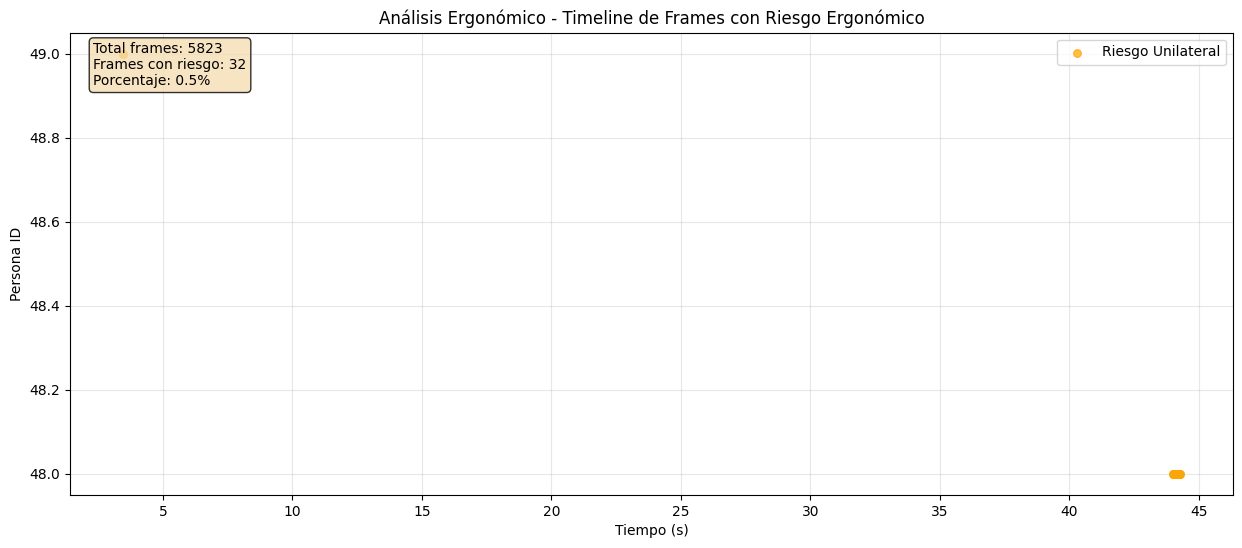

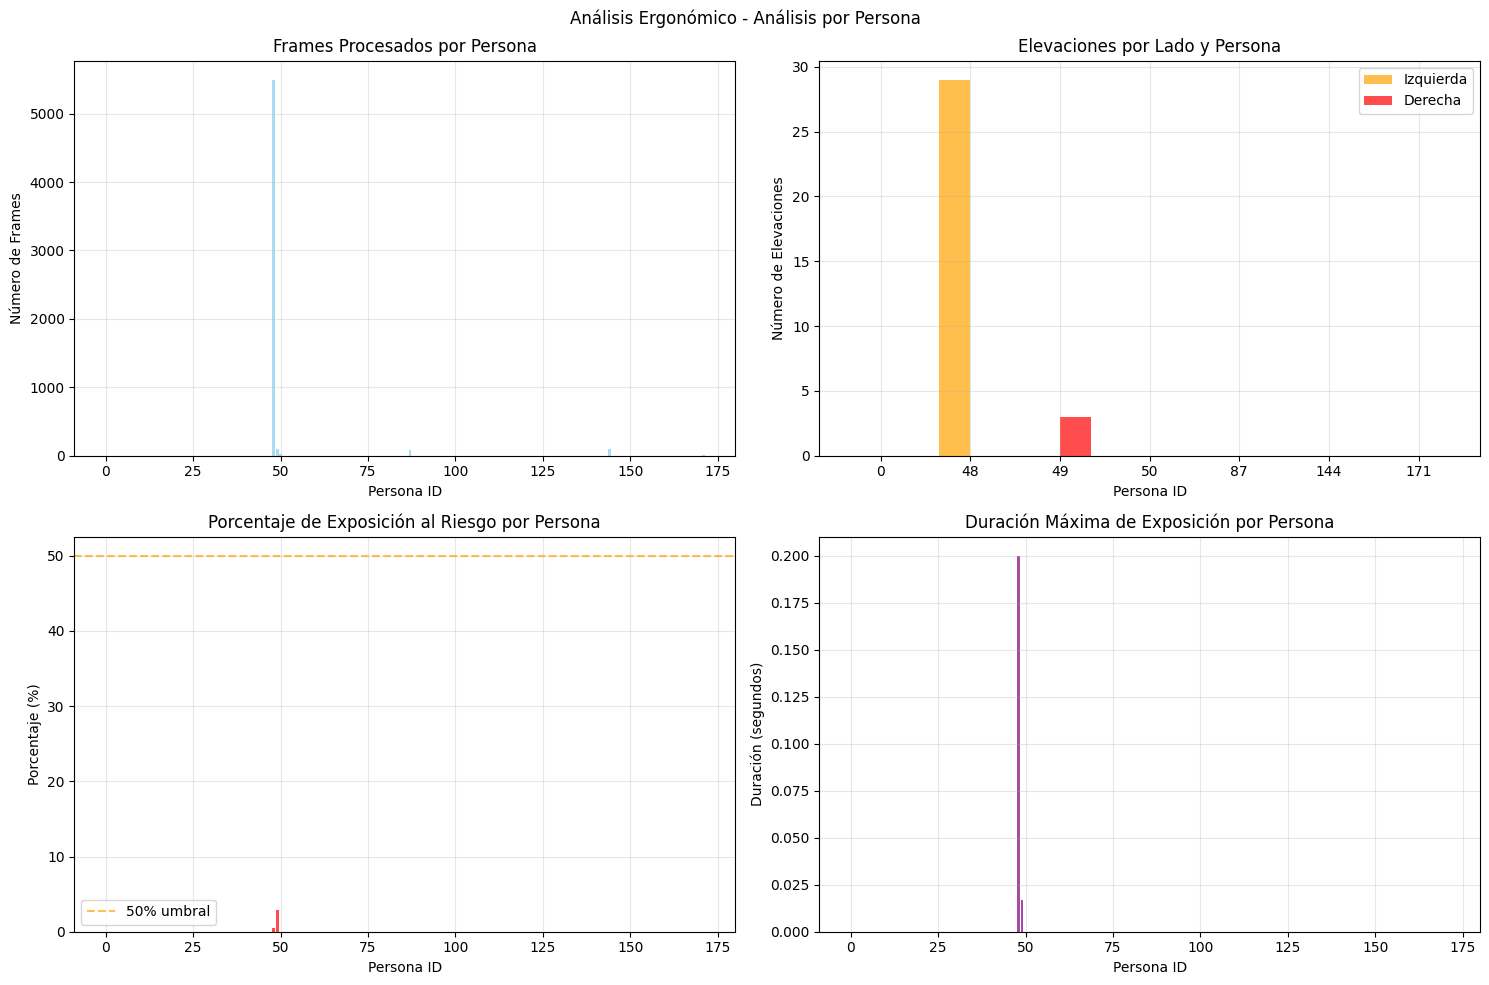

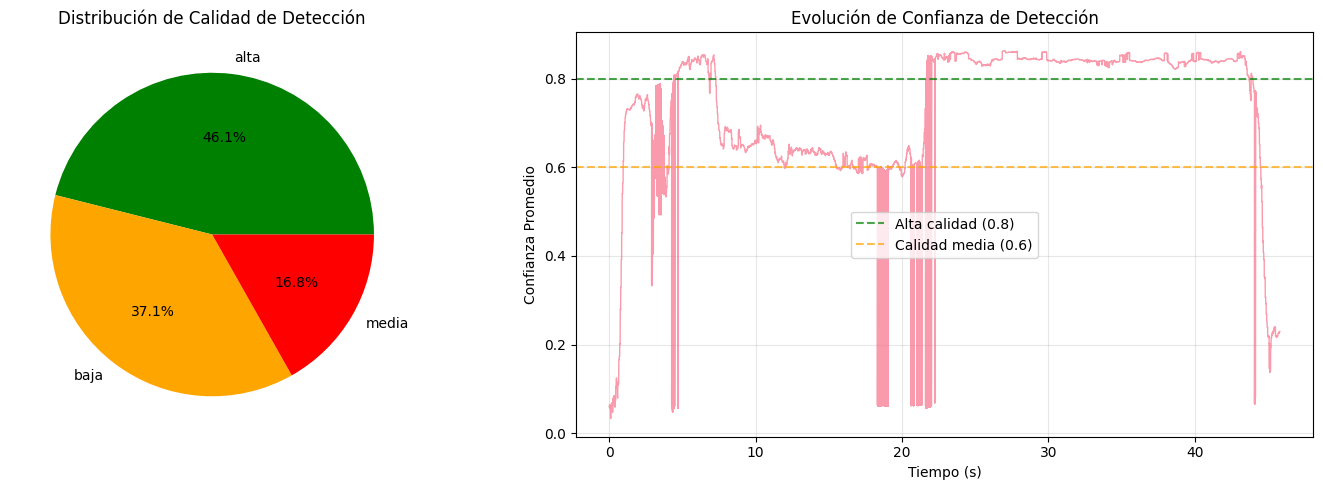

2025-10-16 10:27:55 | INFO     | ✅ Visualización avanzada completada
2025-10-16 10:27:55 | INFO     |    📊 Gráficos generados: 3
2025-10-16 10:27:55 | INFO     |    📈 Total frames: 5823
2025-10-16 10:27:55 | INFO     |    👥 Personas: 7
2025-10-16 10:27:55 | INFO     |    ⚠️ Exposición al riesgo: 0.5%
2025-10-16 10:27:55 | INFO     |    💾 Archivos guardados:
2025-10-16 10:27:55 | INFO     |       graficos/timeline_riesgo.png
2025-10-16 10:27:55 | INFO     |       graficos/estadisticas_persona.png
2025-10-16 10:27:55 | INFO     |       graficos/calidad_deteccion.png


Gráficos completados


In [12]:
# Análisis completo de video con exportación automática
resultado_video = ejecutar_analisis_video(r"C:\Users\wilsfrji\Downloads\MicrosoftTeams-video.mp4")
# 2. Verificar resultado
if 'error' in resultado_video:
    print(f"Error en video: {resultado_video['error']}")
else:
    # 3. Obtener DataFrame
    df_video = resultado_video['dataframe']
    
    # 4. Mostrar estadísticas
    print("ESTADÍSTICAS DEL VIDEO:")
    stats = resultado_video['estadisticas']
    print(f"   Frames procesados: {stats['frames_procesados']}")
    print(f"   Personas detectadas: {stats['personas_unicas']}")
    print(f"   Frames con riesgo: {stats['frames_con_riesgo']}")
    
    # 5. Generar gráficos - SOLO parámetros que existen
    if not df_video.empty:
        print(f"Generando gráficos para {len(df_video)} registros...")
        
        # Usar solo parámetros definidos en tu función
        visualizar_metricas_avanzado(
            df_video, 
            mostrar_graficos=True, 
            guardar_graficos=True
        )
        
        print("Gráficos completados")
    else:
        print("DataFrame vacío, no se pueden crear gráficos")


In [57]:
import inspect
sig = inspect.signature(visualizar_metricas_avanzado)
print("Parámetros disponibles:", sig)

Parámetros disponibles: (df, titulo_analisis='Análisis Ergonómico', mostrar_graficos=True, guardar_graficos=False, carpeta_salida='graficos', incluir_inclinacion=True)
